# LunarLander

- Student Name: Finola Cahill



- [Part 1 - CNN](#CNN)
    - [Baseline](#Baseline)
    - [LeNet Architecture](#LeNet)    
    - [Data Augmentation with weighted classes](#Data-Augmentation-with-weighted-classes)
    - [Unweighted Data Augmentation](#Unweighted-Data-Augmentation)
    - [Balanced Data Generator](#Balanced-Data-Generator)
    - [Random Under Sampling](#Random-Under-Sampling)    
        - [With Data Augmentation](#With-Data-Augmentation) 
        - [Without Data Augmentation](#Without-Data-Augmentation)        
        - [With Dropout](#With-Dropout)
    - [SMOTE](#Smote)
    - [Sequential Input](#Sequential-Input)
        - [With Smote](#Sequential-with-Smote)
    - [Pre-Trained VGG](#Pre-trained-VGG)
    - [CNN model Comparisons](#CNN-Model-Comparisons)
- [Part 2 - RL](#Reinforcement-Learning)
    - [RL Baseline](#RL-baseline)
    - [Increasing Window Length](#Increasing-Window-Length)
    - [Increasing Training Time](#Increasing-Training-Time)
    - [Increasing Sequential Memory Limit](#Increasing-Sequential-Memory-Limit)
    -[Testing RL Models](#Test-RL-Models)
- [Part 3 - Comparison](#Comparison)
- [Part 4 - Discussion](#Discussion)


In [3]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn import svm
import seaborn
import gym
from imblearn.under_sampling import RandomUnderSampler
import math
from IPython.display import SVG
import time
import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL
import warnings
import time
warnings.filterwarnings('ignore')


# CNN

###### Train a supervised machine learning model to control the Lunar Lander craft based on the image dataset and perform a suitable evaluation experiment (based on the dataset) to determine how effective the model trained is.

In [2]:
# Dictionary to store trained models
models = {}

# Setting up dataFrame to store model results
CNN_results = pd.DataFrame(index=['Model Type',
                                  'Sample size',
                                  'Epochs',
                                  'Validation set Accuracy',
                                  'Test set Accuracy',
                                  'Validation set F1',
                                  'Test set F1',
                                  'Training Time'])

train_data_dir = 'trainingdata/'

# Sample data for full-sized data
sample_rate = .1

### Baseline

To establish an initial baseline, I loaded the data in its' raw form. I have not normalised or resized the images.

In [4]:
num_classes = 4
input_shape = (200, 300, 1)

# Initialise arrays for data storage
X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.float)

# Generate filenames from the data folder and do sampling
image_filenames = [train_data_dir+i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset

# Sample the data
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

# Create a data array for image data
count = len(image_filenames)
X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    # Load the images
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)   
    image = image.reshape(input_shape)
    X_data_part[i] = image
    y_data = np.append(y_data, int(image_file[-6]))

print('Processed {} images'.format(i+1))
    
# Append the part to the overall data array
X_data = np.append(X_data, X_data_part, axis=0)
    
print("Data shape: {}".format(X_data.shape))
print(X_data_part[i-1].shape)

Processed 4125 images
Data shape: (4125, 200, 300, 1)
(200, 300, 1)


<AxesSubplot:ylabel='count'>

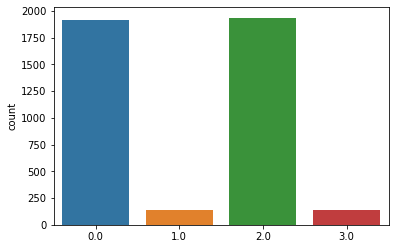

In [5]:
seaborn.countplot(y_data)

As seen above, the data is extremely unbalanced.

In [6]:
# Perfrom split to train, validation, test
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

# Perfrom split to train, validation, test
X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)

In [7]:
X_test[0].shape

(200, 300, 1)

In [8]:
y_train_wide = to_categorical(y_train, num_classes)
y_test_wide = to_categorical(y_test, num_classes)
y_valid_wide = to_categorical(y_valid, num_classes)

I am starting with a super basic model with one convolutional layer without padding, a maxPooling layer and two dense layers.  

In [9]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(3, 3),
                 activation='relu', input_shape=input_shape))
model.add(AveragePooling2D(pool_size=(3,3)))

model.add(Flatten())

model.add(Dense(units=150, activation='relu'))

model.add(Dense(units=4, activation = 'softmax'))

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 298, 6)       60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 66, 99, 6)         0         
_________________________________________________________________
flatten (Flatten)            (None, 39204)             0         
_________________________________________________________________
dense (Dense)                (None, 150)               5880750   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 604       
Total params: 5,881,414
Trainable params: 5,881,414
Non-trainable params: 0
_________________________________________________________________


In [11]:
batch_size = 128
epochs = 20

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_model_1.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()
history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])
end_time = time.time()
model.load_weights(best_weights_filepath)


Epoch 1/20
15/15 [==============================] - 6s 402ms/step - loss: 18.9737 - accuracy: 0.5284 - val_loss: 18.3162 - val_accuracy: 0.6147
Epoch 2/20
15/15 [==============================] - 6s 400ms/step - loss: 9.1102 - accuracy: 0.6286 - val_loss: 4.5134 - val_accuracy: 0.6688
Epoch 3/20
15/15 [==============================] - 6s 399ms/step - loss: 4.2498 - accuracy: 0.6508 - val_loss: 3.2821 - val_accuracy: 0.5628
Epoch 4/20
15/15 [==============================] - 6s 399ms/step - loss: 1.2731 - accuracy: 0.7233 - val_loss: 1.4198 - val_accuracy: 0.6277
Epoch 5/20
15/15 [==============================] - 6s 399ms/step - loss: 0.5737 - accuracy: 0.7537 - val_loss: 0.9289 - val_accuracy: 0.5649
Epoch 6/20
15/15 [==============================] - 6s 409ms/step - loss: 0.3310 - accuracy: 0.7764 - val_loss: 0.7757 - val_accuracy: 0.5952
Epoch 7/20
15/15 [==============================] - 6s 405ms/step - loss: 0.2585 - accuracy: 0.8002 - val_loss: 0.6032 - val_accuracy: 0.6385
Epoc

In [12]:
# saving model results
models['model_1'] = model
models['model_1_history'] = history

Below I am defining functions to plot the loss and accuracy of models, this will avoid a lot of repeated code when evaluating other models later.

In [13]:
def plot_loss(key, name):
    loss = models[key].history['loss']
    val_loss = models[key].history['val_loss']
    plt.figure(figsize=(15,8))
    plt.xlabel('Epochs')
    plt.xticks(rotation=90)
    plt.ylabel('Loss')
    plt.plot(loss, 'blue', label='Training Loss')
    plt.plot(val_loss, 'green', label='Validation Loss')
    plt.xticks(range(0,epochs)[0::2])
    plt.legend()
    plt.title("Loss of train and validation set - " + name)
    plt.show()

In [14]:
def plot_accuracy(key, name):
    loss = models[key].history['accuracy']
    val_loss = models[key].history['val_accuracy']
    plt.figure(figsize=(15,8))
    plt.xlabel('Epochs')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy')
    plt.plot(loss, 'blue', label='Training Accuracy')
    plt.plot(val_loss, 'green', label='Validation Accuracy')
    plt.xticks(range(0,epochs)[0::2])
    plt.legend()
    plt.title("Accuracy of train and validation set - " + name)
    plt.show()

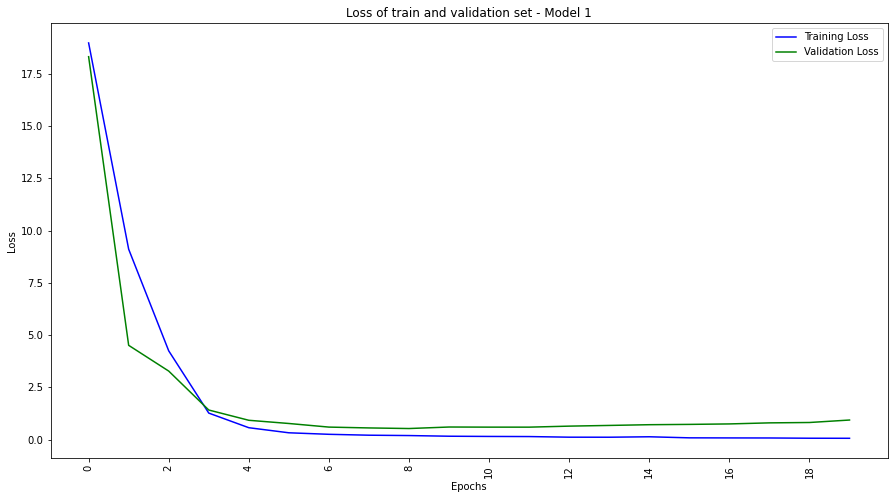

In [15]:
plot_loss('model_1_history', 'Model 1')

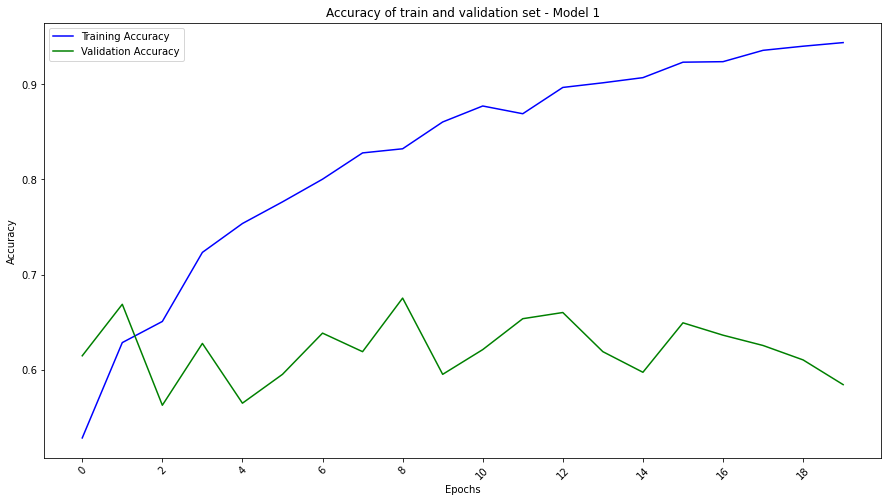

In [16]:
plot_accuracy('model_1_history', 'Model 1')

The model has visibly overfit from around the third epoch. Training accuracy continues to grow but validation accuracy has dropped off.

In [18]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)


In [19]:
def record_results(model_name, description):
    CNN_results[model_name] = [description,
                               sample_rate, epochs, eval_v['accuracy'],
                               eval_t['accuracy'], eval_v['macro avg']['f1-score'],
                               eval_t['macro avg']['f1-score'], end_time-start_time]

In [20]:
record_results('Model 1', 'Unmodified input data and 1 conv layer')
CNN_results

Model 1
Model Type               Unmodified input data and 1 conv layer
Sample size                                                 0.1
Epochs                                                       20
Validation set Accuracy                                0.624567
Test set Accuracy                                      0.662359
Validation set F1                                      0.391548
Test set F1                                             0.45446
Training Time                                           120.844

We can see that the F1 score is significantly lower than the accuracy score, reflecting bias in the model due to the unbalanced data.

### LeNet

Next I will reload the data, this time resizing and normalising it. I've decided to try the data out on a LeNet architecture, so I will be resizing the images to 32 * 32. Thanks to the decreased size of the images, training will be quicker, so I will be using the full training data set available.

In [21]:
# # desired dimensions of our images.
img_width, img_height = 32, 32

# # Set input shape
input_shape = (img_width, img_height, 1)

In [22]:
# Initialise arrays for data storage
X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.float)


# Generate filenames from the data folder
image_filenames = [train_data_dir+i for i in os.listdir(train_data_dir) if not i.startswith('.')]

# Create a data array for image data
count = len(image_filenames)
X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    # Load the images and resize them
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
    image = image.reshape(input_shape)

    X_data_part[i] = image
    # normalise the data
    X_data_part[i] = X_data_part[i]/255
    
    # Add label to label array
    y_data = np.append(y_data, int(image_file[-6]))

print('Processed {} images'.format(i+1))
    
# Append the part to the overall data array
X_data = np.append(X_data, X_data_part, axis=0)
    
print("Data shape: {}".format(X_data.shape))
print(X_data_part[i-1].shape)

Processed 41251 images
Data shape: (41251, 32, 32, 1)
(32, 32, 1)


In [23]:
# Perfrom split to train, validation, test
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

# Perfrom split to train, validation, test
X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)

y_train_wide = to_categorical(y_train, num_classes)
y_test_wide = to_categorical(y_test, num_classes)
y_valid_wide = to_categorical(y_valid, num_classes)

Implementing LeNet model below

In [24]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(3, 3),
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(filters=16, kernel_size=(3, 3),
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=4, activation = 'softmax'))
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_3 (Dense)              (None, 84)               

In [25]:
best_weights_filepath = './best_weights_model_2.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)

start_time = time.time()
history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

end_time = time.time()

model.load_weights(best_weights_filepath)

Epoch 1/20
145/145 [==============================] - 3s 15ms/step - loss: 0.4304 - accuracy: 0.5236 - val_loss: 0.4004 - val_accuracy: 0.5749
Epoch 2/20
145/145 [==============================] - 2s 14ms/step - loss: 0.3740 - accuracy: 0.6426 - val_loss: 0.3804 - val_accuracy: 0.6236
Epoch 3/20
145/145 [==============================] - 2s 14ms/step - loss: 0.3661 - accuracy: 0.6632 - val_loss: 0.3590 - val_accuracy: 0.6675
Epoch 4/20
145/145 [==============================] - 2s 15ms/step - loss: 0.3566 - accuracy: 0.6706 - val_loss: 0.3557 - val_accuracy: 0.6593
Epoch 5/20
145/145 [==============================] - 2s 14ms/step - loss: 0.3526 - accuracy: 0.6721 - val_loss: 0.3649 - val_accuracy: 0.6636
Epoch 6/20
145/145 [==============================] - 2s 15ms/step - loss: 0.3488 - accuracy: 0.6763 - val_loss: 0.3526 - val_accuracy: 0.6677
Epoch 7/20
145/145 [==============================] - 2s 15ms/step - loss: 0.3470 - accuracy: 0.6749 - val_loss: 0.3478 - val_accuracy: 0.6706

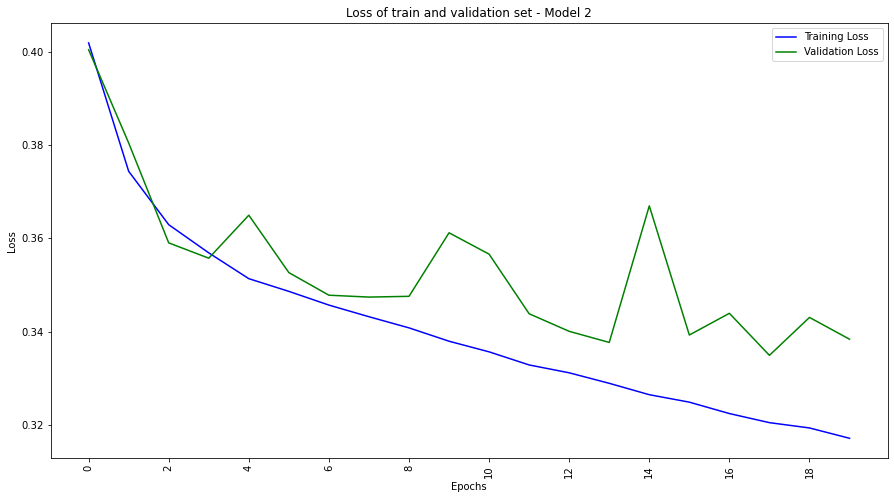

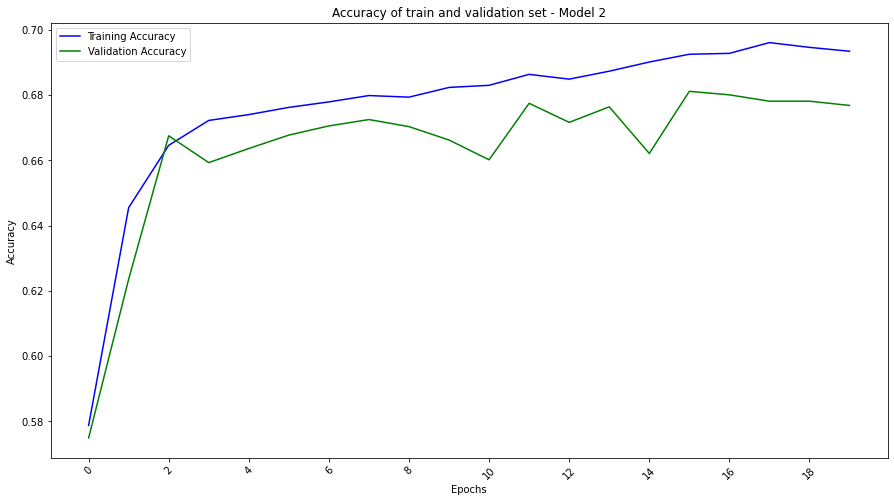

In [26]:
models['model_2'] = model
models['model_2_history'] = history

plot_loss('model_2_history', 'Model 2')
plot_accuracy('model_2_history', 'Model 2')

In [27]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)

In [28]:
record_results('Model 2', '32*32 resized and normalised images on LeNet')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  
Model Type               32*32 resized and normalised images on LeNet  
Sample size                                                         1  
Epochs                                                             20  
Validation set Accuracy                                      0.695065  
Test set Accuracy                                             0.68948  
Validation set F1                                            0.411632  
Test set F1                                                  0.398209  
Training Time                                                 44.9329

Training time has significantly decreased, despite using the entire dataset. Accuracy has increased on both the validation and the test set, and the F1 score has improved on the validation set. The F1 score has actually dropped on the Test set though. 

### Data Augmentation with weighted classes


Class 1 and class 3 are being under-predicted due to the imbalance in the data. This is can be seen by comparing the accuracy score to the lower F1 score. Data augmentation is a technique used to create new training data. I thought that perhaps by adding extra, augmented data, and manually weighting the classes in favor of the minority classes, we may alleviate some bias.

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# fit parameters from data
datagen.fit(X_train)

In [31]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(y_train), 
                y_train)
c_weights = dict(zip(np.unique(y_train), class_weights))
c_weights

{0.0: 0.5364607524384579,
 1.0: 8.020833333333334,
 2.0: 0.5333394902105651,
 3.0: 7.337992376111817}

In [32]:

best_weights_filepath = './best_weights_model_3.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()
history = model.fit_generator(datagen.flow(X_train, y_train_wide, batch_size=batch_size),
          steps_per_epoch=len(X_train) / batch_size,
          validation_data=(X_valid, y_valid_wide),
          class_weight=c_weights,
          epochs=epochs,
          verbose = 1,
          shuffle = True,
          callbacks=[mcp])
end_time = time.time()
model.load_weights(best_weights_filepath)

Epoch 1/20
180/180 [==============================] - 7s 34ms/step - loss: 0.5760 - accuracy: 0.3793 - val_loss: 0.5150 - val_accuracy: 0.5803
Epoch 2/20
180/180 [==============================] - 6s 34ms/step - loss: 0.5536 - accuracy: 0.4843 - val_loss: 0.4946 - val_accuracy: 0.6168
Epoch 3/20
180/180 [==============================] - 6s 33ms/step - loss: 0.5491 - accuracy: 0.5029 - val_loss: 0.4557 - val_accuracy: 0.6296
Epoch 4/20
180/180 [==============================] - 6s 32ms/step - loss: 0.5441 - accuracy: 0.5302 - val_loss: 0.5073 - val_accuracy: 0.6054
Epoch 5/20
180/180 [==============================] - 6s 32ms/step - loss: 0.5425 - accuracy: 0.5188 - val_loss: 0.4718 - val_accuracy: 0.6140
Epoch 6/20
180/180 [==============================] - 6s 32ms/step - loss: 0.5403 - accuracy: 0.5229 - val_loss: 0.4290 - val_accuracy: 0.6100
Epoch 7/20
180/180 [==============================] - 6s 33ms/step - loss: 0.5393 - accuracy: 0.5342 - val_loss: 0.4532 - val_accuracy: 0.6125

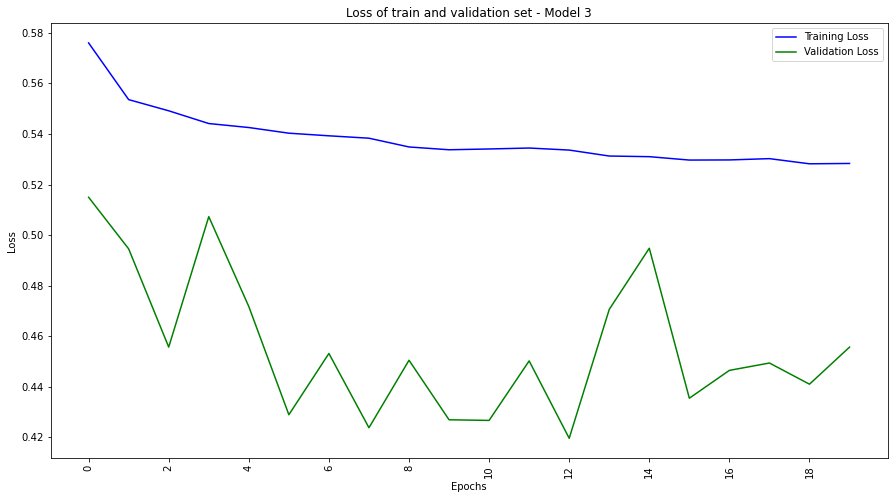

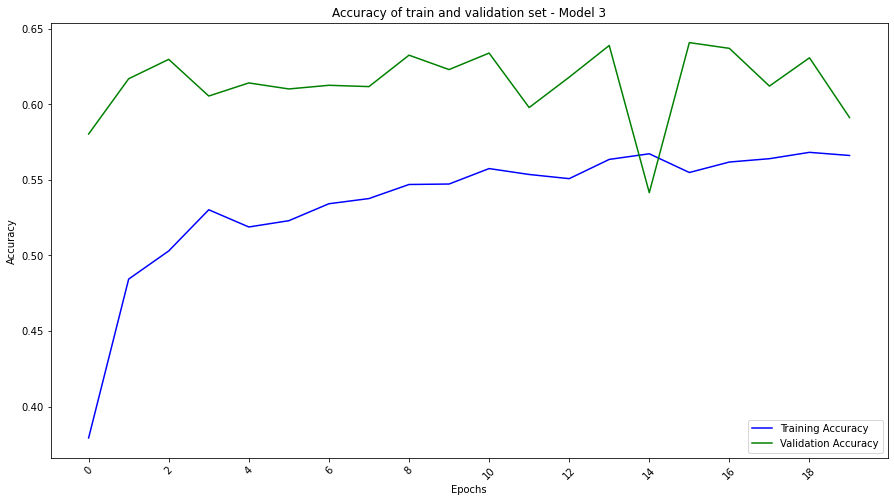

In [33]:
models['model_3'] = model
models['model_3_history'] = history

plot_loss('model_3_history', 'Model 3')
plot_accuracy('model_3_history', 'Model 3')

Interestingly the validation set is performing quite a bit better than the training set.

In [34]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)

In [35]:
record_results('Model 3', 'Previous model architecture with data augmentation and class weights')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                   Model 3  
Model Type               Previous model architecture with data augmenta...  
Sample size                                                              1  
Epochs                                                                  20  
Validation set Accuracy                                           0.640693  
Test set Accuracy                                                 0.629121  
Validation set F1                                                 0.388973  
Test set F1                                                       0.372987  
Training Time                                                      121.472

Unfortunately this model did not perform well when presented with un-augmented data. Although accuracy did not drop too much, the f1 Scores on both the validation and the test set dropped as compared with the previous model.

### Unweighted Data Augmentation

The weighting of classes to address bias has not had the desired affect, let's see if data augmentation without class-weighting improves performance.

In [36]:
best_weights_filepath = './best_weights_model_4.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()

history = model.fit_generator(datagen.flow(X_train, y_train_wide, batch_size=128),
          steps_per_epoch=len(X_train) / 128,
          validation_data=(X_valid, y_valid_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp])

end_time = time.time()
model.load_weights(best_weights_filepath)

Epoch 1/20
180/180 [==============================] - 6s 34ms/step - loss: 0.3823 - accuracy: 0.6359 - val_loss: 0.3800 - val_accuracy: 0.6594
Epoch 2/20
180/180 [==============================] - 6s 33ms/step - loss: 0.3740 - accuracy: 0.6448 - val_loss: 0.3683 - val_accuracy: 0.6672
Epoch 3/20
180/180 [==============================] - 6s 33ms/step - loss: 0.3732 - accuracy: 0.6465 - val_loss: 0.3685 - val_accuracy: 0.6606
Epoch 4/20
180/180 [==============================] - 6s 34ms/step - loss: 0.3704 - accuracy: 0.6505 - val_loss: 0.3597 - val_accuracy: 0.6696
Epoch 5/20
180/180 [==============================] - 6s 33ms/step - loss: 0.3713 - accuracy: 0.6492 - val_loss: 0.3833 - val_accuracy: 0.6573
Epoch 6/20
180/180 [==============================] - 6s 34ms/step - loss: 0.3698 - accuracy: 0.6514 - val_loss: 0.3788 - val_accuracy: 0.6717
Epoch 7/20
180/180 [==============================] - 6s 34ms/step - loss: 0.3695 - accuracy: 0.6513 - val_loss: 0.3742 - val_accuracy: 0.6604

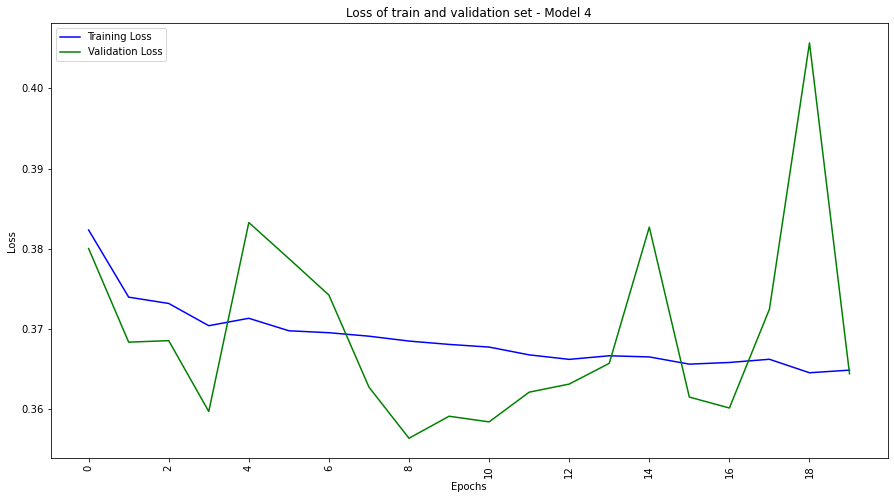

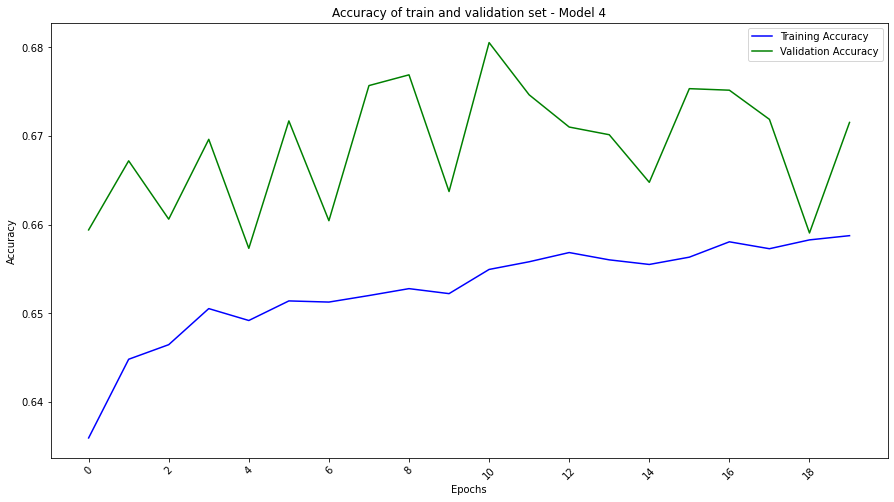

In [37]:
models['model_4'] = model
models['model_4_history'] = history

plot_loss('model_4_history', 'Model 4')
plot_accuracy('model_4_history', 'Model 4')

Again, the validation set is performing well on the augmented data. 

In [38]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)

In [39]:
record_results('Model 4', 'Data augmentation without manually set class weights')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                   Model 3  \
Model Type               Previous model architecture with data augmenta...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.640693   
Test set Accuracy                                                 0.629121   
Validation set F1                                                 0.388973   
Test set F1                                                       0.372987   
Training Time                                                      121.472   

                                                                   Model 4  
Model Type               Data augmentation without manually set class w...  
Sample size                                                              1  
Epochs                                                                  20  
Validation set Accuracy                                           0.680519  
Test set Accuracy                                                 0.672754  
Validation set F1                                                 0.348477  
Test set F1                                                        0.34481  
Training Time                                                      120.403

Although this model has improved better than the weighted model, it is still underperforming compared to the Model trained on un-augmented data.

### Balanced Data Generator

When researching data augmentation for unbalanced data, I came upon this article which uses the balanced_batch_generator from Keras to try and rebalance the dataset. The "BalancedDataGenerator" code below is taken from this article:
https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9

In [40]:
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [41]:
balanced_gen = BalancedDataGenerator(X_train, y_train_wide, datagen, batch_size=128)
steps_per_epoch = balanced_gen.steps_per_epoch


In [42]:
best_weights_filepath = './best_weights_model_5.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()

history = model.fit_generator(balanced_gen,
          steps_per_epoch=steps_per_epoch,
          validation_data=(X_valid, y_valid_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp])

end_time = time.time()
model.load_weights(best_weights_filepath)

Epoch 1/20
338/338 [==============================] - 11s 32ms/step - loss: 0.5258 - accuracy: 0.4003 - val_loss: 0.4738 - val_accuracy: 0.5803
Epoch 2/20
338/338 [==============================] - 10s 29ms/step - loss: 0.5195 - accuracy: 0.4090 - val_loss: 0.4657 - val_accuracy: 0.6014
Epoch 3/20
338/338 [==============================] - 10s 29ms/step - loss: 0.5191 - accuracy: 0.4093 - val_loss: 0.4781 - val_accuracy: 0.5984
Epoch 4/20
338/338 [==============================] - 10s 29ms/step - loss: 0.5173 - accuracy: 0.4114 - val_loss: 0.4851 - val_accuracy: 0.6003
Epoch 5/20
338/338 [==============================] - 10s 29ms/step - loss: 0.5171 - accuracy: 0.4120 - val_loss: 0.4796 - val_accuracy: 0.6171
Epoch 6/20
338/338 [==============================] - 10s 29ms/step - loss: 0.5168 - accuracy: 0.4109 - val_loss: 0.4762 - val_accuracy: 0.6052
Epoch 7/20
338/338 [==============================] - 10s 29ms/step - loss: 0.5166 - accuracy: 0.4141 - val_loss: 0.4911 - val_accuracy:

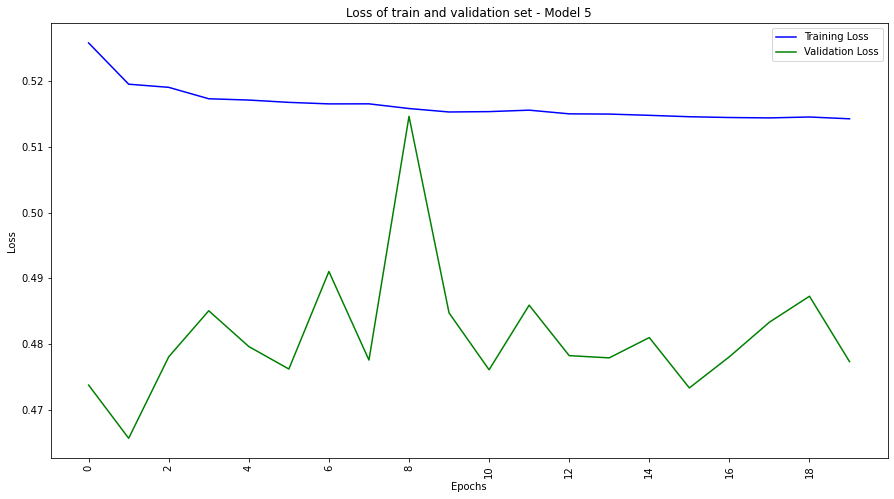

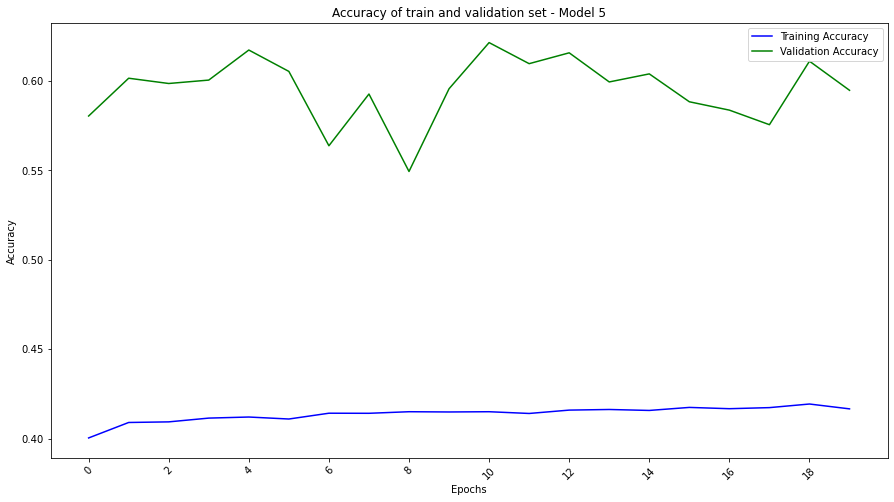

In [43]:
models['model_5'] = model
models['model_5_history'] = history

plot_loss('model_5_history', 'Model 5')
plot_accuracy('model_5_history', 'Model 5')

In [44]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)

In [45]:
record_results('Model 5', 'Data augmentation using BalancedDataGenerator')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                   Model 3  \
Model Type               Previous model architecture with data augmenta...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.640693   
Test set Accuracy                                                 0.629121   
Validation set F1                                                 0.388973   
Test set F1                                                       0.372987   
Training Time                                                      121.472   

                                                                   Model 4  \
Model Type               Data augmentation without manually set class w...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.680519   
Test set Accuracy                                                 0.672754   
Validation set F1                                                 0.348477   
Test set F1                                                        0.34481   
Training Time                                                      120.403   

                                                               Model 5  
Model Type               Data augmentation using BalancedDataGenerator  
Sample size                                                          1  
Epochs                                                              20  
Validation set Accuracy                                       0.621299  
Test set Accuracy                                             0.617081  
Validation set F1                                             0.403851  
Test set F1                                                   0.406119  
Training Time                                                  199.156

This worked quite well comparatively. Although the accuracy score is lower than Model 3 and Model 4, the F1 score on both the Test and Validation set is high. This was very slow to run though, with training time taking over 4 times longer than Model 2, which has relatively comparible F1 scores.

### Random Under Sampling

I then decided to try rebalancing the dataset with random undersampling. As I am using the entire dataset to train, I am hoping that undersampling does not affect accuracy or introduce new biases.

In [46]:
from imblearn.under_sampling import RandomUnderSampler
import math

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train.reshape(len(X_train), math.prod(input_shape)), y_train)
X_train_rus, y_train_rus = shuffle(X_train_rus, y_train_rus)
X_train_rus = X_train_rus.reshape(len(X_train_rus), input_shape[0], input_shape[1], input_shape[2])
y_train_rus_wide = tensorflow.keras.utils.to_categorical(y_train_rus, num_classes)

<AxesSubplot:ylabel='count'>

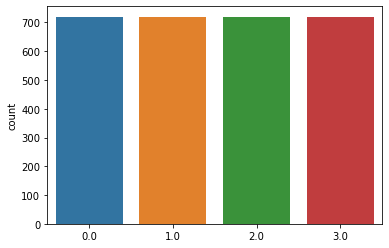

In [47]:
seaborn.countplot(y_train_rus)

In [48]:
X_train_rus.shape, X_train.shape

((2880, 32, 32, 1), (23100, 32, 32, 1))

The dataset is now balanced.

#### With Data Augmentation

In [49]:
datagen.fit(X_train_rus)

In [50]:
best_weights_filepath = './best_weights_model_6.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()

history = model.fit_generator(datagen.flow(X_train_rus, y_train_rus_wide, batch_size=batch_size),
          steps_per_epoch=len(X_train_rus) / batch_size,
          validation_data=(X_valid, y_valid_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp])

end_time = time.time()
model.load_weights(best_weights_filepath)

Epoch 1/20
22/22 [==============================] - 1s 48ms/step - loss: 0.5154 - accuracy: 0.4156 - val_loss: 0.5025 - val_accuracy: 0.5700
Epoch 2/20
22/22 [==============================] - 1s 49ms/step - loss: 0.5174 - accuracy: 0.4212 - val_loss: 0.4736 - val_accuracy: 0.6040
Epoch 3/20
22/22 [==============================] - 1s 48ms/step - loss: 0.5178 - accuracy: 0.4108 - val_loss: 0.5156 - val_accuracy: 0.5309
Epoch 4/20
22/22 [==============================] - 1s 46ms/step - loss: 0.5163 - accuracy: 0.4177 - val_loss: 0.4870 - val_accuracy: 0.5671
Epoch 5/20
22/22 [==============================] - 1s 47ms/step - loss: 0.5176 - accuracy: 0.4125 - val_loss: 0.5072 - val_accuracy: 0.5326
Epoch 6/20
22/22 [==============================] - 1s 48ms/step - loss: 0.5173 - accuracy: 0.4163 - val_loss: 0.4864 - val_accuracy: 0.5609
Epoch 7/20
22/22 [==============================] - 1s 49ms/step - loss: 0.5155 - accuracy: 0.4212 - val_loss: 0.4970 - val_accuracy: 0.5782
Epoch 8/20
22

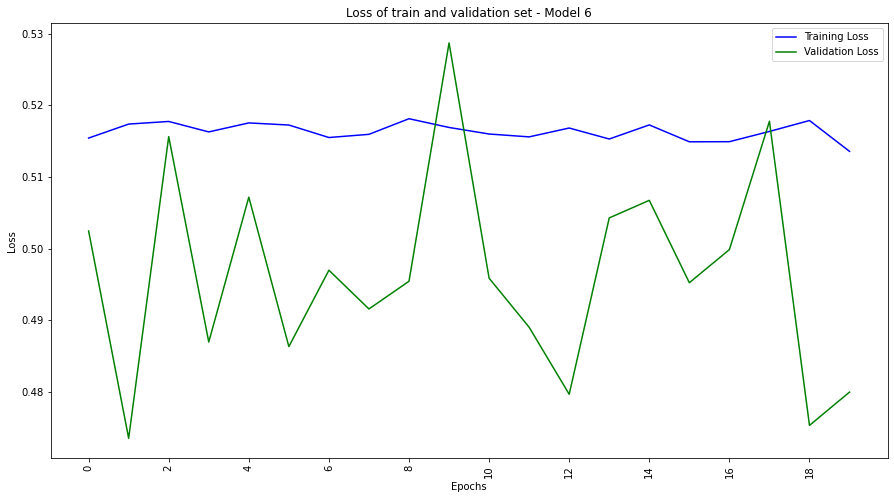

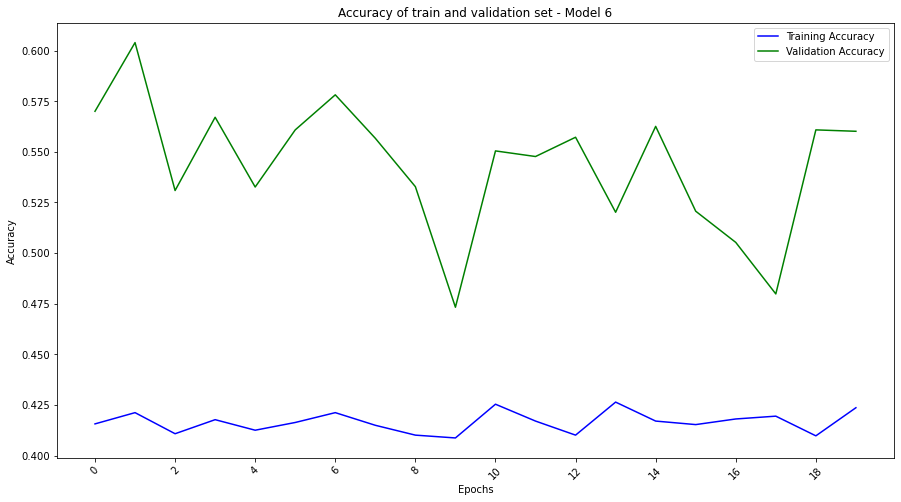

In [51]:
models['model_6'] = model
models['model_6_history'] = history

plot_loss('model_6_history', 'Model 6')
plot_accuracy('model_6_history', 'Model 6')

In [52]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)

In [53]:
record_results('Model 6', 'Random UnderSampling to balance the data with Data Augmentation.')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                   Model 3  \
Model Type               Previous model architecture with data augmenta...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.640693   
Test set Accuracy                                                 0.629121   
Validation set F1                                                 0.388973   
Test set F1                                                       0.372987   
Training Time                                                      121.472   

                                                                   Model 4  \
Model Type               Data augmentation without manually set class w...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.680519   
Test set Accuracy                                                 0.672754   
Validation set F1                                                 0.348477   
Test set F1                                                        0.34481   
Training Time                                                      120.403   

                                                               Model 5  \
Model Type               Data augmentation using BalancedDataGenerator   
Sample size                                                          1   
Epochs                                                              20   
Validation set Accuracy                                       0.621299   
Test set Accuracy                                             0.617081   
Validation set F1                                             0.403851   
Test set F1                                                   0.406119   
Training Time                                                  199.156   

                                                                   Model 6  
Model Type               Random UnderSampling to balance the data with ...  
Sample size                                                              1  
Epochs                                                                  20  
Validation set Accuracy                                           0.603983  
Test set Accuracy                                                 0.598901  
Validation set F1                                                 0.392735  
Test set F1                                                       0.390721  
Training Time                                                      21.4401

In [54]:
best_weights_filepath = './best_weights_model_7.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()
history = model.fit(X_train_rus, y_train_rus_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])
end_time = time.time()
model.load_weights(best_weights_filepath)

Epoch 1/20
18/18 [==============================] - 0s 24ms/step - loss: 0.5044 - accuracy: 0.4288 - val_loss: 0.5020 - val_accuracy: 0.4306
Epoch 2/20
18/18 [==============================] - 0s 20ms/step - loss: 0.4975 - accuracy: 0.4379 - val_loss: 0.4972 - val_accuracy: 0.4479
Epoch 3/20
18/18 [==============================] - 0s 21ms/step - loss: 0.4934 - accuracy: 0.4457 - val_loss: 0.4965 - val_accuracy: 0.4375
Epoch 4/20
18/18 [==============================] - 0s 22ms/step - loss: 0.4902 - accuracy: 0.4588 - val_loss: 0.5000 - val_accuracy: 0.4392
Epoch 5/20
18/18 [==============================] - 0s 20ms/step - loss: 0.4838 - accuracy: 0.4727 - val_loss: 0.4961 - val_accuracy: 0.4410
Epoch 6/20
18/18 [==============================] - 0s 19ms/step - loss: 0.4816 - accuracy: 0.4800 - val_loss: 0.5025 - val_accuracy: 0.4531
Epoch 7/20
18/18 [==============================] - 0s 20ms/step - loss: 0.4765 - accuracy: 0.4831 - val_loss: 0.4932 - val_accuracy: 0.4340
Epoch 8/20
18

#### Without Data Augmentation

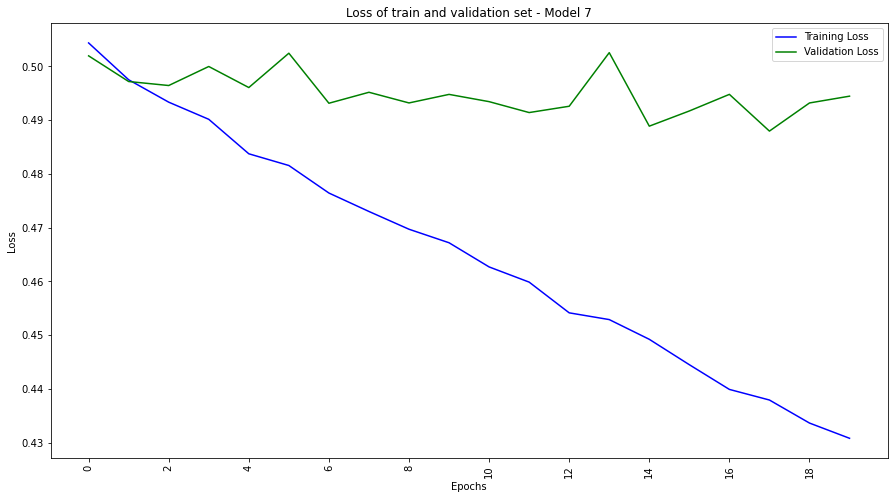

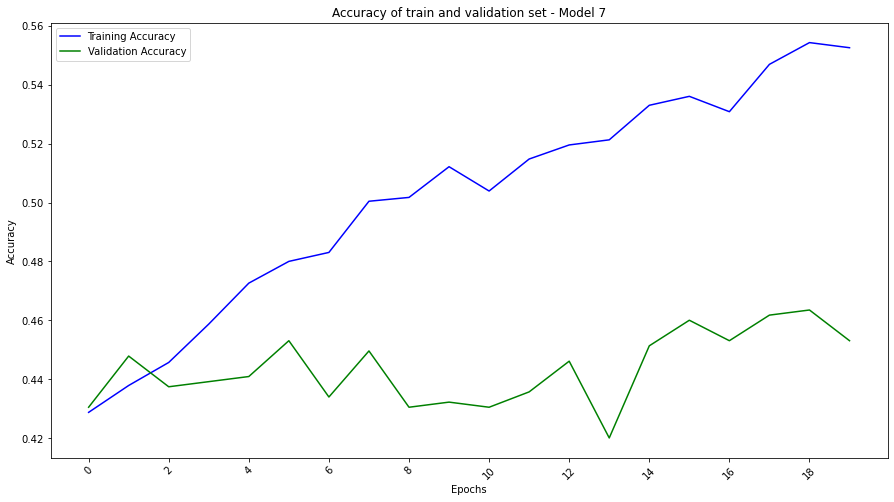

In [55]:
models['model_7'] = model
models['model_7_history'] = history

plot_loss('model_7_history', 'Model 7')
plot_accuracy('model_7_history', 'Model 7')

In [56]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)

In [57]:
record_results('Model 7', 'Random UnderSampling to balance the data with no Data Augmentation.')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                   Model 3  \
Model Type               Previous model architecture with data augmenta...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.640693   
Test set Accuracy                                                 0.629121   
Validation set F1                                                 0.388973   
Test set F1                                                       0.372987   
Training Time                                                      121.472   

                                                                   Model 4  \
Model Type               Data augmentation without manually set class w...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.680519   
Test set Accuracy                                                 0.672754   
Validation set F1                                                 0.348477   
Test set F1                                                        0.34481   
Training Time                                                      120.403   

                                                               Model 5  \
Model Type               Data augmentation using BalancedDataGenerator   
Sample size                                                          1   
Epochs                                                              20   
Validation set Accuracy                                       0.621299   
Test set Accuracy                                             0.617081   
Validation set F1                                             0.403851   
Test set F1                                                   0.406119   
Training Time                                                  199.156   

                                                                   Model 6  \
Model Type               Random UnderSampling to balance the data with ...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.603983   
Test set Accuracy                                                 0.598901   
Validation set F1                                                 0.392735   
Test set F1                                                       0.390721   
Training Time                                                      21.4401   

                  

Undersampling makes the models very fast to train, but unfortunately we can see there has been a drop in both accuracy and F1 scores. Of the two undersampled models, the model with data augmentation performed much better than the unaugmented data.

#### With Dropout

In order to try and reduce the effects of overfitting, I decided to add some drop out to the model

In [333]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(3, 3),
                 activation='relu', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3),
                 activation='relu', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=84, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(units=4, activation = 'softmax'))

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 6)         60        
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 6)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 576)             

In [59]:
best_weights_filepath = './best_weights_model_8.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()
history = model.fit(X_train_rus, y_train_rus_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])
end_time = time.time()
model.load_weights(best_weights_filepath)

Epoch 1/20
18/18 [==============================] - 1s 28ms/step - loss: 0.6164 - accuracy: 0.2758 - val_loss: 0.5755 - val_accuracy: 0.2413
Epoch 2/20
18/18 [==============================] - 0s 21ms/step - loss: 0.5706 - accuracy: 0.2756 - val_loss: 0.5697 - val_accuracy: 0.2830
Epoch 3/20
18/18 [==============================] - 0s 21ms/step - loss: 0.5700 - accuracy: 0.2848 - val_loss: 0.5632 - val_accuracy: 0.3385
Epoch 4/20
18/18 [==============================] - 0s 22ms/step - loss: 0.5639 - accuracy: 0.3021 - val_loss: 0.5645 - val_accuracy: 0.3524
Epoch 5/20
18/18 [==============================] - 0s 21ms/step - loss: 0.5592 - accuracy: 0.3378 - val_loss: 0.5581 - val_accuracy: 0.3681
Epoch 6/20
18/18 [==============================] - 0s 21ms/step - loss: 0.5509 - accuracy: 0.3676 - val_loss: 0.5499 - val_accuracy: 0.3837
Epoch 7/20
18/18 [==============================] - 0s 21ms/step - loss: 0.5440 - accuracy: 0.3953 - val_loss: 0.5458 - val_accuracy: 0.3976
Epoch 8/20
18

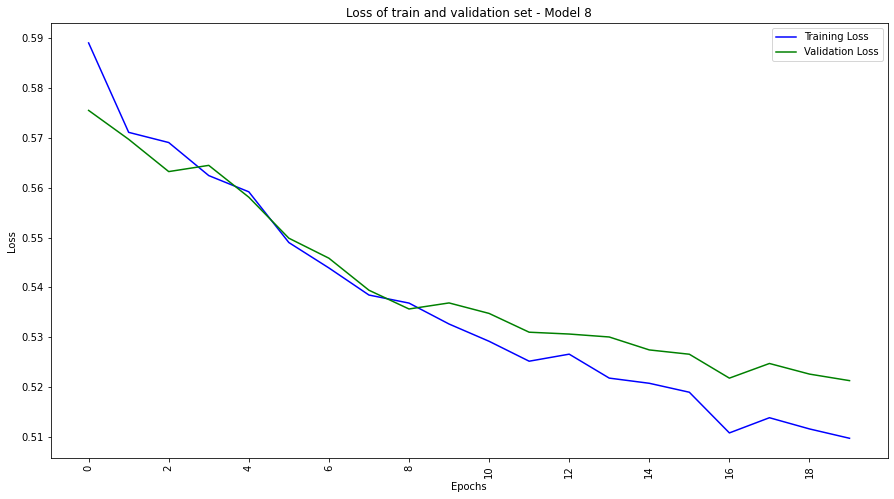

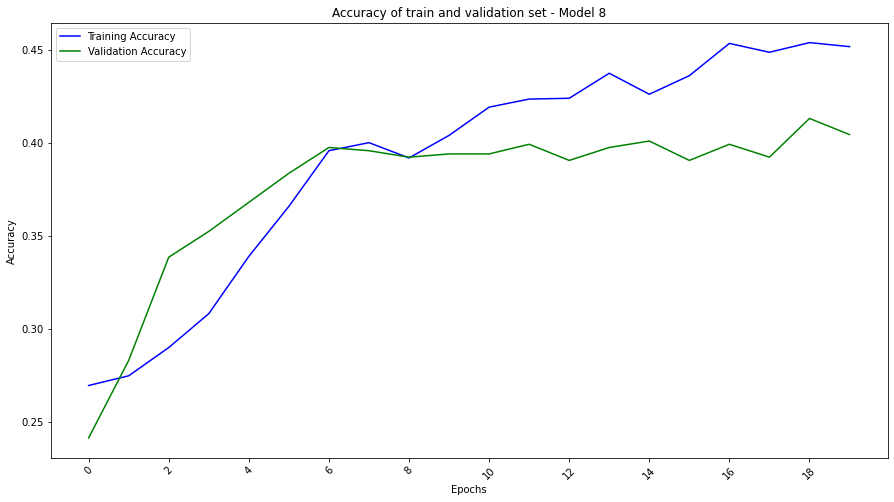

In [60]:
models['model_8'] = model
models['model_8_history'] = history

plot_loss('model_8_history', 'Model 8')
plot_accuracy('model_8_history', 'Model 8')

Upon visual inspection, it seems that overfitting has been reduced, the training and validation curves are following similar trends.

In [61]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)

In [62]:
record_results('Model 8', 'Previous architecture with added dropout')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                   Model 3  \
Model Type               Previous model architecture with data augmenta...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.640693   
Test set Accuracy                                                 0.629121   
Validation set F1                                                 0.388973   
Test set F1                                                       0.372987   
Training Time                                                      121.472   

                                                                   Model 4  \
Model Type               Data augmentation without manually set class w...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.680519   
Test set Accuracy                                                 0.672754   
Validation set F1                                                 0.348477   
Test set F1                                                        0.34481   
Training Time                                                      120.403   

                                                               Model 5  \
Model Type               Data augmentation using BalancedDataGenerator   
Sample size                                                          1   
Epochs                                                              20   
Validation set Accuracy                                       0.621299   
Test set Accuracy                                             0.617081   
Validation set F1                                             0.403851   
Test set F1                                                   0.406119   
Training Time                                                  199.156   

                                                                   Model 6  \
Model Type               Random UnderSampling to balance the data with ...   
Sample size                                                              1   
Epochs                                                                  20   
Validation set Accuracy                                           0.603983   
Test set Accuracy                                                 0.598901   
Validation set F1                                                 0.392735   
Test set F1                                                       0.390721   
Training Time                                                      21.4401   

                  

Unfortunately the dropout has not improved performance on the validation and test sets.

## Smote

As undersampling was not giving the desired performance improvement, I decided to try oversampling with SMOTE.

In [63]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_train_smo, y_train_smo = sm.fit_sample(X_train.reshape(len(X_train), math.prod(input_shape)), y_train)
X_train_smo, y_train_smo = shuffle(X_train_smo, y_train_smo)
X_train_smo = X_train_smo.reshape(len(X_train_smo), input_shape[0], input_shape[1], input_shape[2])
y_train_smo_wide = tensorflow.keras.utils.to_categorical(y_train_smo, num_classes)

<AxesSubplot:ylabel='count'>

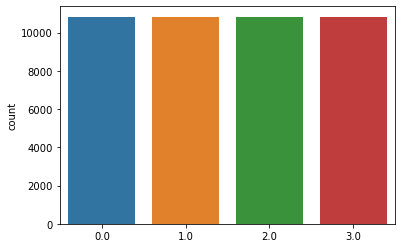

In [64]:
seaborn.countplot(y_train_smo)

In [65]:
pd.set_option('display.max_colwidth', None)
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                                      Model 3  \
Model Type               Previous model architecture with data augmentation and class weights   
Sample size                                                                                 1   
Epochs                                                                                     20   
Validation set Accuracy                                                              0.640693   
Test set Accuracy                                                                    0.629121   
Validation set F1                                                                    0.388973   
Test set F1                                                                          0.372987   
Training Time                                                                         121.472   

                                                                      Model 4  \
Model Type               Data augmentation without manually set class weights   
Sample size                                                                 1   
Epochs                                                                     20   
Validation set Accuracy                                              0.680519   
Test set Accuracy                                                    0.672754   
Validation set F1                                                    0.348477   
Test set F1                                                           0.34481   
Training Time                                                         120.403   

                                                               Model 5  \
Model Type               Data augmentation using BalancedDataGenerator   
Sample size                                                          1   
Epochs                                                              20   
Validation set Accuracy                                       0.621299   
Test set Accuracy                                             0.617081   
Validation set F1                                             0.403851   
Test set F1                                                   0.406119   
Training Time                                                  199.156   

                                                                                  Model 6  \
Model Type               Random UnderSampling to balance the data with Data Augmentation.   
Sample size                                                                             1   
Epochs                                                                                 20   
Validation set Accuracy                                                          0.603983   
Test set Accuracy                                         

I initially ran this for 20 epochs like the other models, but loss on the validation set was still falling, and it didn't look overfit. I decided to give it another 30 epochs to see where it went.

In [66]:
epochs=50
best_weights_filepath = './best_weights_model_9.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()
history = model.fit(X_train_smo, y_train_smo_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])
end_time = time.time()
model.load_weights(best_weights_filepath)

Epoch 1/50
271/271 [==============================] - 6s 22ms/step - loss: 0.4833 - accuracy: 0.5057 - val_loss: 0.4447 - val_accuracy: 0.5647
Epoch 2/50
271/271 [==============================] - 6s 22ms/step - loss: 0.4416 - accuracy: 0.5693 - val_loss: 0.4094 - val_accuracy: 0.6336
Epoch 3/50
271/271 [==============================] - 6s 22ms/step - loss: 0.4083 - accuracy: 0.6105 - val_loss: 0.3863 - val_accuracy: 0.6552
Epoch 4/50
271/271 [==============================] - 6s 22ms/step - loss: 0.3839 - accuracy: 0.6341 - val_loss: 0.3605 - val_accuracy: 0.6769
Epoch 5/50
271/271 [==============================] - 7s 25ms/step - loss: 0.3664 - accuracy: 0.6571 - val_loss: 0.3403 - val_accuracy: 0.7005
Epoch 6/50
271/271 [==============================] - 9s 33ms/step - loss: 0.3519 - accuracy: 0.6711 - val_loss: 0.3313 - val_accuracy: 0.7041
Epoch 7/50
271/271 [==============================] - 13s 48ms/step - loss: 0.3416 - accuracy: 0.6792 - val_loss: 0.3146 - val_accuracy: 0.717

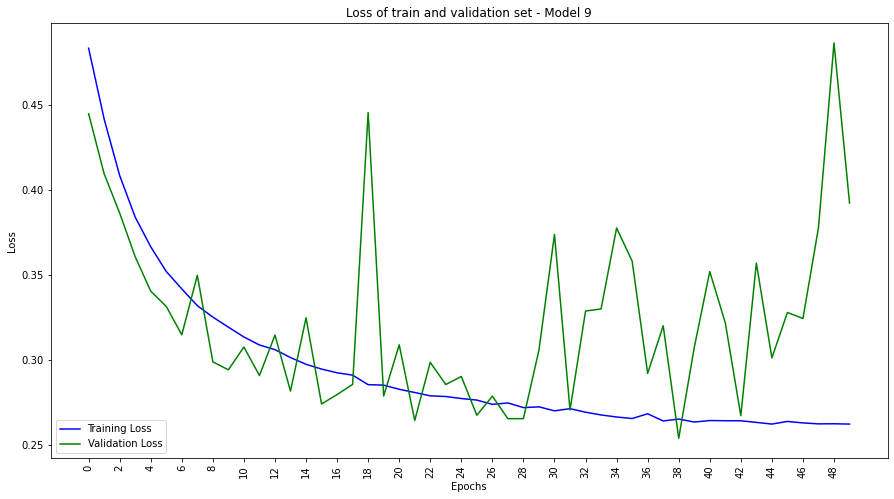

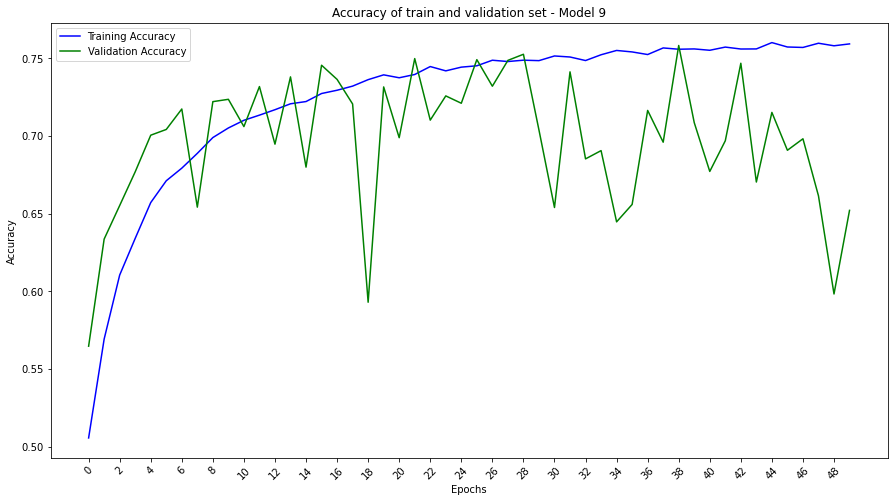

In [67]:
models['model_9'] = model
models['model_9_history'] = history

plot_loss('model_9_history', 'Model 9')
plot_accuracy('model_9_history', 'Model 9')

In [68]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)

In [69]:
record_results('Model 9', 'SMOTE, no data augmentation, no dropout')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                                      Model 3  \
Model Type               Previous model architecture with data augmentation and class weights   
Sample size                                                                                 1   
Epochs                                                                                     20   
Validation set Accuracy                                                              0.640693   
Test set Accuracy                                                                    0.629121   
Validation set F1                                                                    0.388973   
Test set F1                                                                          0.372987   
Training Time                                                                         121.472   

                                                                      Model 4  \
Model Type               Data augmentation without manually set class weights   
Sample size                                                                 1   
Epochs                                                                     20   
Validation set Accuracy                                              0.680519   
Test set Accuracy                                                    0.672754   
Validation set F1                                                    0.348477   
Test set F1                                                           0.34481   
Training Time                                                         120.403   

                                                               Model 5  \
Model Type               Data augmentation using BalancedDataGenerator   
Sample size                                                          1   
Epochs                                                              20   
Validation set Accuracy                                       0.621299   
Test set Accuracy                                             0.617081   
Validation set F1                                             0.403851   
Test set F1                                                   0.406119   
Training Time                                                  199.156   

                                                                                  Model 6  \
Model Type               Random UnderSampling to balance the data with Data Augmentation.   
Sample size                                                                             1   
Epochs                                                                                 20   
Validation set Accuracy                                                          0.603983   
Test set Accuracy                                         

Smote has outperformed the undersampled data, giving us the highest F1 score we have seen for the test set. But, training was *extremely* slow.

## Sequential Input

In order to give the model a better chance of capturing the direction of the rocket in motion, I will stack images together to create sequential input to train on. I have decided to stack three images at a time. 

In [71]:
num_classes = 4
img_height, img_width = 32, 32
input_shape = (32, 32, 3)
# Initialise arrays for data storage
X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.float)


# generate filenames from the data folder and do sampling
image_filenames = [train_data_dir+i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset
#print(image_filenames)

##uncomment to sample
#image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

#     # Create a data array for image data
count = len(image_filenames)
X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
i = 0
while i < len(image_filenames):
    # Low the images and resize them
    images = []
    for j in range(0, 3):
        if i+j < len(image_filenames):
            image = cv2.imread(image_filenames[i+j], cv2.IMREAD_GRAYSCALE)
        else:
            image = cv2.imread(image_filenames[-1], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
 #       image = image.reshape(32, 32, 1)
        images.append(image)
    
    stack = np.stack(images, axis = 0)
    stack = stack.reshape(32, 32, 3)
    X_data_part[i] = stack
    X_data_part[i] = X_data_part[i]/255
    
#     print(image_file[-6])
    # Add label to label array
    if i + j < len(image_filenames):
        target = int(image_filenames[i+j][-6])
    else:
        target - int(image_filenames[-1][-6])
    y_data = np.append(y_data, target)
    i += 1
    
print('Processed {} images'.format(i+1))
    
# Append the part to the overall data array
X_data = np.append(X_data, X_data_part, axis=0)
    
print("Data shape: {}".format(X_data.shape))
print(X_data_part[i-1].shape)

Processed 41252 images
Data shape: (41251, 32, 32, 3)
(32, 32, 3)


In [72]:
# Perfrom split to train, validation, test
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

# Perfrom split to train, validation, test
X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)

In [73]:
y_train_wide = to_categorical(y_train, num_classes)
y_test_wide = to_categorical(y_test, num_classes)
y_valid_wide = to_categorical(y_valid, num_classes)

In [74]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(3, 3),
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3),
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=84, activation='relu'))

model.add(Dense(units=4, activation = 'softmax'))

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_9 (Dense)              (None, 84)               

In [76]:
epochs = 20
# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_model_10.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()
history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])
end_time = time.time()
model.load_weights(best_weights_filepath)

Epoch 1/20
145/145 [==============================] - 4s 26ms/step - loss: 0.4043 - accuracy: 0.5698 - val_loss: 0.4275 - val_accuracy: 0.5242
Epoch 2/20
145/145 [==============================] - 4s 27ms/step - loss: 0.3906 - accuracy: 0.6224 - val_loss: 0.3889 - val_accuracy: 0.6433
Epoch 3/20
145/145 [==============================] - 4s 30ms/step - loss: 0.3840 - accuracy: 0.6350 - val_loss: 0.3790 - val_accuracy: 0.6457
Epoch 4/20
145/145 [==============================] - 5s 33ms/step - loss: 0.3784 - accuracy: 0.6475 - val_loss: 0.3752 - val_accuracy: 0.6584
Epoch 5/20
145/145 [==============================] - 5s 37ms/step - loss: 0.3741 - accuracy: 0.6552 - val_loss: 0.3711 - val_accuracy: 0.6660
Epoch 6/20
145/145 [==============================] - 5s 38ms/step - loss: 0.3694 - accuracy: 0.6585 - val_loss: 0.3702 - val_accuracy: 0.6680
Epoch 7/20
145/145 [==============================] - 5s 35ms/step - loss: 0.3650 - accuracy: 0.6634 - val_loss: 0.3751 - val_accuracy: 0.6552

In [77]:
model.save("cnn_sequential.mod")

INFO:tensorflow:Assets written to: cnn_sequential.mod/assets


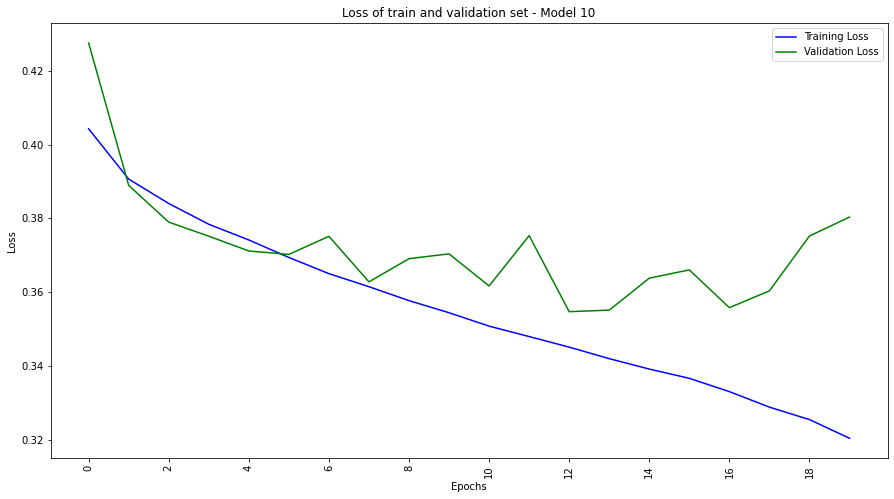

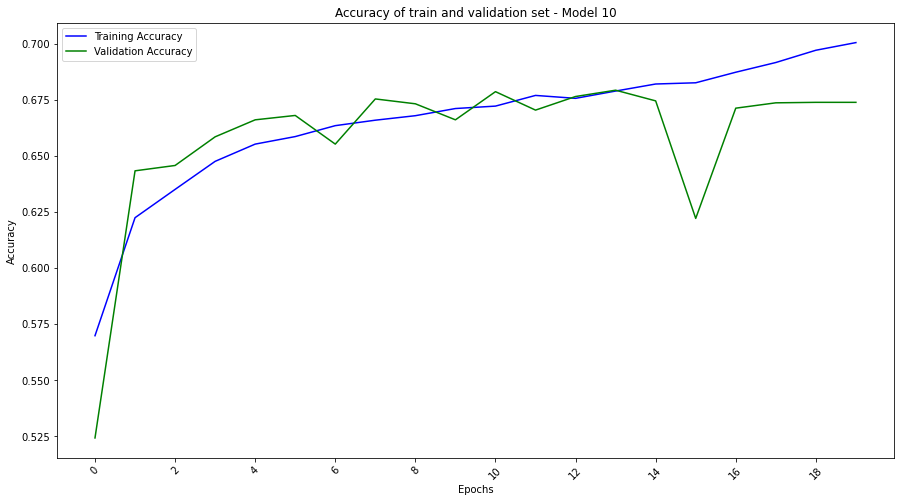

In [78]:
models['model_10'] = model
models['model_10_history'] = history

plot_loss('model_10_history', 'Model 10')
plot_accuracy('model_10_history', 'Model 10')

In [79]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)

In [80]:
record_results('Model 10', 'Sequential, no data augmentation, no dropout')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                                      Model 3  \
Model Type               Previous model architecture with data augmentation and class weights   
Sample size                                                                                 1   
Epochs                                                                                     20   
Validation set Accuracy                                                              0.640693   
Test set Accuracy                                                                    0.629121   
Validation set F1                                                                    0.388973   
Test set F1                                                                          0.372987   
Training Time                                                                         121.472   

                                                                      Model 4  \
Model Type               Data augmentation without manually set class weights   
Sample size                                                                 1   
Epochs                                                                     20   
Validation set Accuracy                                              0.680519   
Test set Accuracy                                                    0.672754   
Validation set F1                                                    0.348477   
Test set F1                                                           0.34481   
Training Time                                                         120.403   

                                                               Model 5  \
Model Type               Data augmentation using BalancedDataGenerator   
Sample size                                                          1   
Epochs                                                              20   
Validation set Accuracy                                       0.621299   
Test set Accuracy                                             0.617081   
Validation set F1                                             0.403851   
Test set F1                                                   0.406119   
Training Time                                                  199.156   

                                                                                  Model 6  \
Model Type               Random UnderSampling to balance the data with Data Augmentation.   
Sample size                                                                             1   
Epochs                                                                                 20   
Validation set Accuracy                                                          0.603983   
Test set Accuracy                                         

Although the test set accuracy is the highest we've seen, the F1 scores are low. The sequential input is not alleviating bias.

### Sequential with Smote

In order to hopefully raise F1 scores, we will oversample the sequential input to balance the dataset.

In [81]:
sm = SMOTE(random_state=0)
X_train_smo, y_train_smo = sm.fit_sample(X_train.reshape(len(X_train), math.prod(input_shape)), y_train)
X_train_smo, y_train_smo = shuffle(X_train_smo, y_train_smo)
X_train_smo = X_train_smo.reshape(len(X_train_smo), input_shape[0], input_shape[1], input_shape[2])
y_train_smo_wide = tensorflow.keras.utils.to_categorical(y_train_smo, num_classes)

In [82]:
# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_model_11.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()
history = model.fit(X_train_smo, y_train_smo_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])
end_time = time.time()
model.load_weights(best_weights_filepath)

Epoch 1/20
271/271 [==============================] - 5s 20ms/step - loss: 0.4464 - accuracy: 0.5566 - val_loss: 0.4717 - val_accuracy: 0.5155
Epoch 2/20
271/271 [==============================] - 6s 20ms/step - loss: 0.3948 - accuracy: 0.6274 - val_loss: 0.4695 - val_accuracy: 0.5264
Epoch 3/20
271/271 [==============================] - 6s 20ms/step - loss: 0.3595 - accuracy: 0.6669 - val_loss: 0.3592 - val_accuracy: 0.6555
Epoch 4/20
271/271 [==============================] - 6s 20ms/step - loss: 0.3271 - accuracy: 0.7025 - val_loss: 0.3142 - val_accuracy: 0.7125
Epoch 5/20
271/271 [==============================] - 6s 21ms/step - loss: 0.2988 - accuracy: 0.7275 - val_loss: 0.3703 - val_accuracy: 0.6619
Epoch 6/20
271/271 [==============================] - 6s 21ms/step - loss: 0.2765 - accuracy: 0.7497 - val_loss: 0.3192 - val_accuracy: 0.6887
Epoch 7/20
271/271 [==============================] - 6s 21ms/step - loss: 0.2534 - accuracy: 0.7705 - val_loss: 0.2704 - val_accuracy: 0.7465

In [83]:
model.save("cnn_balanced_sequential.mod")

INFO:tensorflow:Assets written to: cnn_balanced_sequential.mod/assets


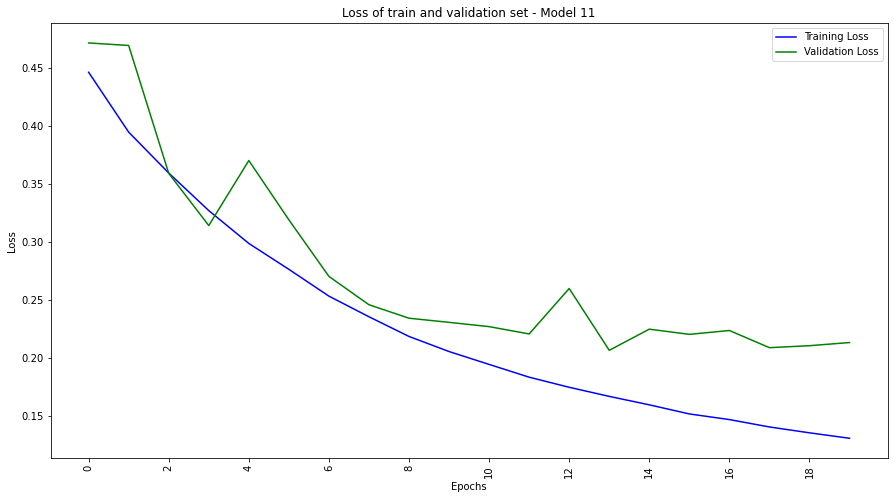

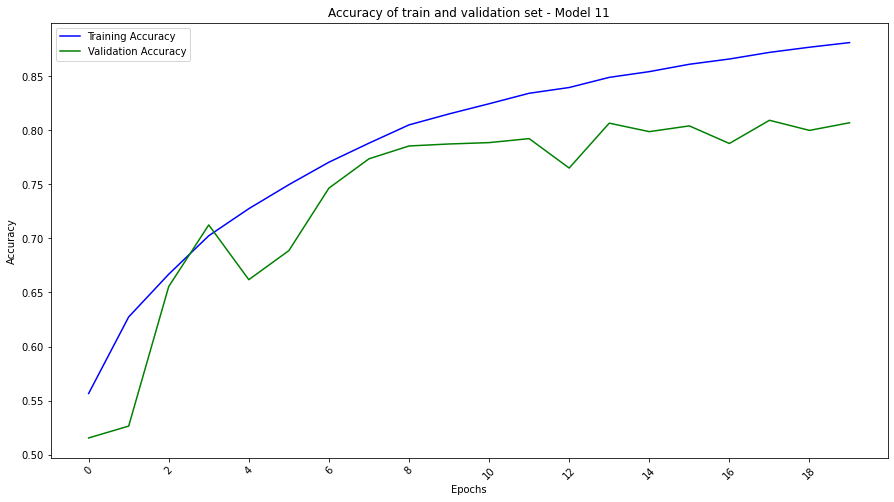

In [84]:
models['model_11'] = model
models['model_11_history'] = history

plot_loss('model_11_history', 'Model 11')
plot_accuracy('model_11_history', 'Model 11')

In [85]:
eval_v = metrics.classification_report(y_valid, model.predict_classes(X_valid), output_dict=True)
eval_t = metrics.classification_report(y_test, model.predict_classes(X_test), output_dict=True)

In [86]:
record_results('Model 11', 'Sequential, with SMOTE')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                                      Model 3  \
Model Type               Previous model architecture with data augmentation and class weights   
Sample size                                                                                 1   
Epochs                                                                                     20   
Validation set Accuracy                                                              0.640693   
Test set Accuracy                                                                    0.629121   
Validation set F1                                                                    0.388973   
Test set F1                                                                          0.372987   
Training Time                                                                         121.472   

                                                                      Model 4  \
Model Type               Data augmentation without manually set class weights   
Sample size                                                                 1   
Epochs                                                                     20   
Validation set Accuracy                                              0.680519   
Test set Accuracy                                                    0.672754   
Validation set F1                                                    0.348477   
Test set F1                                                           0.34481   
Training Time                                                         120.403   

                                                               Model 5  \
Model Type               Data augmentation using BalancedDataGenerator   
Sample size                                                          1   
Epochs                                                              20   
Validation set Accuracy                                       0.621299   
Test set Accuracy                                             0.617081   
Validation set F1                                             0.403851   
Test set F1                                                   0.406119   
Training Time                                                  199.156   

                                                                                  Model 6  \
Model Type               Random UnderSampling to balance the data with Data Augmentation.   
Sample size                                                                             1   
Epochs                                                                                 20   
Validation set Accuracy                                                          0.603983   
Test set Accuracy                                         

Results are disappointing. There has been a small bump in the F1 scores, but they are still lower than previous models with single frame input.

## Pre-trained VGG

Given the simplicity of the images we are presenting to the network, a pre-trained model is probably overkill, but out of curiosity I decided to try it out.

In [88]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model

# build the VGG16 network
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape = input_shape)
display(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

None

In [89]:
vgg16_last_layer = vgg16_model.output

# build a classifier model to put on top of the VGG16 model
x1 = Flatten()(vgg16_last_layer)
x2 = Dense(256, activation='relu')(x1)
x3 = Dropout(0.5)(x2)
final_layer = Dense(num_classes, activation = 'softmax')(x3)

# Assemble the full model out of both parts
full_model = Model(vgg16_model.input, final_layer)

# moving over weights from a pre-trained smaller model specifically for our problem might help rather than random initialisation.
#top_weights_filepath = './best_weights_notebook22.hdf5'
#old_model = keras.models.load_model(top_weights_filepath)
#full_model.layers[-1].set_weights(old_model.layers[-1].get_weights())

# set the first 17 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in vgg16_model.layers:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
full_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [100]:
epochs = 20
# Set up the callback to save the best model based on validaion data - notebook 2.2 needs to be run first.
best_weights_filepath = './best_weights_model_12.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)
start_time = time.time()
history = full_model.fit(X_train_smo, y_train_smo_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])
end_time = time.time()


Epoch 1/20
271/271 [==============================] - 66s 242ms/step - loss: 0.5237 - accuracy: 0.3947 - val_loss: 0.5165 - val_accuracy: 0.4188
Epoch 2/20
271/271 [==============================] - 67s 247ms/step - loss: 0.5224 - accuracy: 0.4005 - val_loss: 0.5149 - val_accuracy: 0.4219
Epoch 3/20
271/271 [==============================] - 66s 245ms/step - loss: 0.5206 - accuracy: 0.4032 - val_loss: 0.5132 - val_accuracy: 0.4290
Epoch 4/20
271/271 [==============================] - 67s 247ms/step - loss: 0.5194 - accuracy: 0.4054 - val_loss: 0.5149 - val_accuracy: 0.4190
Epoch 5/20
271/271 [==============================] - 67s 248ms/step - loss: 0.5188 - accuracy: 0.4044 - val_loss: 0.5114 - val_accuracy: 0.4255
Epoch 6/20
271/271 [==============================] - 69s 253ms/step - loss: 0.5170 - accuracy: 0.4127 - val_loss: 0.5088 - val_accuracy: 0.4332
Epoch 7/20
271/271 [==============================] - 68s 252ms/step - loss: 0.5153 - accuracy: 0.4145 - val_loss: 0.5081 - val_ac

In [101]:
full_model.load_weights(best_weights_filepath)

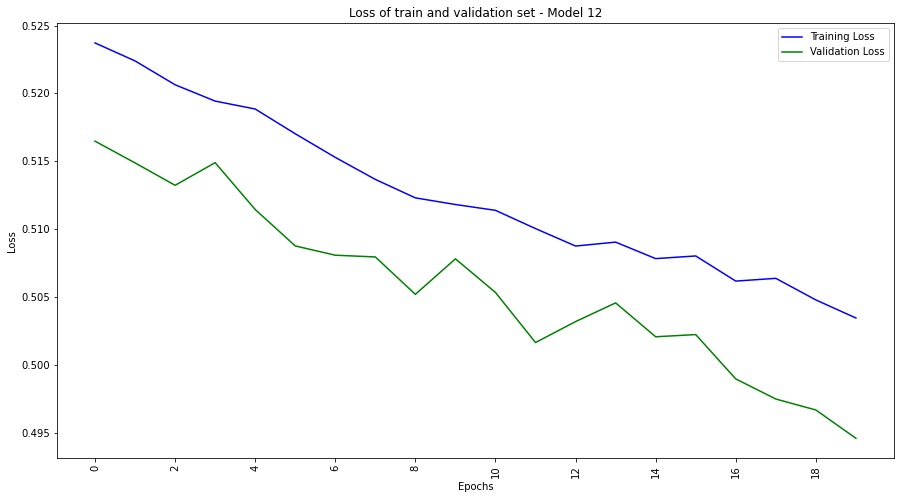

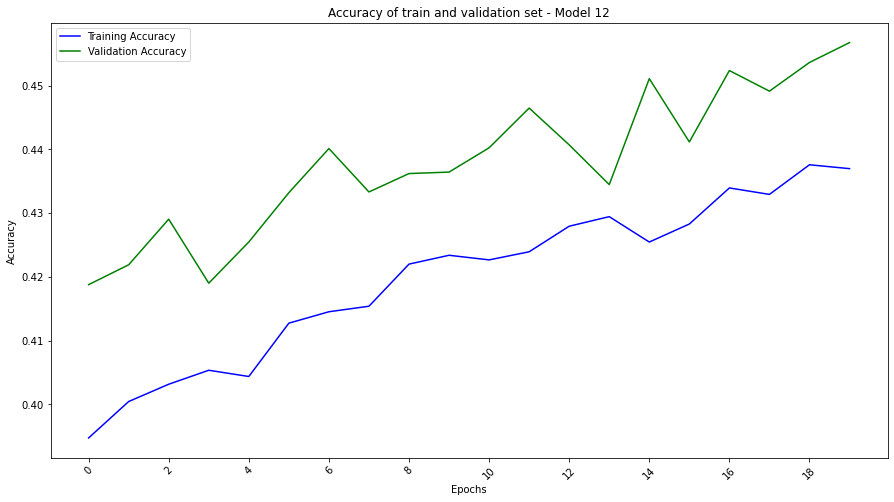

In [102]:
models['model_12'] = full_model
models['model_12_history'] = history

plot_loss('model_12_history', 'Model 12')
plot_accuracy('model_12_history', 'Model 12')

In [103]:
eval_v = metrics.classification_report(y_valid, np.argmax(full_model.predict(X_valid), axis=-1), output_dict=True)
eval_t = metrics.classification_report(y_test, np.argmax(full_model.predict(X_test), axis=-1), output_dict=True)

## CNN Model Comparisons

In [104]:
record_results('Model 12', 'Sequential, with SMOTE and VGA pre-trained')
CNN_results

Model 1  \
Model Type               Unmodified input data and 1 conv layer   
Sample size                                                 0.1   
Epochs                                                       20   
Validation set Accuracy                                0.624567   
Test set Accuracy                                      0.662359   
Validation set F1                                      0.391548   
Test set F1                                             0.45446   
Training Time                                           120.844   

                                                              Model 2  \
Model Type               32*32 resized and normalised images on LeNet   
Sample size                                                         1   
Epochs                                                             20   
Validation set Accuracy                                      0.695065   
Test set Accuracy                                             0.68948   
Validation set F1                                            0.411632   
Test set F1                                                  0.398209   
Training Time                                                 44.9329   

                                                                                      Model 3  \
Model Type               Previous model architecture with data augmentation and class weights   
Sample size                                                                                 1   
Epochs                                                                                     20   
Validation set Accuracy                                                              0.640693   
Test set Accuracy                                                                    0.629121   
Validation set F1                                                                    0.388973   
Test set F1                                                                          0.372987   
Training Time                                                                         121.472   

                                                                      Model 4  \
Model Type               Data augmentation without manually set class weights   
Sample size                                                                 1   
Epochs                                                                     20   
Validation set Accuracy                                              0.680519   
Test set Accuracy                                                    0.672754   
Validation set F1                                                    0.348477   
Test set F1                                                           0.34481   
Training Time                                                         120.403   

                                                               Model 5  \
Model Type               Data augmentation using BalancedDataGenerator   
Sample size                                                          1   
Epochs                                                              20   
Validation set Accuracy                                       0.621299   
Test set Accuracy                                             0.617081   
Validation set F1                                             0.403851   
Test set F1                                                   0.406119   
Training Time                                                  199.156   

                                                                                  Model 6  \
Model Type               Random UnderSampling to balance the data with Data Augmentation.   
Sample size                                                                             1   
Epochs                                                                                 20   
Validation set Accuracy                                                          0.603983   
Test set Accuracy                                         

The pretrained model actually dis-improved performance quite a bit, and it was very slow.

There was no definitive winner persay, but I think model 9 presents the best rounded model. It has a fair accuracy score (above 50) and F1 scores in the higher end of what we have seen. It also, incidentally, had the longest training time. I have decided to use this to compare against my reinforcement learning model.

In [334]:
best_weights_filepath = './best_weights_model_9.hdf5'
model.load_weights(best_weights_filepath)

In [335]:
model.save("cnn_choice.mod")

INFO:tensorflow:Assets written to: cnn_choice.mod/assets


# Reinforcement Learning

In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import gym
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# We use keras-rl2 a reinforcement learning package that builds on top of keras and openAI gym (pip install keras-rl2) 
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import LunarEirLander
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import time

In [16]:
env = LunarEirLander.LunarEirLander()
nb_actions = env.action_space.n

In [66]:
rl = pd.DataFrame(index=['Window Length', 'Architecture', 'Training Steps', 'Memory Limit', 'Log Interval', 'Average Reward'])

In [97]:
# Structures to store our trained models and their weights
weights = []
models = []

## RL baseline

In establishing a baseline, I decided to use a relatively simple model architecture, and let it run for a while. The memory limit is 50,000, while our step limit is 5,000,000. This is a big discrepency, but I thought it would be an interesting place to start, and at the end of this long training time, it should be clear whether the memory limit is sufficient or not. 

In [67]:
rl['Model 1'] = [1, '128/64/32', 5000000, 50000, 500, None]

In [252]:
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(128)) 
model.add(Activation('relu'))
model.add(Dense(64)) 
model.add(Activation('relu'))
model.add(Dense(32)) 
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_36 (Flatten)         (None, 8)                 0         
_________________________________________________________________
dense_144 (Dense)            (None, 128)               1152      
_________________________________________________________________
activation_144 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_145 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_146 (Dense)            (None, 32)                2080      
_________________________________________________________________
activation_146 (Activation)  (None, 32)              

In [253]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=30,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [115]:
# weights_filename = f'dqn_lunar_weights.h5f'
checkpoint_weights_filename = 'dqn_lunar_weights_{step}.h5f'
log_filename = f'dqn_lunar_log.json'
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
start_time = time.time()
history = dqn.fit(env, callbacks=callbacks, nb_steps=5000000, log_interval=500)
end_time = time.time()

Training for 5000000 steps ...
Interval 1 (0 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.2968
2 episodes - episode_reward: -64.423 [-106.174, -22.672] - loss: 11.332 - mae: 45.887 - mean_q: 58.191

Interval 2 (500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.1022
2 episodes - episode_reward: -3.217 [-199.287, 192.853] - loss: 11.998 - mae: 46.349 - mean_q: 58.936

Interval 3 (1000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.1628
1 episodes - episode_reward: -168.263 [-168.263, -168.263] - loss: 12.304 - mae: 46.852 - mean_q: 59.658

Interval 4 (1500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.5485
3 episodes - episode_reward: 99.399 [-106.636, 293.945] - loss: 13.118 - mae: 47.224 - mean_q: 59.815

Interval 5 (2000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.7257
3 episodes - episode_re

500/500 [==============================] - 4s 8ms/step - reward: -0.2075
Interval 45 (22000 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: -0.2146
Interval 46 (22500 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -0.1720
Interval 47 (23000 steps performed)
500/500 [==============================] - 5s 11ms/step - reward: -0.1999
Interval 48 (23500 steps performed)
500/500 [==============================] - 6s 12ms/step - reward: -0.1903
Interval 49 (24000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0257
1 episodes - episode_reward: -850.114 [-850.114, -850.114] - loss: 16.909 - mae: 52.839 - mean_q: 66.855

Interval 50 (24500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.0743
2 episodes - episode_reward: 23.733 [-159.537, 207.003] - loss: 15.484 - mae: 53.073 - mean_q: 67.108

Interval 51 (25000 steps performed)
500/500 [=================

500/500 [==============================] - 2s 5ms/step - reward: -1.9594
4 episodes - episode_reward: -227.831 [-307.418, -142.439] - loss: 18.571 - mae: 39.023 - mean_q: 42.151

Interval 94 (46500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.5543
2 episodes - episode_reward: -439.596 [-493.779, -385.413] - loss: 22.225 - mae: 38.249 - mean_q: 41.044

Interval 95 (47000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.1045
1 episodes - episode_reward: -454.927 [-454.927, -454.927] - loss: 15.778 - mae: 37.959 - mean_q: 39.572

Interval 96 (47500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.6416
1 episodes - episode_reward: -300.482 [-300.482, -300.482] - loss: 19.015 - mae: 37.805 - mean_q: 38.990

Interval 97 (48000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.6900
2 episodes - episode_reward: -462.497 [-714.026, -210.968] - loss: 

500/500 [==============================] - 3s 6ms/step - reward: -0.1944
Interval 135 (67000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2702
1 episodes - episode_reward: -328.331 [-328.331, -328.331] - loss: 49.332 - mae: 109.357 - mean_q: 132.037

Interval 136 (67500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.9001
2 episodes - episode_reward: -215.463 [-272.976, -157.949] - loss: 27.635 - mae: 108.890 - mean_q: 134.124

Interval 137 (68000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.7609
1 episodes - episode_reward: -284.610 [-284.610, -284.610] - loss: 40.232 - mae: 107.437 - mean_q: 131.593

Interval 138 (68500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.2861
2 episodes - episode_reward: -141.371 [-148.840, -133.902] - loss: 30.820 - mae: 107.506 - mean_q: 131.947

Interval 139 (69000 steps performed)
500/500 [=========

500/500 [==============================] - 2s 4ms/step - reward: -1.2334
1 episodes - episode_reward: -631.935 [-631.935, -631.935] - loss: 203.389 - mae: 153.499 - mean_q: 178.785

Interval 218 (108500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.9967
2 episodes - episode_reward: -309.208 [-326.093, -292.322] - loss: 139.735 - mae: 155.866 - mean_q: 182.808

Interval 219 (109000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.9324
2 episodes - episode_reward: -153.861 [-275.548, -32.174] - loss: 163.772 - mae: 157.413 - mean_q: 185.670

Interval 220 (109500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.7726
2 episodes - episode_reward: -303.513 [-471.106, -135.921] - loss: 160.507 - mae: 159.198 - mean_q: 186.973

Interval 221 (110000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.8223
1 episodes - episode_reward: -297.666 [-297.666,

3 episodes - episode_reward: -294.272 [-392.955, -235.869] - loss: 89.187 - mae: 122.736 - mean_q: 128.599

Interval 259 (129000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.0004
1 episodes - episode_reward: -328.188 [-328.188, -328.188] - loss: 85.993 - mae: 121.510 - mean_q: 126.193

Interval 260 (129500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.6770
4 episodes - episode_reward: -277.110 [-394.092, -157.843] - loss: 90.058 - mae: 118.647 - mean_q: 122.929

Interval 261 (130000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.4095
2 episodes - episode_reward: -272.516 [-415.460, -129.572] - loss: 73.366 - mae: 115.615 - mean_q: 117.163

Interval 262 (130500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.0144
4 episodes - episode_reward: -265.187 [-459.032, -100.000] - loss: 88.089 - mae: 112.980 - mean_q: 112.024

Interval 263 (13

500/500 [==============================] - 3s 5ms/step - reward: -0.1134
Interval 339 (169000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.0774
Interval 340 (169500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.0457
Interval 341 (170000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1958
Interval 342 (170500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0890
Interval 343 (171000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.4501
2 episodes - episode_reward: -228.145 [-301.298, -154.991] - loss: 252.977 - mae: 295.508 - mean_q: 373.929

Interval 344 (171500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.0428
Interval 345 (172000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0298
Interval 346 (172500 steps performed)
500

500/500 [==============================] - 2s 4ms/step - reward: -4.1870
1 episodes - episode_reward: -2442.537 [-2442.537, -2442.537] - loss: 176.612 - mae: 225.570 - mean_q: 290.360

Interval 444 (221500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0052
3 episodes - episode_reward: -1029.830 [-2625.452, -159.314] - loss: 115.392 - mae: 222.086 - mean_q: 285.786

Interval 445 (222000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.1834
1 episodes - episode_reward: -370.306 [-370.306, -370.306] - loss: 94.519 - mae: 214.533 - mean_q: 275.270

Interval 446 (222500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.4506
2 episodes - episode_reward: -533.022 [-552.775, -513.269] - loss: 188.477 - mae: 208.494 - mean_q: 266.267

Interval 447 (223000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2119
3 episodes - episode_reward: -387.079 [-576

500/500 [==============================] - 4s 7ms/step - reward: -0.4508
Interval 543 (271000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.4607
Interval 544 (271500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.8515
1 episodes - episode_reward: -2054.398 [-2054.398, -2054.398] - loss: 107.955 - mae: 262.060 - mean_q: 337.160

Interval 545 (272000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.8514
3 episodes - episode_reward: -289.625 [-464.368, -109.532] - loss: 107.968 - mae: 262.812 - mean_q: 337.983

Interval 546 (272500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.5902
2 episodes - episode_reward: -260.258 [-386.469, -134.047] - loss: 126.847 - mae: 264.296 - mean_q: 339.309

Interval 547 (273000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.5739
1 episodes - episode_reward: -313.123 [-31

500/500 [==============================] - 3s 5ms/step - reward: -2.1905
4 episodes - episode_reward: -272.606 [-354.752, -195.628] - loss: 1602.448 - mae: 1173.583 - mean_q: 1607.120

Interval 595 (297000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.4752
4 episodes - episode_reward: -328.798 [-515.106, -186.900] - loss: 2030.512 - mae: 1285.401 - mean_q: 1761.681

Interval 596 (297500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.7682
1 episodes - episode_reward: -383.364 [-383.364, -383.364] - loss: 2239.628 - mae: 1430.310 - mean_q: 1960.804

Interval 597 (298000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.8790
1 episodes - episode_reward: -396.968 [-396.968, -396.968] - loss: 2262.638 - mae: 1551.479 - mean_q: 2124.639

Interval 598 (298500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.9225
1 episodes - episode_reward: -342.3

500/500 [==============================] - 2s 5ms/step - reward: -0.7229
Interval 685 (342000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1836
Interval 686 (342500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2328
Interval 687 (343000 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: -0.7991
Interval 688 (343500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -4.0629
1 episodes - episode_reward: -2564.468 [-2564.468, -2564.468] - loss: 2948.823 - mae: 1786.461 - mean_q: 2407.247

Interval 689 (344000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.1647
1 episodes - episode_reward: -688.051 [-688.051, -688.051] - loss: 3625.158 - mae: 1744.683 - mean_q: 2349.535

Interval 690 (344500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.3112
2 episodes - episode_reward: -198.0

500/500 [==============================] - 2s 5ms/step - reward: -1.1132
Interval 783 (391000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8591
1 episodes - episode_reward: -1460.548 [-1460.548, -1460.548] - loss: 450.650 - mae: 497.209 - mean_q: 666.671

Interval 784 (391500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.1592
1 episodes - episode_reward: -1401.552 [-1401.552, -1401.552] - loss: 446.194 - mae: 480.606 - mean_q: 643.998

Interval 785 (392000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.6231
Interval 786 (392500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.3491
3 episodes - episode_reward: -433.403 [-1068.052, -98.468] - loss: 385.690 - mae: 453.065 - mean_q: 607.607

Interval 787 (393000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.8240
1 episodes - episode_reward: -696.115 [

500/500 [==============================] - 2s 5ms/step - reward: -1.1864
1 episodes - episode_reward: -511.824 [-511.824, -511.824] - loss: 104.800 - mae: 206.615 - mean_q: 274.499

Interval 837 (418000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.3396
2 episodes - episode_reward: -366.750 [-500.766, -232.735] - loss: 83.910 - mae: 202.398 - mean_q: 268.977

Interval 838 (418500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.6478
3 episodes - episode_reward: -138.745 [-195.671, -107.657] - loss: 89.927 - mae: 198.743 - mean_q: 263.760

Interval 839 (419000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1213
Interval 840 (419500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1601
Interval 841 (420000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1943
Interval 842 (420500 steps performed)
500/500 [

500/500 [==============================] - 5s 10ms/step - reward: -1.0970
2 episodes - episode_reward: -339.439 [-345.428, -333.451] - loss: 15.356 - mae: 31.788 - mean_q: 40.491

Interval 935 (467000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.6110
3 episodes - episode_reward: -301.433 [-357.482, -196.736] - loss: 16.763 - mae: 31.163 - mean_q: 39.525

Interval 936 (467500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.6618
3 episodes - episode_reward: -106.090 [-141.886, -76.383] - loss: 14.483 - mae: 30.578 - mean_q: 38.566

Interval 937 (468000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.6955
2 episodes - episode_reward: -299.704 [-466.049, -133.359] - loss: 18.889 - mae: 30.361 - mean_q: 38.200

Interval 938 (468500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.1931
1 episodes - episode_reward: -320.770 [-320.770, -320.770] 

500/500 [==============================] - 3s 7ms/step - reward: -0.1567
Interval 1036 (517500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.2005
Interval 1037 (518000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1706
Interval 1038 (518500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1757
Interval 1039 (519000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2176
Interval 1040 (519500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.2351
Interval 1041 (520000 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -0.0619
Interval 1042 (520500 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: 0.0210
Interval 1043 (521000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: 0.0049
2 episodes - episode_reward: -37

500/500 [==============================] - 2s 4ms/step - reward: -1.9911
5 episodes - episode_reward: -161.925 [-203.340, -100.000] - loss: 15.942 - mae: 31.764 - mean_q: 34.209

Interval 1124 (561500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8958
8 episodes - episode_reward: -197.678 [-293.201, -100.000] - loss: 13.043 - mae: 32.183 - mean_q: 34.749

Interval 1125 (562000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: 0.0883
2 episodes - episode_reward: 24.608 [-120.029, 169.246] - loss: 14.434 - mae: 32.163 - mean_q: 34.210

Interval 1126 (562500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.9411
3 episodes - episode_reward: -180.413 [-210.546, -134.547] - loss: 13.824 - mae: 32.379 - mean_q: 34.422

Interval 1127 (563000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.2960
1 episodes - episode_reward: -117.121 [-117.121, -117.121] 

500/500 [==============================] - 2s 5ms/step - reward: -1.1343
3 episodes - episode_reward: -148.802 [-337.894, 228.193] - loss: 14.694 - mae: 35.043 - mean_q: 38.311

Interval 1169 (584000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: 0.3222
1 episodes - episode_reward: 154.822 [154.822, 154.822] - loss: 11.531 - mae: 35.053 - mean_q: 38.627

Interval 1170 (584500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: 0.4073
1 episodes - episode_reward: 182.154 [182.154, 182.154] - loss: 11.810 - mae: 34.881 - mean_q: 38.398

Interval 1171 (585000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.1542
Interval 1172 (585500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.7004
4 episodes - episode_reward: -198.811 [-433.253, 198.781] - loss: 11.730 - mae: 35.436 - mean_q: 39.830

Interval 1173 (586000 steps performed)
500/500 [==================

500/500 [==============================] - 2s 4ms/step - reward: -0.7091
2 episodes - episode_reward: -185.888 [-245.970, -125.806] - loss: 11.626 - mae: 35.398 - mean_q: 40.879

Interval 1211 (605000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9035
6 episodes - episode_reward: -232.805 [-290.713, -192.741] - loss: 11.676 - mae: 35.328 - mean_q: 40.341

Interval 1212 (605500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.9484
4 episodes - episode_reward: -155.124 [-239.978, -65.374] - loss: 11.564 - mae: 35.296 - mean_q: 39.923

Interval 1213 (606000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.1154
1 episodes - episode_reward: 137.546 [137.546, 137.546] - loss: 10.921 - mae: 35.625 - mean_q: 39.977

Interval 1214 (606500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.1462
Interval 1215 (607000 steps performed)
500/500 [=============

500/500 [==============================] - 2s 4ms/step - reward: -0.2363
2 episodes - episode_reward: -77.721 [-93.202, -62.240] - loss: 11.354 - mae: 34.438 - mean_q: 34.008

Interval 1251 (625000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8413
8 episodes - episode_reward: -167.777 [-295.837, -49.362] - loss: 10.482 - mae: 34.505 - mean_q: 33.728

Interval 1252 (625500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.1646
Interval 1253 (626000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2396
5 episodes - episode_reward: -222.129 [-414.485, -27.501] - loss: 12.860 - mae: 34.697 - mean_q: 33.772

Interval 1254 (626500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.0577
Interval 1255 (627000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.0481
1 episodes - episode_reward: 177.349 [177.349, 177.349] 

500/500 [==============================] - 3s 6ms/step - reward: 0.3513
1 episodes - episode_reward: 161.357 [161.357, 161.357] - loss: 8.768 - mae: 38.424 - mean_q: 38.088

Interval 1343 (671000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.2244
1 episodes - episode_reward: 155.058 [155.058, 155.058] - loss: 9.080 - mae: 38.441 - mean_q: 38.000

Interval 1344 (671500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -5.4348
7 episodes - episode_reward: -386.541 [-1004.495, -143.649] - loss: 9.592 - mae: 38.427 - mean_q: 37.453

Interval 1345 (672000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: 0.1364
Interval 1346 (672500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.2942
3 episodes - episode_reward: -181.979 [-411.657, 194.777] - loss: 7.851 - mae: 38.412 - mean_q: 37.368

Interval 1347 (673000 steps performed)
500/500 [====================

500/500 [==============================] - 2s 5ms/step - reward: 0.3140
1 episodes - episode_reward: 194.745 [194.745, 194.745] - loss: 6.930 - mae: 38.043 - mean_q: 38.713

Interval 1428 (713500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.3309
1 episodes - episode_reward: 158.542 [158.542, 158.542] - loss: 6.557 - mae: 37.834 - mean_q: 38.490

Interval 1429 (714000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0581
Interval 1430 (714500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3618
1 episodes - episode_reward: 193.916 [193.916, 193.916] - loss: 6.330 - mae: 38.134 - mean_q: 38.954

Interval 1431 (715000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.4027
4 episodes - episode_reward: -180.143 [-472.551, 226.426] - loss: 7.475 - mae: 38.095 - mean_q: 38.407

Interval 1432 (715500 steps performed)
500/500 [=========================

500/500 [==============================] - 2s 4ms/step - reward: -0.3163
1 episodes - episode_reward: 21.906 [21.906, 21.906] - loss: 18.998 - mae: 43.070 - mean_q: 32.634

Interval 1515 (757000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.5236
2 episodes - episode_reward: -200.153 [-398.882, -1.424] - loss: 20.595 - mae: 42.817 - mean_q: 33.315

Interval 1516 (757500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.7102
1 episodes - episode_reward: -962.862 [-962.862, -962.862] - loss: 14.906 - mae: 42.674 - mean_q: 33.222

Interval 1517 (758000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.9895
2 episodes - episode_reward: -275.653 [-522.063, -29.244] - loss: 14.808 - mae: 43.386 - mean_q: 33.227

Interval 1518 (758500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: 0.4578
1 episodes - episode_reward: 245.152 [245.152, 245.152] - loss: 1

500/500 [==============================] - 2s 5ms/step - reward: 0.2904
1 episodes - episode_reward: 130.709 [130.709, 130.709] - loss: 13.059 - mae: 50.718 - mean_q: 41.802

Interval 1559 (779000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.1021
Interval 1560 (779500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.6359
1 episodes - episode_reward: -462.732 [-462.732, -462.732] - loss: 14.442 - mae: 50.899 - mean_q: 42.132

Interval 1561 (780000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: 0.3393
1 episodes - episode_reward: 267.645 [267.645, 267.645] - loss: 12.490 - mae: 50.714 - mean_q: 43.453

Interval 1562 (780500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0362
Interval 1563 (781000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.1972
1 episodes - episode_reward: 154.547 [154.547, 154.547] - l

500/500 [==============================] - 3s 6ms/step - reward: -0.0304
Interval 1603 (801000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0882
Interval 1604 (801500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.5459
2 episodes - episode_reward: -116.125 [-334.722, 102.473] - loss: 10.235 - mae: 48.827 - mean_q: 49.850

Interval 1605 (802000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.2538
2 episodes - episode_reward: -74.071 [-123.046, -25.096] - loss: 11.903 - mae: 48.893 - mean_q: 49.387

Interval 1606 (802500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.1600
Interval 1607 (803000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.6434
4 episodes - episode_reward: -202.362 [-408.104, 177.192] - loss: 10.646 - mae: 47.850 - mean_q: 48.391

Interval 1608 (803500 steps performed)
500/500 [=======

500/500 [==============================] - 2s 5ms/step - reward: -1.6971
3 episodes - episode_reward: -276.845 [-456.024, -139.806] - loss: 9.374 - mae: 39.322 - mean_q: 35.137

Interval 1646 (822500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.0160
1 episodes - episode_reward: -52.613 [-52.613, -52.613] - loss: 10.882 - mae: 39.029 - mean_q: 35.005

Interval 1647 (823000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0029
Interval 1648 (823500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0313
Interval 1649 (824000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.8840
3 episodes - episode_reward: -157.326 [-415.597, 105.389] - loss: 12.770 - mae: 38.311 - mean_q: 34.503

Interval 1650 (824500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.1067
Interval 1651 (825000 steps performed)
500/500 [=======

500/500 [==============================] - 2s 4ms/step - reward: -0.6954
3 episodes - episode_reward: -112.585 [-234.710, 17.994] - loss: 11.885 - mae: 36.391 - mean_q: 26.524

Interval 1734 (866500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.5307
2 episodes - episode_reward: -175.841 [-178.196, -173.486] - loss: 15.280 - mae: 36.581 - mean_q: 26.610

Interval 1735 (867000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.9905
5 episodes - episode_reward: -78.967 [-288.718, 194.567] - loss: 12.636 - mae: 36.505 - mean_q: 25.610

Interval 1736 (867500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.4856
2 episodes - episode_reward: -148.440 [-240.952, -55.927] - loss: 11.512 - mae: 37.088 - mean_q: 25.614

Interval 1737 (868000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.8933
2 episodes - episode_reward: -118.592 [-128.163, -109.022] -

500/500 [==============================] - 2s 4ms/step - reward: -0.8183
3 episodes - episode_reward: -248.066 [-433.917, -113.259] - loss: 21.856 - mae: 53.130 - mean_q: 43.875

Interval 1823 (911000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.1445
Interval 1824 (911500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.3275
1 episodes - episode_reward: 197.390 [197.390, 197.390] - loss: 18.990 - mae: 52.927 - mean_q: 45.716

Interval 1825 (912000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.4296
3 episodes - episode_reward: -382.770 [-761.893, -21.343] - loss: 22.108 - mae: 51.703 - mean_q: 44.498

Interval 1826 (912500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.6058
2 episodes - episode_reward: -160.041 [-164.311, -155.771] - loss: 20.765 - mae: 51.994 - mean_q: 44.113

Interval 1827 (913000 steps performed)
500/500 [=============

500/500 [==============================] - 2s 5ms/step - reward: -0.0574
Interval 1911 (955000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.0669
3 episodes - episode_reward: -191.282 [-347.616, -108.776] - loss: 17.188 - mae: 44.922 - mean_q: 22.365

Interval 1912 (955500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4575
5 episodes - episode_reward: -206.329 [-429.847, -92.341] - loss: 17.302 - mae: 44.972 - mean_q: 21.322

Interval 1913 (956000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.2668
2 episodes - episode_reward: -177.577 [-247.317, -107.838] - loss: 17.482 - mae: 45.445 - mean_q: 22.145

Interval 1914 (956500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.1112
Interval 1915 (957000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2501
Interval 1916 (957500 steps performed)
500/500 [==

500/500 [==============================] - 2s 5ms/step - reward: 0.0701
1 episodes - episode_reward: 139.101 [139.101, 139.101] - loss: 21.519 - mae: 40.838 - mean_q: 23.794

Interval 1958 (978500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.9630
1 episodes - episode_reward: -668.710 [-668.710, -668.710] - loss: 21.944 - mae: 41.231 - mean_q: 24.485

Interval 1959 (979000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.2261
2 episodes - episode_reward: 7.175 [-212.357, 226.707] - loss: 19.507 - mae: 41.887 - mean_q: 23.807

Interval 1960 (979500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.2637
1 episodes - episode_reward: -67.361 [-67.361, -67.361] - loss: 21.328 - mae: 41.891 - mean_q: 24.209

Interval 1961 (980000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.0077
1 episodes - episode_reward: -168.167 [-168.167, -168.167] - loss: 

500/500 [==============================] - 2s 4ms/step - reward: -0.2706
2 episodes - episode_reward: -86.761 [-105.277, -68.245] - loss: 58.493 - mae: 93.964 - mean_q: 81.548

Interval 2041 (1020000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.2396
2 episodes - episode_reward: -58.812 [-138.253, 20.630] - loss: 72.464 - mae: 98.219 - mean_q: 88.079

Interval 2042 (1020500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.4760
3 episodes - episode_reward: -79.272 [-118.490, -41.134] - loss: 82.944 - mae: 103.682 - mean_q: 94.681

Interval 2043 (1021000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.3964
4 episodes - episode_reward: -168.566 [-444.961, -50.477] - loss: 90.456 - mae: 108.834 - mean_q: 103.303

Interval 2044 (1021500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.9293
1 episodes - episode_reward: -513.042 [-513.042, -513.04

500/500 [==============================] - 5s 10ms/step - reward: -0.1436
Interval 2151 (1075000 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -0.1469
Interval 2152 (1075500 steps performed)
500/500 [==============================] - 5s 11ms/step - reward: -0.0940
Interval 2153 (1076000 steps performed)
500/500 [==============================] - 6s 11ms/step - reward: -0.1934
Interval 2154 (1076500 steps performed)
500/500 [==============================] - 6s 12ms/step - reward: -0.8410
1 episodes - episode_reward: -1599.160 [-1599.160, -1599.160] - loss: 23.994 - mae: 136.137 - mean_q: 171.661

Interval 2155 (1077000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.1491
Interval 2156 (1077500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1218
Interval 2157 (1078000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2921
Interval 2158 (10785

500/500 [==============================] - 3s 6ms/step - reward: -0.1534
Interval 2260 (1129500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1469
Interval 2261 (1130000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.1800
Interval 2262 (1130500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1566
Interval 2263 (1131000 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -0.1192
Interval 2264 (1131500 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: -0.1160
Interval 2265 (1132000 steps performed)
500/500 [==============================] - 5s 11ms/step - reward: -0.2411
Interval 2266 (1132500 steps performed)
500/500 [==============================] - 6s 11ms/step - reward: -0.1829
Interval 2267 (1133000 steps performed)
500/500 [==============================] - 5s 11ms/step - reward: -0.1582
Interval 2268 (1133

1 episodes - episode_reward: -90.636 [-90.636, -90.636] - loss: 63.059 - mae: 72.496 - mean_q: 85.512

Interval 2371 (1185000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.4372
3 episodes - episode_reward: -828.588 [-2225.044, -123.093] - loss: 46.047 - mae: 71.334 - mean_q: 82.673

Interval 2372 (1185500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.0116 
Interval 2373 (1186000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.0237
Interval 2374 (1186500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.1814
3 episodes - episode_reward: -33.800 [-110.695, 87.791] - loss: 51.044 - mae: 70.158 - mean_q: 81.195

Interval 2375 (1187000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.8391
1 episodes - episode_reward: -395.526 [-395.526, -395.526] - loss: 41.349 - mae: 68.238 - mean_q: 78.011

Interval 2376 (11

500/500 [==============================] - 2s 4ms/step - reward: 0.0409
1 episodes - episode_reward: -26.564 [-26.564, -26.564] - loss: 35.435 - mae: 59.305 - mean_q: 51.644

Interval 2417 (1208000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.4009
4 episodes - episode_reward: -169.250 [-336.751, -19.032] - loss: 32.974 - mae: 59.088 - mean_q: 51.352

Interval 2418 (1208500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.6199
3 episodes - episode_reward: -250.820 [-315.646, -172.801] - loss: 32.620 - mae: 58.061 - mean_q: 49.161

Interval 2419 (1209000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.6784
3 episodes - episode_reward: -306.598 [-402.237, -123.063] - loss: 33.117 - mae: 57.691 - mean_q: 48.249

Interval 2420 (1209500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.2171
1 episodes - episode_reward: -101.828 [-101.828, -101.82

500/500 [==============================] - 2s 5ms/step - reward: -0.5116
2 episodes - episode_reward: -121.451 [-187.777, -55.125] - loss: 29.969 - mae: 51.955 - mean_q: 37.055

Interval 2461 (1230000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.2438
1 episodes - episode_reward: -92.061 [-92.061, -92.061] - loss: 26.429 - mae: 51.132 - mean_q: 38.421

Interval 2462 (1230500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: 0.1114
1 episodes - episode_reward: -56.843 [-56.843, -56.843] - loss: 31.602 - mae: 51.412 - mean_q: 38.521

Interval 2463 (1231000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.2938
1 episodes - episode_reward: -65.476 [-65.476, -65.476] - loss: 28.850 - mae: 51.117 - mean_q: 38.940

Interval 2464 (1231500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.2573
1 episodes - episode_reward: -69.817 [-69.817, -69.817] - loss

500/500 [==============================] - 2s 5ms/step - reward: -0.9505
2 episodes - episode_reward: -222.521 [-469.440, 24.398] - loss: 24.891 - mae: 38.433 - mean_q: 24.190

Interval 2502 (1250500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.1223
4 episodes - episode_reward: -147.477 [-305.552, -81.313] - loss: 20.789 - mae: 37.791 - mean_q: 24.226

Interval 2503 (1251000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.6258
2 episodes - episode_reward: -146.655 [-222.105, -71.204] - loss: 19.568 - mae: 37.576 - mean_q: 24.083

Interval 2504 (1251500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.6991
3 episodes - episode_reward: -122.860 [-197.147, -73.163] - loss: 20.518 - mae: 37.725 - mean_q: 23.922

Interval 2505 (1252000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.5582
2 episodes - episode_reward: -99.683 [-134.968, -64.398]

500/500 [==============================] - 2s 5ms/step - reward: -2.4705
4 episodes - episode_reward: -321.526 [-564.478, -91.053] - loss: 22.573 - mae: 32.905 - mean_q: 15.077

Interval 2543 (1271000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.3338
1 episodes - episode_reward: -666.983 [-666.983, -666.983] - loss: 21.393 - mae: 33.497 - mean_q: 15.696

Interval 2544 (1271500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.5355
1 episodes - episode_reward: -759.122 [-759.122, -759.122] - loss: 23.983 - mae: 34.140 - mean_q: 16.113

Interval 2545 (1272000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.3502
3 episodes - episode_reward: -562.843 [-694.181, -318.747] - loss: 23.010 - mae: 34.779 - mean_q: 16.132

Interval 2546 (1272500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.1452
3 episodes - episode_reward: -326.116 [-644.917, -10

500/500 [==============================] - 2s 4ms/step - reward: -4.0420
7 episodes - episode_reward: -267.839 [-347.940, -173.882] - loss: 83.003 - mae: 86.102 - mean_q: 55.466

Interval 2621 (1310000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3837
8 episodes - episode_reward: -237.054 [-497.818, -78.925] - loss: 88.740 - mae: 89.170 - mean_q: 59.530

Interval 2622 (1310500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.6136
4 episodes - episode_reward: -207.556 [-395.573, -114.554] - loss: 102.200 - mae: 95.577 - mean_q: 67.484

Interval 2623 (1311000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9639
5 episodes - episode_reward: -213.574 [-282.124, -119.289] - loss: 121.524 - mae: 102.071 - mean_q: 75.979

Interval 2624 (1311500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9073
5 episodes - episode_reward: -351.626 [-566.090, 

500/500 [==============================] - 3s 5ms/step - reward: -1.2247
1 episodes - episode_reward: -718.115 [-718.115, -718.115] - loss: 884.539 - mae: 360.686 - mean_q: 420.328

Interval 2658 (1328500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.5444
2 episodes - episode_reward: -637.893 [-686.473, -589.312] - loss: 847.134 - mae: 375.282 - mean_q: 446.733

Interval 2659 (1329000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.0492
2 episodes - episode_reward: -295.096 [-296.703, -293.489] - loss: 926.734 - mae: 394.291 - mean_q: 473.338

Interval 2660 (1329500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.3065
Interval 2661 (1330000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.7963
4 episodes - episode_reward: -270.773 [-393.634, -179.916] - loss: 874.064 - mae: 426.565 - mean_q: 520.122

Interval 2662 (1330500 steps performed)

500/500 [==============================] - 3s 6ms/step - reward: -0.7466
1 episodes - episode_reward: -229.794 [-229.794, -229.794] - loss: 1539.402 - mae: 966.619 - mean_q: 1280.712

Interval 2710 (1354500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.4003
2 episodes - episode_reward: -619.887 [-946.310, -293.464] - loss: 1422.220 - mae: 958.441 - mean_q: 1270.604

Interval 2711 (1355000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.2396
Interval 2712 (1355500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.5172
1 episodes - episode_reward: -1029.414 [-1029.414, -1029.414] - loss: 1895.389 - mae: 969.659 - mean_q: 1289.376

Interval 2713 (1356000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -4.3750
1 episodes - episode_reward: -2165.459 [-2165.459, -2165.459] - loss: 2078.620 - mae: 968.404 - mean_q: 1287.359

Interval 2714 (1356500 st

500/500 [==============================] - 2s 5ms/step - reward: -1.5235
2 episodes - episode_reward: -438.174 [-677.535, -198.812] - loss: 2425.004 - mae: 1212.507 - mean_q: 1619.719

Interval 2747 (1373000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.3807
1 episodes - episode_reward: -145.549 [-145.549, -145.549] - loss: 1702.891 - mae: 1212.364 - mean_q: 1617.609

Interval 2748 (1373500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1652
Interval 2749 (1374000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1708
Interval 2750 (1374500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.2411
Interval 2751 (1375000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2305
Interval 2752 (1375500 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -0.1411
Interval 2753 (1376000 s

500/500 [==============================] - 4s 7ms/step - reward: -0.2259
Interval 2803 (1401000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.3309
Interval 2804 (1401500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.7032
1 episodes - episode_reward: -851.032 [-851.032, -851.032] - loss: 591.059 - mae: 545.314 - mean_q: 714.688

Interval 2805 (1402000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.9675
2 episodes - episode_reward: -263.786 [-323.824, -203.749] - loss: 644.542 - mae: 539.907 - mean_q: 707.835

Interval 2806 (1402500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.0643
2 episodes - episode_reward: -192.271 [-247.233, -137.309] - loss: 624.055 - mae: 539.472 - mean_q: 706.452

Interval 2807 (1403000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3054
4 episodes - episode_reward: -317.0

500/500 [==============================] - 2s 5ms/step - reward: -2.5424
2 episodes - episode_reward: -486.398 [-573.051, -399.745] - loss: 494.064 - mae: 440.974 - mean_q: 565.726

Interval 2842 (1420500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.8386
4 episodes - episode_reward: -537.334 [-592.647, -457.782] - loss: 478.947 - mae: 435.650 - mean_q: 557.764

Interval 2843 (1421000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -5.3632
7 episodes - episode_reward: -390.582 [-605.301, -100.000] - loss: 492.872 - mae: 434.040 - mean_q: 555.148

Interval 2844 (1421500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.6382
4 episodes - episode_reward: -461.333 [-810.249, -126.155] - loss: 494.176 - mae: 430.717 - mean_q: 549.398

Interval 2845 (1422000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.1677
4 episodes - episode_reward: -347.216 [

500/500 [==============================] - 2s 4ms/step - reward: -3.6691
4 episodes - episode_reward: -424.233 [-746.396, -100.000] - loss: 346.049 - mae: 269.280 - mean_q: 298.192

Interval 2880 (1439500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.9287
3 episodes - episode_reward: -697.041 [-883.861, -447.132] - loss: 378.370 - mae: 262.051 - mean_q: 288.195

Interval 2881 (1440000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.5493
1 episodes - episode_reward: -608.219 [-608.219, -608.219] - loss: 513.930 - mae: 245.120 - mean_q: 263.889

Interval 2882 (1440500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.7840
2 episodes - episode_reward: -859.066 [-1252.327, -465.805] - loss: 379.425 - mae: 239.465 - mean_q: 256.728

Interval 2883 (1441000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.1245
2 episodes - episode_reward: -442.589 

500/500 [==============================] - 2s 4ms/step - reward: -4.7387
5 episodes - episode_reward: -486.269 [-657.823, -326.338] - loss: 432.149 - mae: 163.178 - mean_q: 126.982

Interval 2917 (1458000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.4547
4 episodes - episode_reward: -501.408 [-896.150, -341.210] - loss: 406.506 - mae: 161.516 - mean_q: 124.102

Interval 2918 (1458500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.0443
6 episodes - episode_reward: -364.265 [-560.196, -118.704] - loss: 696.237 - mae: 164.864 - mean_q: 129.212

Interval 2919 (1459000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3311
2 episodes - episode_reward: -728.989 [-891.279, -566.700] - loss: 411.658 - mae: 178.084 - mean_q: 149.042

Interval 2920 (1459500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -5.8643
4 episodes - episode_reward: -692.894 [

500/500 [==============================] - 3s 5ms/step - reward: -3.8204
2 episodes - episode_reward: -734.006 [-1287.768, -180.245] - loss: 3379.791 - mae: 533.826 - mean_q: 652.345

Interval 2954 (1476500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.2426
3 episodes - episode_reward: -1129.730 [-1737.284, -183.702] - loss: 3810.288 - mae: 594.056 - mean_q: 738.613

Interval 2955 (1477000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4319
5 episodes - episode_reward: -169.003 [-249.700, -100.000] - loss: 3264.307 - mae: 652.847 - mean_q: 820.514

Interval 2956 (1477500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.0783
2 episodes - episode_reward: -1080.781 [-1929.969, -231.592] - loss: 3867.060 - mae: 677.980 - mean_q: 853.253

Interval 2957 (1478000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4506
4 episodes - episode_reward: -

500/500 [==============================] - 2s 4ms/step - reward: -1.5733
2 episodes - episode_reward: -397.654 [-681.430, -113.877] - loss: 4514.306 - mae: 1303.164 - mean_q: 1709.468

Interval 2991 (1495000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.6580
1 episodes - episode_reward: -771.035 [-771.035, -771.035] - loss: 5516.853 - mae: 1306.791 - mean_q: 1713.262

Interval 2992 (1495500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -10.0446
Interval 2993 (1496000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -5.1425
4 episodes - episode_reward: -1871.328 [-5949.553, -96.931] - loss: 5503.539 - mae: 1239.582 - mean_q: 1621.489

Interval 2994 (1496500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.7559
2 episodes - episode_reward: -750.314 [-1365.460, -135.168] - loss: 4217.819 - mae: 1212.242 - mean_q: 1585.344

Interval 2995 (1497000 s

500/500 [==============================] - 2s 4ms/step - reward: -7.1839
6 episodes - episode_reward: -623.681 [-1955.814, -100.000] - loss: 3427.317 - mae: 853.854 - mean_q: 1079.450

Interval 3028 (1513500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -5.8318
5 episodes - episode_reward: -573.516 [-1270.706, -134.281] - loss: 4184.444 - mae: 871.961 - mean_q: 1104.946

Interval 3029 (1514000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -7.3105
3 episodes - episode_reward: -1236.427 [-1521.210, -939.502] - loss: 4108.493 - mae: 863.864 - mean_q: 1089.959

Interval 3030 (1514500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -7.2845
7 episodes - episode_reward: -496.044 [-1439.861, -149.366] - loss: 4292.781 - mae: 864.163 - mean_q: 1089.393

Interval 3031 (1515000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -5.1034
6 episodes - episode_rewar

500/500 [==============================] - 2s 4ms/step - reward: -4.8096
3 episodes - episode_reward: -595.174 [-1190.940, -262.167] - loss: 17350.289 - mae: 1492.064 - mean_q: 1953.593

Interval 3065 (1532000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.8526
3 episodes - episode_reward: -735.239 [-883.839, -488.955] - loss: 15857.444 - mae: 1584.240 - mean_q: 2087.577

Interval 3066 (1532500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.4657
3 episodes - episode_reward: -850.110 [-1138.156, -526.576] - loss: 16243.186 - mae: 1667.476 - mean_q: 2191.742

Interval 3067 (1533000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.1809
6 episodes - episode_reward: -347.168 [-637.441, -115.386] - loss: 18971.814 - mae: 1702.824 - mean_q: 2238.240

Interval 3068 (1533500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8949
3 episodes - episode_

500/500 [==============================] - 2s 4ms/step - reward: -4.4113
5 episodes - episode_reward: -402.272 [-564.863, -256.061] - loss: 43897.730 - mae: 3906.746 - mean_q: 5229.126

Interval 3138 (1568500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.3397
7 episodes - episode_reward: -326.501 [-561.655, -131.630] - loss: 31387.943 - mae: 3691.862 - mean_q: 4944.254

Interval 3139 (1569000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4052
6 episodes - episode_reward: -290.058 [-421.556, -136.472] - loss: 45945.105 - mae: 3597.379 - mean_q: 4819.312

Interval 3140 (1569500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.0742
4 episodes - episode_reward: -470.712 [-976.773, -160.438] - loss: 47700.656 - mae: 3526.285 - mean_q: 4741.152

Interval 3141 (1570000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1345
5 episodes - episode_re

500/500 [==============================] - 2s 4ms/step - reward: -2.3323
5 episodes - episode_reward: -234.956 [-395.793, -100.476] - loss: 268422.875 - mae: 6344.854 - mean_q: 8500.631

Interval 3210 (1604500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.0954
5 episodes - episode_reward: -372.655 [-551.384, -200.070] - loss: 244378.312 - mae: 6318.147 - mean_q: 8446.889

Interval 3211 (1605000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.6332
5 episodes - episode_reward: -377.729 [-574.887, -123.313] - loss: 331592.188 - mae: 6259.117 - mean_q: 8361.479

Interval 3212 (1605500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8140
5 episodes - episode_reward: -296.000 [-552.709, -134.693] - loss: 499073.344 - mae: 6317.366 - mean_q: 8441.247

Interval 3213 (1606000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.6444
5 episodes - episod

500/500 [==============================] - 2s 5ms/step - reward: -2.5356
1 episodes - episode_reward: -1494.585 [-1494.585, -1494.585] - loss: 1120857.000 - mae: 18598.879 - mean_q: 25520.119

Interval 3247 (1623000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8025
1 episodes - episode_reward: -1098.445 [-1098.445, -1098.445] - loss: 1018077.875 - mae: 18961.258 - mean_q: 25991.611

Interval 3248 (1623500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3557
2 episodes - episode_reward: -1151.175 [-1739.727, -562.623] - loss: 713210.000 - mae: 19023.695 - mean_q: 26066.586

Interval 3249 (1624000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0581
2 episodes - episode_reward: -808.011 [-1288.238, -327.783] - loss: 564744.875 - mae: 19140.156 - mean_q: 26192.715

Interval 3250 (1624500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.8597


500/500 [==============================] - 2s 5ms/step - reward: -7.3179
2 episodes - episode_reward: -2447.229 [-4673.014, -221.444] - loss: 370664.594 - mae: 12897.677 - mean_q: 17417.766

Interval 3284 (1641500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -0.7256
1 episodes - episode_reward: -167.426 [-167.426, -167.426] - loss: 354659.844 - mae: 12912.554 - mean_q: 17435.932

Interval 3285 (1642000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -8.5926
Interval 3286 (1642500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.3119
4 episodes - episode_reward: -1525.050 [-5719.672, -100.989] - loss: 352593.094 - mae: 12463.505 - mean_q: 16810.080

Interval 3287 (1643000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.7830
2 episodes - episode_reward: -385.452 [-661.353, -109.552] - loss: 277916.875 - mae: 12288.563 - mean_q: 16578.646

Interva

500/500 [==============================] - 2s 4ms/step - reward: -1.0173
2 episodes - episode_reward: -189.912 [-296.868, -82.956] - loss: 193291.219 - mae: 8405.797 - mean_q: 11295.256

Interval 3326 (1662500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.7777
3 episodes - episode_reward: -168.394 [-251.515, -119.858] - loss: 194184.438 - mae: 8244.253 - mean_q: 11075.917

Interval 3327 (1663000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.1733
2 episodes - episode_reward: -226.701 [-229.899, -223.504] - loss: 209143.562 - mae: 8050.202 - mean_q: 10819.406

Interval 3328 (1663500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.0084
Interval 3329 (1664000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.2417
2 episodes - episode_reward: -414.036 [-728.071, -100.000] - loss: 181328.172 - mae: 7869.186 - mean_q: 10597.089

Interval 3330 (1

500/500 [==============================] - 2s 4ms/step - reward: -3.1102
4 episodes - episode_reward: -399.115 [-541.180, -273.861] - loss: 164328.203 - mae: 6977.194 - mean_q: 9391.848

Interval 3364 (1681500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -5.3597
3 episodes - episode_reward: -868.169 [-2240.635, -156.993] - loss: 158898.547 - mae: 6963.343 - mean_q: 9368.831

Interval 3365 (1682000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -7.8178
3 episodes - episode_reward: -1332.128 [-1584.361, -850.002] - loss: 182171.844 - mae: 6827.270 - mean_q: 9179.209

Interval 3366 (1682500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -5.4497
5 episodes - episode_reward: -447.361 [-777.347, -259.070] - loss: 155664.484 - mae: 6759.216 - mean_q: 9105.136

Interval 3367 (1683000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -7.3411
5 episodes - epi

500/500 [==============================] - 2s 4ms/step - reward: -0.8430
1 episodes - episode_reward: -68.449 [-68.449, -68.449] - loss: 2312176.750 - mae: 24086.576 - mean_q: 32529.934

Interval 3405 (1702000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.8503
2 episodes - episode_reward: -520.240 [-578.522, -461.957] - loss: 1058524.125 - mae: 23640.277 - mean_q: 31941.832

Interval 3406 (1702500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4027
3 episodes - episode_reward: -366.278 [-833.557, -62.392] - loss: 1316189.125 - mae: 23563.453 - mean_q: 31839.480

Interval 3407 (1703000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.9679
2 episodes - episode_reward: -570.894 [-637.433, -504.355] - loss: 1007602.062 - mae: 23012.352 - mean_q: 31087.324

Interval 3408 (1703500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.0655
1 episodes 

500/500 [==============================] - 3s 5ms/step - reward: -1.2171
1 episodes - episode_reward: -507.497 [-507.497, -507.497] - loss: 484377.250 - mae: 19484.059 - mean_q: 26197.760

Interval 3450 (1724500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0485
Interval 3451 (1725000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1376
Interval 3452 (1725500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.1570
Interval 3453 (1726000 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: -0.3011
Interval 3454 (1726500 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -0.9780
Interval 3455 (1727000 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: -0.1666
Interval 3456 (1727500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -1.1770
1 episodes - episod

1 episodes - episode_reward: -560.266 [-560.266, -560.266] - loss: 354129.250 - mae: 17713.193 - mean_q: 23819.514

Interval 3499 (1749000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.9810
1 episodes - episode_reward: -608.718 [-608.718, -608.718] - loss: 356178.875 - mae: 17556.578 - mean_q: 23602.559

Interval 3500 (1749500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.6896
Interval 3501 (1750000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.8497
1 episodes - episode_reward: -474.783 [-474.783, -474.783] - loss: 365667.750 - mae: 17500.930 - mean_q: 23519.395

Interval 3502 (1750500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.4376
6 episodes - episode_reward: -312.262 [-514.398, -100.000] - loss: 397548.094 - mae: 17654.834 - mean_q: 23730.270

Interval 3503 (1751000 steps performed)
500/500 [==============================] - 3

500/500 [==============================] - 3s 5ms/step - reward: -0.7629
2 episodes - episode_reward: -139.891 [-179.782, -100.000] - loss: 310836.500 - mae: 15785.567 - mean_q: 21130.859

Interval 3543 (1771000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.3333
Interval 3544 (1771500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1406
Interval 3545 (1772000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1392
Interval 3546 (1772500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.7674
2 episodes - episode_reward: -569.985 [-717.151, -422.819] - loss: 276117.219 - mae: 14705.642 - mean_q: 19693.025

Interval 3547 (1773000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.2004
Interval 3548 (1773500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.0090
Interval 3549 (177

500/500 [==============================] - 2s 5ms/step - reward: -2.4786
2 episodes - episode_reward: -483.548 [-626.074, -341.021] - loss: 65501.898 - mae: 5446.380 - mean_q: 7251.759

Interval 3585 (1792000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.8165
3 episodes - episode_reward: -405.830 [-555.629, -261.024] - loss: 62127.312 - mae: 5312.588 - mean_q: 7075.614

Interval 3586 (1792500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1403
Interval 3587 (1793000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.3024
Interval 3588 (1793500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.0687
Interval 3589 (1794000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.7930
1 episodes - episode_reward: -701.773 [-701.773, -701.773] - loss: 68913.906 - mae: 4810.878 - mean_q: 6412.617

Interval 3590 (1794500 

500/500 [==============================] - 2s 5ms/step - reward: -3.1715
5 episodes - episode_reward: -323.254 [-525.638, -122.692] - loss: 11987.814 - mae: 844.101 - mean_q: 1050.882

Interval 3664 (1831500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.9961
4 episodes - episode_reward: -498.799 [-730.065, -325.926] - loss: 12138.165 - mae: 822.141 - mean_q: 1020.388

Interval 3665 (1832000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.6999
5 episodes - episode_reward: -399.895 [-497.483, -346.976] - loss: 11128.622 - mae: 795.366 - mean_q: 984.779

Interval 3666 (1832500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -6.0540
5 episodes - episode_reward: -620.431 [-1547.829, -100.000] - loss: 9900.284 - mae: 759.511 - mean_q: 935.899

Interval 3667 (1833000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.6624
3 episodes - episode_reward: 

500/500 [==============================] - 3s 5ms/step - reward: -5.5383
4 episodes - episode_reward: -455.506 [-526.254, -311.222] - loss: 4076.241 - mae: 272.176 - mean_q: 256.403

Interval 3701 (1850000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -4.9371
5 episodes - episode_reward: -742.459 [-1543.778, -193.388] - loss: 3588.091 - mae: 264.351 - mean_q: 244.927

Interval 3702 (1850500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -5.0398
6 episodes - episode_reward: -405.291 [-576.925, -100.000] - loss: 4030.000 - mae: 248.092 - mean_q: 219.787

Interval 3703 (1851000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -5.3765
6 episodes - episode_reward: -462.889 [-730.718, -197.876] - loss: 3449.119 - mae: 235.226 - mean_q: 202.375

Interval 3704 (1851500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -5.1101
5 episodes - episode_reward: -468.

500/500 [==============================] - 2s 5ms/step - reward: -5.5279
5 episodes - episode_reward: -496.570 [-658.150, -211.005] - loss: 1230.735 - mae: 129.386 - mean_q: 31.820

Interval 3738 (1868500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.6323
5 episodes - episode_reward: -521.379 [-1023.856, -237.024] - loss: 1068.970 - mae: 131.904 - mean_q: 36.020

Interval 3739 (1869000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.1991
4 episodes - episode_reward: -635.434 [-1180.401, -240.329] - loss: 1171.362 - mae: 134.662 - mean_q: 39.901

Interval 3740 (1869500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.1834
4 episodes - episode_reward: -546.033 [-684.222, -244.817] - loss: 1388.733 - mae: 132.890 - mean_q: 36.694

Interval 3741 (1870000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.4092
5 episodes - episode_reward: -567.290

500/500 [==============================] - 2s 5ms/step - reward: -6.9701
9 episodes - episode_reward: -406.015 [-1003.891, -100.000] - loss: 13345.576 - mae: 334.788 - mean_q: 311.106

Interval 3775 (1887000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -6.6869
8 episodes - episode_reward: -418.822 [-887.128, -191.906] - loss: 14402.288 - mae: 360.866 - mean_q: 348.178

Interval 3776 (1887500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.9564
5 episodes - episode_reward: -400.776 [-823.883, -100.000] - loss: 15941.528 - mae: 378.222 - mean_q: 372.277

Interval 3777 (1888000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.9718
4 episodes - episode_reward: -108.284 [-161.765, -55.547] - loss: 14707.179 - mae: 404.209 - mean_q: 409.002

Interval 3778 (1888500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.7701
5 episodes - episode_reward: -3

500/500 [==============================] - 2s 5ms/step - reward: -8.2040
11 episodes - episode_reward: -357.966 [-626.473, -100.000] - loss: 16458.014 - mae: 2048.602 - mean_q: 2678.242

Interval 3827 (1913000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.1529
2 episodes - episode_reward: -348.259 [-430.458, -266.060] - loss: 18174.783 - mae: 2046.768 - mean_q: 2678.438

Interval 3828 (1913500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.3003
3 episodes - episode_reward: -413.837 [-484.472, -347.932] - loss: 15447.075 - mae: 2029.445 - mean_q: 2658.649

Interval 3829 (1914000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.6272
4 episodes - episode_reward: -277.169 [-420.090, -172.657] - loss: 15573.330 - mae: 2055.627 - mean_q: 2695.564

Interval 3830 (1914500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.2608
5 episodes - episode_r

500/500 [==============================] - 2s 5ms/step - reward: -7.5881
8 episodes - episode_reward: -479.727 [-862.788, -257.209] - loss: 1193.264 - mae: 1015.758 - mean_q: 1347.066

Interval 3889 (1944000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.8103
4 episodes - episode_reward: -715.651 [-1387.913, -414.750] - loss: 1333.167 - mae: 992.699 - mean_q: 1315.113

Interval 3890 (1944500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.3066
4 episodes - episode_reward: -622.860 [-1053.012, -368.593] - loss: 1337.109 - mae: 955.299 - mean_q: 1262.190

Interval 3891 (1945000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -6.5522
7 episodes - episode_reward: -492.739 [-640.739, -325.289] - loss: 1166.281 - mae: 922.486 - mean_q: 1217.204

Interval 3892 (1945500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -8.6110
8 episodes - episode_reward:

500/500 [==============================] - 2s 5ms/step - reward: -7.4538
7 episodes - episode_reward: -492.721 [-950.287, -169.253] - loss: 481.250 - mae: 333.235 - mean_q: 382.792

Interval 3926 (1962500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -7.8994
8 episodes - episode_reward: -528.739 [-1075.812, -100.000] - loss: 440.372 - mae: 330.675 - mean_q: 377.715

Interval 3927 (1963000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -8.2632
6 episodes - episode_reward: -591.321 [-1204.999, -175.726] - loss: 457.363 - mae: 320.441 - mean_q: 362.945

Interval 3928 (1963500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -9.3251
8 episodes - episode_reward: -650.965 [-1112.165, -288.687] - loss: 422.312 - mae: 326.518 - mean_q: 373.913

Interval 3929 (1964000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -8.7914
7 episodes - episode_reward: -571.79

500/500 [==============================] - 3s 5ms/step - reward: -5.5540
8 episodes - episode_reward: -360.375 [-619.069, -100.000] - loss: 2671.862 - mae: 702.606 - mean_q: 834.185

Interval 3963 (1981000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.2518
5 episodes - episode_reward: -516.930 [-1145.908, -228.629] - loss: 2657.315 - mae: 664.793 - mean_q: 781.720

Interval 3964 (1981500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.6807
3 episodes - episode_reward: -456.631 [-597.914, -218.672] - loss: 2501.304 - mae: 671.008 - mean_q: 792.546

Interval 3965 (1982000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.6187
6 episodes - episode_reward: -405.845 [-712.080, -146.331] - loss: 2832.956 - mae: 638.506 - mean_q: 748.327

Interval 3966 (1982500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.6942
7 episodes - episode_reward: -387.

500/500 [==============================] - 2s 5ms/step - reward: -4.7895
3 episodes - episode_reward: -825.259 [-1048.455, -640.700] - loss: 6523.636 - mae: 214.170 - mean_q: 132.035

Interval 4000 (1999500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.6841
2 episodes - episode_reward: -672.561 [-785.308, -559.814] - loss: 7238.044 - mae: 226.492 - mean_q: 150.182

Interval 4001 (2000000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.3657
2 episodes - episode_reward: -618.581 [-649.235, -587.927] - loss: 6668.797 - mae: 217.360 - mean_q: 137.502

Interval 4002 (2000500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -5.6455
11 episodes - episode_reward: -256.305 [-422.102, -114.021] - loss: 6440.493 - mae: 216.690 - mean_q: 137.432

Interval 4003 (2001000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.3313
4 episodes - episode_reward: -416

500/500 [==============================] - 2s 5ms/step - reward: -3.2312
5 episodes - episode_reward: -371.267 [-576.558, -133.394] - loss: 9540.015 - mae: 419.426 - mean_q: 428.208

Interval 4037 (2018000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.2186
6 episodes - episode_reward: -355.999 [-723.505, -88.673] - loss: 10058.174 - mae: 454.141 - mean_q: 475.302

Interval 4038 (2018500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.8471
1 episodes - episode_reward: -849.133 [-849.133, -849.133] - loss: 11141.632 - mae: 472.803 - mean_q: 500.054

Interval 4039 (2019000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1912
Interval 4040 (2019500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -4.9967
5 episodes - episode_reward: -535.769 [-997.751, -150.773] - loss: 12080.920 - mae: 634.356 - mean_q: 722.419

Interval 4041 (2020000 steps perf

500/500 [==============================] - 3s 5ms/step - reward: -2.2842
1 episodes - episode_reward: -1122.815 [-1122.815, -1122.815] - loss: 12392.048 - mae: 1432.999 - mean_q: 1827.379

Interval 4079 (2039000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.9108
4 episodes - episode_reward: -491.709 [-925.948, -191.179] - loss: 12198.304 - mae: 1422.391 - mean_q: 1813.307

Interval 4080 (2039500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.7465
2 episodes - episode_reward: -707.255 [-1144.816, -269.693] - loss: 10825.968 - mae: 1413.506 - mean_q: 1799.664

Interval 4081 (2040000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.2209
Interval 4082 (2040500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.5683
1 episodes - episode_reward: -1180.238 [-1180.238, -1180.238] - loss: 11481.384 - mae: 1474.955 - mean_q: 1888.289

Interval 4083 (2

500/500 [==============================] - 2s 5ms/step - reward: -4.4601
7 episodes - episode_reward: -315.199 [-378.832, -250.284] - loss: 6780.725 - mae: 2115.756 - mean_q: 2805.396

Interval 4132 (2065500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.7178
8 episodes - episode_reward: -373.338 [-471.817, -289.737] - loss: 5776.038 - mae: 2105.186 - mean_q: 2788.262

Interval 4133 (2066000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -6.9859
9 episodes - episode_reward: -390.265 [-833.827, -100.000] - loss: 6932.746 - mae: 2068.248 - mean_q: 2736.924

Interval 4134 (2066500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -5.1519
7 episodes - episode_reward: -366.170 [-483.421, -264.984] - loss: 6325.226 - mae: 2063.645 - mean_q: 2731.626

Interval 4135 (2067000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -7.0468
8 episodes - episode_reward

500/500 [==============================] - 3s 6ms/step - reward: -0.1061
Interval 4176 (2087500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.7498
2 episodes - episode_reward: -528.979 [-845.967, -211.992] - loss: 4142.353 - mae: 1048.048 - mean_q: 1351.332

Interval 4177 (2088000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.3664
4 episodes - episode_reward: -494.809 [-700.810, -370.787] - loss: 3833.951 - mae: 1016.070 - mean_q: 1307.000

Interval 4178 (2088500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.3740
2 episodes - episode_reward: -408.683 [-435.999, -381.367] - loss: 3751.865 - mae: 1014.747 - mean_q: 1305.517

Interval 4179 (2089000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1546
Interval 4180 (2089500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.2261
Interval 4181 (2090000 ste

500/500 [==============================] - 2s 5ms/step - reward: -4.4692
5 episodes - episode_reward: -403.378 [-509.433, -250.160] - loss: 7962.898 - mae: 1490.583 - mean_q: 1928.142

Interval 4263 (2131000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.0112
6 episodes - episode_reward: -360.183 [-682.741, -100.000] - loss: 8655.865 - mae: 1542.504 - mean_q: 1999.077

Interval 4264 (2131500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.1662
4 episodes - episode_reward: -566.041 [-740.113, -493.399] - loss: 9048.603 - mae: 1592.557 - mean_q: 2061.301

Interval 4265 (2132000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.5856
4 episodes - episode_reward: -507.532 [-634.434, -442.135] - loss: 9887.244 - mae: 1604.307 - mean_q: 2073.093

Interval 4266 (2132500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.2303
5 episodes - episode_reward

500/500 [==============================] - 2s 5ms/step - reward: -7.5881
9 episodes - episode_reward: -409.844 [-668.144, -122.910] - loss: 1625.751 - mae: 341.915 - mean_q: 325.943

Interval 4338 (2168500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -8.3079
9 episodes - episode_reward: -489.202 [-815.813, -100.000] - loss: 1984.551 - mae: 335.985 - mean_q: 316.385

Interval 4339 (2169000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.4843
5 episodes - episode_reward: -526.750 [-874.400, -356.671] - loss: 1805.949 - mae: 317.862 - mean_q: 290.090

Interval 4340 (2169500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -9.4529
9 episodes - episode_reward: -488.484 [-1058.104, -97.503] - loss: 1783.122 - mae: 303.359 - mean_q: 268.110

Interval 4341 (2170000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -7.9126
8 episodes - episode_reward: -529.6

500/500 [==============================] - 3s 5ms/step - reward: -8.2182
8 episodes - episode_reward: -556.382 [-1012.405, -73.408] - loss: 1396.942 - mae: 360.769 - mean_q: 363.487

Interval 4383 (2191000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.9368
5 episodes - episode_reward: -573.006 [-896.393, -347.870] - loss: 1500.615 - mae: 350.616 - mean_q: 349.377

Interval 4384 (2191500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -6.0108
5 episodes - episode_reward: -603.312 [-828.642, -245.138] - loss: 1370.171 - mae: 336.347 - mean_q: 326.405

Interval 4385 (2192000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -4.9976
4 episodes - episode_reward: -608.728 [-872.607, -416.576] - loss: 1251.774 - mae: 345.450 - mean_q: 339.629

Interval 4386 (2192500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -5.4291
5 episodes - episode_reward: -563.4

500/500 [==============================] - 2s 5ms/step - reward: -5.0105
8 episodes - episode_reward: -311.523 [-582.980, -100.000] - loss: 577.943 - mae: 281.906 - mean_q: 253.847

Interval 4420 (2209500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.4938
8 episodes - episode_reward: -301.762 [-677.372, -100.000] - loss: 663.848 - mae: 279.285 - mean_q: 249.349

Interval 4421 (2210000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -6.0686
8 episodes - episode_reward: -416.750 [-1547.894, -100.000] - loss: 585.743 - mae: 279.896 - mean_q: 249.870

Interval 4422 (2210500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -4.7805
3 episodes - episode_reward: -769.967 [-1225.806, -232.493] - loss: 658.627 - mae: 276.929 - mean_q: 244.412

Interval 4423 (2211000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -5.0436
5 episodes - episode_reward: -530.503

500/500 [==============================] - 3s 6ms/step - reward: -0.2116
Interval 4467 (2233000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1314
Interval 4468 (2233500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.3064
Interval 4469 (2234000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.1014
Interval 4470 (2234500 steps performed)
500/500 [==============================] - 5s 11ms/step - reward: -0.1170
Interval 4471 (2235000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -1.1586
2 episodes - episode_reward: -499.444 [-771.892, -226.996] - loss: 1071.489 - mae: 359.795 - mean_q: 374.751

Interval 4472 (2235500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.0693
Interval 4473 (2236000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.3485
Interval 4474 (2236500 st

500/500 [==============================] - 3s 5ms/step - reward: -4.1002
4 episodes - episode_reward: -510.153 [-893.947, -100.000] - loss: 503.066 - mae: 311.497 - mean_q: 347.758

Interval 4555 (2277000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.8392
5 episodes - episode_reward: -500.518 [-850.834, -288.406] - loss: 478.308 - mae: 314.117 - mean_q: 351.686

Interval 4556 (2277500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.0565
2 episodes - episode_reward: -758.751 [-896.398, -621.105] - loss: 502.860 - mae: 319.294 - mean_q: 356.781

Interval 4557 (2278000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1636
Interval 4558 (2278500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1615
Interval 4559 (2279000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -1.2896
1 episodes - episode_reward: -740.9

500/500 [==============================] - 2s 5ms/step - reward: -5.5012
6 episodes - episode_reward: -454.875 [-820.475, -125.018] - loss: 313.313 - mae: 162.328 - mean_q: 96.656

Interval 4599 (2299000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.3035
5 episodes - episode_reward: -515.873 [-753.316, -153.382] - loss: 299.769 - mae: 157.995 - mean_q: 89.146

Interval 4600 (2299500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.3337
3 episodes - episode_reward: -612.724 [-722.210, -515.840] - loss: 326.211 - mae: 152.724 - mean_q: 78.171

Interval 4601 (2300000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.3912
6 episodes - episode_reward: -488.037 [-628.379, -338.123] - loss: 286.644 - mae: 150.409 - mean_q: 75.111

Interval 4602 (2300500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -6.5207
6 episodes - episode_reward: -571.776 [-103

500/500 [==============================] - 2s 5ms/step - reward: -8.4824
7 episodes - episode_reward: -617.238 [-972.220, -311.118] - loss: 3153.194 - mae: 293.003 - mean_q: 231.664

Interval 4673 (2336000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -8.3510
9 episodes - episode_reward: -423.695 [-622.187, -165.627] - loss: 3623.790 - mae: 300.744 - mean_q: 240.870

Interval 4674 (2336500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -8.4646
9 episodes - episode_reward: -501.580 [-833.319, -104.040] - loss: 3795.098 - mae: 308.782 - mean_q: 249.818

Interval 4675 (2337000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -8.0552
9 episodes - episode_reward: -451.283 [-789.559, -100.000] - loss: 4376.597 - mae: 331.651 - mean_q: 280.729

Interval 4676 (2337500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -7.5903
7 episodes - episode_reward: -509.7

500/500 [==============================] - 3s 5ms/step - reward: -3.4830
1 episodes - episode_reward: -1135.793 [-1135.793, -1135.793] - loss: 2768.965 - mae: 200.331 - mean_q: 90.879

Interval 4710 (2354500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -4.4914
6 episodes - episode_reward: -439.263 [-1000.026, -108.842] - loss: 2517.412 - mae: 204.676 - mean_q: 97.037

Interval 4711 (2355000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -5.6592
6 episodes - episode_reward: -506.788 [-995.192, -111.881] - loss: 2589.099 - mae: 206.948 - mean_q: 100.393

Interval 4712 (2355500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -5.1756
5 episodes - episode_reward: -504.665 [-748.761, -208.906] - loss: 2696.044 - mae: 208.443 - mean_q: 103.306

Interval 4713 (2356000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.3574
4 episodes - episode_reward: -560

500/500 [==============================] - 2s 4ms/step - reward: -4.0072
3 episodes - episode_reward: -688.872 [-844.686, -510.921] - loss: 2890.132 - mae: 295.274 - mean_q: 233.031

Interval 4747 (2373000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -5.1481
5 episodes - episode_reward: -613.930 [-945.135, -290.406] - loss: 2547.369 - mae: 288.943 - mean_q: 224.827

Interval 4748 (2373500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -5.1071
5 episodes - episode_reward: -508.455 [-645.077, -170.212] - loss: 2677.489 - mae: 283.677 - mean_q: 217.511

Interval 4749 (2374000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.1071
4 episodes - episode_reward: -390.460 [-506.549, -323.404] - loss: 2595.848 - mae: 287.585 - mean_q: 222.215

Interval 4750 (2374500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -9.4097
8 episodes - episode_reward: -590.9

500/500 [==============================] - 2s 4ms/step - reward: -1.2226
4 episodes - episode_reward: -135.405 [-168.886, -81.194] - loss: 1647.788 - mae: 286.334 - mean_q: 220.751

Interval 4784 (2391500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7514
6 episodes - episode_reward: -240.846 [-354.726, -176.772] - loss: 1719.766 - mae: 292.821 - mean_q: 230.742

Interval 4785 (2392000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9472
8 episodes - episode_reward: -181.746 [-320.802, -13.927] - loss: 1722.941 - mae: 281.997 - mean_q: 214.925

Interval 4786 (2392500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.4153
6 episodes - episode_reward: -195.498 [-322.479, -137.839] - loss: 1755.665 - mae: 284.188 - mean_q: 219.318

Interval 4787 (2393000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.8428
4 episodes - episode_reward: -226.157

500/500 [==============================] - 2s 4ms/step - reward: -2.1649
4 episodes - episode_reward: -221.041 [-264.982, -196.227] - loss: 1704.813 - mae: 331.936 - mean_q: 308.573

Interval 4821 (2410000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.5103
10 episodes - episode_reward: -191.451 [-321.456, -100.000] - loss: 1541.060 - mae: 334.958 - mean_q: 313.034

Interval 4822 (2410500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.5215
9 episodes - episode_reward: -201.132 [-247.784, -149.344] - loss: 1504.284 - mae: 326.508 - mean_q: 299.827

Interval 4823 (2411000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2000
5 episodes - episode_reward: -214.323 [-293.940, -150.950] - loss: 1519.919 - mae: 323.443 - mean_q: 293.579

Interval 4824 (2411500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2716
6 episodes - episode_reward: -189.

500/500 [==============================] - 2s 4ms/step - reward: -6.5222
9 episodes - episode_reward: -369.958 [-577.833, -98.944] - loss: 855.823 - mae: 177.720 - mean_q: 76.423

Interval 4858 (2428500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.1306
4 episodes - episode_reward: -494.691 [-584.792, -390.870] - loss: 894.624 - mae: 176.722 - mean_q: 75.379

Interval 4859 (2429000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -7.6919
6 episodes - episode_reward: -656.129 [-1158.581, -301.253] - loss: 862.284 - mae: 170.377 - mean_q: 66.422

Interval 4860 (2429500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -7.8672
8 episodes - episode_reward: -509.106 [-783.557, -230.250] - loss: 822.272 - mae: 164.322 - mean_q: 56.244

Interval 4861 (2430000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -7.3984
9 episodes - episode_reward: -367.912 [-521

500/500 [==============================] - 2s 4ms/step - reward: -5.5634
3 episodes - episode_reward: -1065.474 [-1527.329, -595.723] - loss: 168.015 - mae: 98.535 - mean_q: -59.578

Interval 4933 (2466000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3989
3 episodes - episode_reward: -545.619 [-779.277, -413.411] - loss: 167.977 - mae: 97.900 - mean_q: -59.749

Interval 4934 (2466500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6398
4 episodes - episode_reward: -387.909 [-609.179, -99.381] - loss: 165.502 - mae: 97.289 - mean_q: -61.481

Interval 4935 (2467000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8797
5 episodes - episode_reward: -267.241 [-588.789, -100.000] - loss: 189.399 - mae: 96.616 - mean_q: -63.197

Interval 4936 (2467500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.5230
7 episodes - episode_reward: -245.235 [-65

500/500 [==============================] - 2s 4ms/step - reward: -1.8989
4 episodes - episode_reward: -210.262 [-255.259, -154.422] - loss: 99.287 - mae: 106.253 - mean_q: -42.811

Interval 5007 (2503000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9771
8 episodes - episode_reward: -203.320 [-299.524, -113.798] - loss: 109.763 - mae: 105.453 - mean_q: -44.116

Interval 5008 (2503500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9589
8 episodes - episode_reward: -183.219 [-271.160, -145.264] - loss: 106.078 - mae: 107.322 - mean_q: -41.324

Interval 5009 (2504000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.6300
5 episodes - episode_reward: -164.236 [-295.915, 11.419] - loss: 106.270 - mae: 107.872 - mean_q: -41.368

Interval 5010 (2504500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.0026
5 episodes - episode_reward: -187.810 [-35

500/500 [==============================] - 2s 4ms/step - reward: -2.3246
7 episodes - episode_reward: -164.189 [-221.710, -43.628] - loss: 101.925 - mae: 88.799 - mean_q: -95.132

Interval 5081 (2540000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9406
9 episodes - episode_reward: -158.680 [-209.453, -100.000] - loss: 81.942 - mae: 88.308 - mean_q: -96.057

Interval 5082 (2540500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2181
8 episodes - episode_reward: -192.182 [-232.289, -156.459] - loss: 89.533 - mae: 89.322 - mean_q: -94.191

Interval 5083 (2541000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2409
10 episodes - episode_reward: -167.308 [-236.239, -100.000] - loss: 104.858 - mae: 89.843 - mean_q: -92.981

Interval 5084 (2541500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1348
8 episodes - episode_reward: -193.015 [-234.5

500/500 [==============================] - 2s 4ms/step - reward: -2.5912
8 episodes - episode_reward: -179.310 [-241.923, -123.638] - loss: 31.531 - mae: 86.797 - mean_q: -106.440

Interval 5155 (2577000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6478
6 episodes - episode_reward: -219.250 [-302.498, -157.992] - loss: 38.769 - mae: 87.005 - mean_q: -105.736

Interval 5156 (2577500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3247
8 episodes - episode_reward: -208.220 [-283.870, -144.227] - loss: 32.109 - mae: 86.751 - mean_q: -106.758

Interval 5157 (2578000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.1323
6 episodes - episode_reward: -161.929 [-250.303, -115.407] - loss: 27.568 - mae: 86.735 - mean_q: -106.652

Interval 5158 (2578500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0218
9 episodes - episode_reward: -178.247 [-294

500/500 [==============================] - 2s 4ms/step - reward: -1.9976
8 episodes - episode_reward: -122.423 [-179.550, 59.056] - loss: 13.035 - mae: 84.533 - mean_q: -111.616

Interval 5229 (2614000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9297
8 episodes - episode_reward: -189.562 [-329.497, -126.763] - loss: 15.135 - mae: 84.506 - mean_q: -111.607

Interval 5230 (2614500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6770
7 episodes - episode_reward: -191.341 [-248.841, -149.300] - loss: 10.648 - mae: 84.451 - mean_q: -111.585

Interval 5231 (2615000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7354
8 episodes - episode_reward: -171.155 [-227.275, -129.507] - loss: 15.110 - mae: 84.434 - mean_q: -111.564

Interval 5232 (2615500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.8198
7 episodes - episode_reward: -198.484 [-254.2

500/500 [==============================] - 2s 4ms/step - reward: -2.7951
8 episodes - episode_reward: -179.030 [-262.641, -146.269] - loss: 9.651 - mae: 84.894 - mean_q: -112.276

Interval 5303 (2651000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.9432
7 episodes - episode_reward: -192.723 [-250.854, -109.035] - loss: 10.542 - mae: 84.886 - mean_q: -112.314

Interval 5304 (2651500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.2915
8 episodes - episode_reward: -208.997 [-275.488, -112.106] - loss: 13.001 - mae: 84.894 - mean_q: -112.338

Interval 5305 (2652000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0651
9 episodes - episode_reward: -179.218 [-258.872, -100.000] - loss: 8.943 - mae: 84.897 - mean_q: -112.355

Interval 5306 (2652500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.9182
6 episodes - episode_reward: -145.426 [-223.0

500/500 [==============================] - 2s 4ms/step - reward: -3.3714
7 episodes - episode_reward: -230.502 [-408.208, -114.914] - loss: 13.868 - mae: 84.966 - mean_q: -112.327

Interval 5377 (2688000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6528
8 episodes - episode_reward: -172.598 [-239.243, -100.000] - loss: 11.240 - mae: 84.954 - mean_q: -112.301

Interval 5378 (2688500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9180
8 episodes - episode_reward: -187.772 [-261.856, -110.118] - loss: 14.425 - mae: 84.954 - mean_q: -112.265

Interval 5379 (2689000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7174
7 episodes - episode_reward: -184.634 [-254.185, -122.285] - loss: 12.588 - mae: 84.926 - mean_q: -112.261

Interval 5380 (2689500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8046
9 episodes - episode_reward: -163.590 [-185

500/500 [==============================] - 2s 4ms/step - reward: -3.3987
10 episodes - episode_reward: -166.327 [-313.640, -74.567] - loss: 11.508 - mae: 83.942 - mean_q: -111.058

Interval 5451 (2725000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7871
8 episodes - episode_reward: -174.651 [-274.910, -53.470] - loss: 15.296 - mae: 83.984 - mean_q: -111.044

Interval 5452 (2725500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6213
7 episodes - episode_reward: -186.819 [-226.020, -152.925] - loss: 11.516 - mae: 83.974 - mean_q: -111.066

Interval 5453 (2726000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8144
7 episodes - episode_reward: -180.011 [-271.372, -108.787] - loss: 14.695 - mae: 84.005 - mean_q: -111.070

Interval 5454 (2726500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2532
9 episodes - episode_reward: -190.446 [-328.

500/500 [==============================] - 2s 4ms/step - reward: -2.4548
7 episodes - episode_reward: -179.781 [-229.707, -71.216] - loss: 11.087 - mae: 84.917 - mean_q: -112.213

Interval 5525 (2762000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0838
8 episodes - episode_reward: -193.680 [-301.458, -130.393] - loss: 11.403 - mae: 84.901 - mean_q: -112.252

Interval 5526 (2762500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7178
8 episodes - episode_reward: -174.746 [-235.768, -14.531] - loss: 12.737 - mae: 84.881 - mean_q: -112.252

Interval 5527 (2763000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4595
7 episodes - episode_reward: -158.349 [-213.413, -111.643] - loss: 12.192 - mae: 84.850 - mean_q: -112.273

Interval 5528 (2763500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0031
9 episodes - episode_reward: -163.812 [-245.4

500/500 [==============================] - 2s 4ms/step - reward: -2.5872
6 episodes - episode_reward: -213.669 [-375.112, -79.938] - loss: 12.163 - mae: 84.926 - mean_q: -111.861

Interval 5599 (2799000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1898
8 episodes - episode_reward: -198.882 [-241.893, -100.000] - loss: 10.654 - mae: 84.902 - mean_q: -111.853

Interval 5600 (2799500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3635
8 episodes - episode_reward: -207.344 [-219.795, -174.984] - loss: 12.825 - mae: 84.893 - mean_q: -111.842

Interval 5601 (2800000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6301
7 episodes - episode_reward: -185.405 [-291.190, -137.450] - loss: 9.396 - mae: 84.860 - mean_q: -111.829

Interval 5602 (2800500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9052
7 episodes - episode_reward: -212.641 [-314.8

500/500 [==============================] - 2s 4ms/step - reward: -2.0071
8 episodes - episode_reward: -135.202 [-250.592, -18.119] - loss: 13.509 - mae: 84.425 - mean_q: -111.579

Interval 5673 (2836000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2742
6 episodes - episode_reward: -176.908 [-242.668, -142.582] - loss: 13.451 - mae: 84.405 - mean_q: -111.588

Interval 5674 (2836500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.0582
8 episodes - episode_reward: -143.647 [-254.923, 31.900] - loss: 14.135 - mae: 84.418 - mean_q: -111.567

Interval 5675 (2837000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9792
8 episodes - episode_reward: -184.909 [-278.825, -93.925] - loss: 12.637 - mae: 84.398 - mean_q: -111.540

Interval 5676 (2837500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.1116
7 episodes - episode_reward: -151.160 [-306.032

500/500 [==============================] - 2s 4ms/step - reward: -3.4336
8 episodes - episode_reward: -208.122 [-238.010, -145.473] - loss: 15.228 - mae: 83.800 - mean_q: -110.979

Interval 5747 (2873000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6562
9 episodes - episode_reward: -153.274 [-236.010, -110.048] - loss: 13.971 - mae: 83.808 - mean_q: -110.979

Interval 5748 (2873500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8152
6 episodes - episode_reward: -220.108 [-347.226, -133.296] - loss: 11.460 - mae: 83.797 - mean_q: -110.985

Interval 5749 (2874000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2536
8 episodes - episode_reward: -214.440 [-355.252, -127.927] - loss: 11.328 - mae: 83.807 - mean_q: -111.006

Interval 5750 (2874500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4502
7 episodes - episode_reward: -179.123 [-284

500/500 [==============================] - 2s 4ms/step - reward: -2.7785
7 episodes - episode_reward: -199.299 [-283.732, -123.060] - loss: 12.934 - mae: 84.714 - mean_q: -112.096

Interval 5821 (2910000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2870
6 episodes - episode_reward: -190.617 [-234.618, -146.197] - loss: 12.568 - mae: 84.713 - mean_q: -112.081

Interval 5822 (2910500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1328
8 episodes - episode_reward: -198.541 [-281.240, -100.000] - loss: 10.738 - mae: 84.728 - mean_q: -112.072

Interval 5823 (2911000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.1062
6 episodes - episode_reward: -166.144 [-216.809, -126.803] - loss: 12.728 - mae: 84.744 - mean_q: -112.071

Interval 5824 (2911500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.8140
10 episodes - episode_reward: -199.600 [-35

500/500 [==============================] - 2s 4ms/step - reward: -2.7035
6 episodes - episode_reward: -206.141 [-267.520, -135.789] - loss: 12.026 - mae: 84.665 - mean_q: -112.149

Interval 5895 (2947000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2518
7 episodes - episode_reward: -245.191 [-402.945, -163.625] - loss: 11.027 - mae: 84.665 - mean_q: -112.154

Interval 5896 (2947500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.5313
8 episodes - episode_reward: -225.627 [-458.221, -122.287] - loss: 11.461 - mae: 84.692 - mean_q: -112.180

Interval 5897 (2948000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8526
7 episodes - episode_reward: -198.580 [-285.509, -127.239] - loss: 11.083 - mae: 84.689 - mean_q: -112.176

Interval 5898 (2948500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9407
9 episodes - episode_reward: -166.125 [-196

500/500 [==============================] - 2s 4ms/step - reward: -3.2155
9 episodes - episode_reward: -172.005 [-246.596, -113.397] - loss: 11.589 - mae: 84.638 - mean_q: -111.785

Interval 5969 (2984000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1422
10 episodes - episode_reward: -156.812 [-221.447, -100.000] - loss: 11.091 - mae: 84.631 - mean_q: -111.811

Interval 5970 (2984500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8290
8 episodes - episode_reward: -184.535 [-220.253, -120.684] - loss: 11.888 - mae: 84.626 - mean_q: -111.831

Interval 5971 (2985000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7496
8 episodes - episode_reward: -162.670 [-203.314, -110.294] - loss: 11.428 - mae: 84.622 - mean_q: -111.847

Interval 5972 (2985500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.5557
9 episodes - episode_reward: -202.375 [-30

500/500 [==============================] - 2s 4ms/step - reward: -3.3127
10 episodes - episode_reward: -166.853 [-270.590, -100.000] - loss: 11.948 - mae: 84.360 - mean_q: -111.576

Interval 6043 (3021000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.4212
9 episodes - episode_reward: -245.796 [-727.456, -100.000] - loss: 11.908 - mae: 84.373 - mean_q: -111.588

Interval 6044 (3021500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -7.3913
9 episodes - episode_reward: -407.572 [-919.277, -126.867] - loss: 9.129 - mae: 84.409 - mean_q: -111.609

Interval 6045 (3022000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3456
8 episodes - episode_reward: -211.972 [-265.277, -173.689] - loss: 16.104 - mae: 84.491 - mean_q: -111.624

Interval 6046 (3022500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7947
6 episodes - episode_reward: -226.244 [-279

500/500 [==============================] - 2s 4ms/step - reward: -2.7698
6 episodes - episode_reward: -214.854 [-302.438, -162.840] - loss: 12.260 - mae: 85.078 - mean_q: -112.051

Interval 6117 (3058000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2763
7 episodes - episode_reward: -237.441 [-358.716, -155.161] - loss: 12.866 - mae: 85.103 - mean_q: -112.062

Interval 6118 (3058500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.7219
10 episodes - episode_reward: -188.936 [-266.528, -100.000] - loss: 11.795 - mae: 85.101 - mean_q: -112.079

Interval 6119 (3059000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2100
7 episodes - episode_reward: -152.288 [-241.254, -25.122] - loss: 11.223 - mae: 85.094 - mean_q: -112.115

Interval 6120 (3059500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3359
9 episodes - episode_reward: -195.103 [-241

500/500 [==============================] - 2s 4ms/step - reward: -2.9364
8 episodes - episode_reward: -184.959 [-229.269, -149.578] - loss: 12.152 - mae: 85.080 - mean_q: -112.334

Interval 6191 (3095000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7483
8 episodes - episode_reward: -180.955 [-404.857, -9.291] - loss: 15.451 - mae: 85.102 - mean_q: -112.338

Interval 6192 (3095500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9831
8 episodes - episode_reward: -185.373 [-255.483, -131.900] - loss: 11.857 - mae: 85.084 - mean_q: -112.332

Interval 6193 (3096000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1003
9 episodes - episode_reward: -175.209 [-228.824, -116.156] - loss: 11.110 - mae: 85.108 - mean_q: -112.349

Interval 6194 (3096500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8218
8 episodes - episode_reward: -172.004 [-252.3

500/500 [==============================] - 2s 4ms/step - reward: -2.7472
7 episodes - episode_reward: -197.457 [-320.720, -118.682] - loss: 12.221 - mae: 85.503 - mean_q: -112.807

Interval 6265 (3132000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3006
9 episodes - episode_reward: -185.326 [-336.653, -126.974] - loss: 11.085 - mae: 85.445 - mean_q: -112.805

Interval 6266 (3132500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2471
8 episodes - episode_reward: -137.361 [-217.391, 24.642] - loss: 13.721 - mae: 85.408 - mean_q: -112.794

Interval 6267 (3133000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1506
6 episodes - episode_reward: -261.339 [-451.222, -77.504] - loss: 11.829 - mae: 85.361 - mean_q: -112.775

Interval 6268 (3133500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -6.2418
5 episodes - episode_reward: -593.026 [-784.49

500/500 [==============================] - 2s 4ms/step - reward: -2.7324
7 episodes - episode_reward: -192.003 [-286.410, -104.427] - loss: 14.237 - mae: 84.592 - mean_q: -111.720

Interval 6339 (3169000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7398
8 episodes - episode_reward: -175.664 [-251.120, -66.494] - loss: 9.479 - mae: 84.557 - mean_q: -111.677

Interval 6340 (3169500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3467
8 episodes - episode_reward: -140.731 [-250.864, 31.626] - loss: 8.222 - mae: 84.528 - mean_q: -111.689

Interval 6341 (3170000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8109
7 episodes - episode_reward: -201.070 [-358.474, -133.896] - loss: 9.423 - mae: 84.530 - mean_q: -111.692

Interval 6342 (3170500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6297
8 episodes - episode_reward: -160.949 [-250.077, 

500/500 [==============================] - 2s 4ms/step - reward: -2.8682
8 episodes - episode_reward: -187.058 [-291.429, -30.280] - loss: 12.861 - mae: 84.996 - mean_q: -112.294

Interval 6413 (3206000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3693
6 episodes - episode_reward: -179.963 [-270.698, -79.605] - loss: 9.696 - mae: 84.997 - mean_q: -112.318

Interval 6414 (3206500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9849
9 episodes - episode_reward: -175.852 [-227.047, -100.000] - loss: 10.550 - mae: 85.009 - mean_q: -112.361

Interval 6415 (3207000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3779
9 episodes - episode_reward: -187.566 [-252.755, -100.000] - loss: 9.794 - mae: 85.013 - mean_q: -112.393

Interval 6416 (3207500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7310
8 episodes - episode_reward: -170.663 [-216.846

500/500 [==============================] - 2s 4ms/step - reward: -3.4197
10 episodes - episode_reward: -175.630 [-271.091, -125.923] - loss: 11.434 - mae: 85.031 - mean_q: -112.563

Interval 6487 (3243000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9042
8 episodes - episode_reward: -185.041 [-205.974, -148.242] - loss: 12.379 - mae: 85.046 - mean_q: -112.521

Interval 6488 (3243500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.9184
11 episodes - episode_reward: -176.399 [-262.953, -100.000] - loss: 12.090 - mae: 85.046 - mean_q: -112.506

Interval 6489 (3244000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8337
8 episodes - episode_reward: -180.406 [-273.152, -121.535] - loss: 11.396 - mae: 85.048 - mean_q: -112.481

Interval 6490 (3244500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9888
8 episodes - episode_reward: -185.327 [-2

500/500 [==============================] - 2s 4ms/step - reward: -2.6454
7 episodes - episode_reward: -183.907 [-338.756, -27.570] - loss: 9.247 - mae: 85.002 - mean_q: -112.609

Interval 6561 (3280000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7471
9 episodes - episode_reward: -156.709 [-205.840, -100.000] - loss: 9.735 - mae: 85.026 - mean_q: -112.610

Interval 6562 (3280500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2556
7 episodes - episode_reward: -226.677 [-376.462, -169.740] - loss: 9.964 - mae: 85.038 - mean_q: -112.600

Interval 6563 (3281000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2872
8 episodes - episode_reward: -198.909 [-245.751, -135.653] - loss: 11.613 - mae: 85.046 - mean_q: -112.596

Interval 6564 (3281500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9367
10 episodes - episode_reward: -157.358 [-243.11

500/500 [==============================] - 2s 4ms/step - reward: -3.1113
8 episodes - episode_reward: -185.194 [-317.331, -100.000] - loss: 8.557 - mae: 84.470 - mean_q: -111.723

Interval 6635 (3317000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.5335
6 episodes - episode_reward: -224.332 [-358.236, -175.099] - loss: 14.717 - mae: 84.490 - mean_q: -111.690

Interval 6636 (3317500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.0078
7 episodes - episode_reward: -139.023 [-249.517, 38.900] - loss: 8.731 - mae: 84.450 - mean_q: -111.675

Interval 6637 (3318000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9404
8 episodes - episode_reward: -180.999 [-250.353, -146.536] - loss: 9.562 - mae: 84.454 - mean_q: -111.656

Interval 6638 (3318500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0635
8 episodes - episode_reward: -198.102 [-238.466,

500/500 [==============================] - 2s 4ms/step - reward: -2.6425
7 episodes - episode_reward: -189.358 [-228.009, -166.673] - loss: 11.790 - mae: 84.431 - mean_q: -111.617

Interval 6709 (3354000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3492
6 episodes - episode_reward: -183.181 [-257.375, -114.005] - loss: 10.396 - mae: 84.419 - mean_q: -111.613

Interval 6710 (3354500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2852
9 episodes - episode_reward: -187.904 [-269.840, -128.342] - loss: 10.319 - mae: 84.431 - mean_q: -111.614

Interval 6711 (3355000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4848
10 episodes - episode_reward: -177.331 [-277.034, -100.000] - loss: 7.351 - mae: 84.408 - mean_q: -111.624

Interval 6712 (3355500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3689
8 episodes - episode_reward: -208.822 [-302

500/500 [==============================] - 2s 4ms/step - reward: -2.3510
7 episodes - episode_reward: -163.275 [-251.136, -116.196] - loss: 12.838 - mae: 84.820 - mean_q: -112.178

Interval 6783 (3391000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2761
8 episodes - episode_reward: -207.122 [-241.099, -148.698] - loss: 13.773 - mae: 84.816 - mean_q: -112.164

Interval 6784 (3391500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6325
6 episodes - episode_reward: -195.280 [-363.641, -129.606] - loss: 13.682 - mae: 84.821 - mean_q: -112.153

Interval 6785 (3392000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1690
11 episodes - episode_reward: -158.098 [-330.243, 8.621] - loss: 11.417 - mae: 84.807 - mean_q: -112.155

Interval 6786 (3392500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.1896
8 episodes - episode_reward: -234.520 [-544.4

500/500 [==============================] - 2s 4ms/step - reward: -2.5548
8 episodes - episode_reward: -158.303 [-214.166, -82.817] - loss: 12.905 - mae: 85.752 - mean_q: -113.127

Interval 6857 (3428000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8013
8 episodes - episode_reward: -176.871 [-246.841, -139.173] - loss: 12.072 - mae: 85.719 - mean_q: -113.141

Interval 6858 (3428500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5381
7 episodes - episode_reward: -189.491 [-238.709, -141.512] - loss: 9.536 - mae: 85.710 - mean_q: -113.164

Interval 6859 (3429000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9182
6 episodes - episode_reward: -229.653 [-305.279, -178.837] - loss: 10.334 - mae: 85.727 - mean_q: -113.183

Interval 6860 (3429500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8600
9 episodes - episode_reward: -163.519 [-250.1

500/500 [==============================] - 2s 5ms/step - reward: -3.4660
9 episodes - episode_reward: -198.535 [-235.541, -160.441] - loss: 10.485 - mae: 85.439 - mean_q: -113.000

Interval 6931 (3465000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5482
8 episodes - episode_reward: -161.813 [-263.655, 35.705] - loss: 11.574 - mae: 85.439 - mean_q: -113.008

Interval 6932 (3465500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4772
7 episodes - episode_reward: -176.596 [-351.748, -84.221] - loss: 11.293 - mae: 85.430 - mean_q: -113.013

Interval 6933 (3466000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5344
8 episodes - episode_reward: -152.416 [-205.886, -117.610] - loss: 13.280 - mae: 85.428 - mean_q: -113.009

Interval 6934 (3466500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0006
7 episodes - episode_reward: -215.866 [-274.90

500/500 [==============================] - 2s 4ms/step - reward: -3.0638
8 episodes - episode_reward: -203.187 [-302.586, -114.435] - loss: 13.861 - mae: 84.898 - mean_q: -112.249

Interval 7005 (3502000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4271
8 episodes - episode_reward: -148.286 [-187.314, -100.332] - loss: 14.229 - mae: 84.911 - mean_q: -112.224

Interval 7006 (3502500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3972
7 episodes - episode_reward: -166.270 [-223.000, -125.520] - loss: 16.459 - mae: 84.932 - mean_q: -112.197

Interval 7007 (3503000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2341
8 episodes - episode_reward: -202.764 [-393.914, -148.224] - loss: 14.630 - mae: 84.922 - mean_q: -112.163

Interval 7008 (3503500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.1347
8 episodes - episode_reward: -138.408 [-212

500/500 [==============================] - 2s 4ms/step - reward: -2.4178
6 episodes - episode_reward: -182.550 [-242.846, -111.879] - loss: 13.506 - mae: 84.635 - mean_q: -111.759

Interval 7079 (3539000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0435
9 episodes - episode_reward: -180.931 [-264.230, -60.005] - loss: 9.484 - mae: 84.648 - mean_q: -111.769

Interval 7080 (3539500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8693
8 episodes - episode_reward: -179.856 [-261.951, -105.301] - loss: 16.528 - mae: 84.671 - mean_q: -111.754

Interval 7081 (3540000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4807
7 episodes - episode_reward: -182.708 [-244.773, -122.625] - loss: 15.022 - mae: 84.661 - mean_q: -111.729

Interval 7082 (3540500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1451
7 episodes - episode_reward: -218.756 [-305.2

500/500 [==============================] - 2s 4ms/step - reward: -2.7385
8 episodes - episode_reward: -174.615 [-273.905, -100.000] - loss: 11.686 - mae: 83.808 - mean_q: -110.853

Interval 7153 (3576000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.5642
8 episodes - episode_reward: -156.636 [-307.163, 4.974] - loss: 13.254 - mae: 83.801 - mean_q: -110.825

Interval 7154 (3576500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.4676
7 episodes - episode_reward: -180.802 [-291.179, 85.168] - loss: 12.217 - mae: 83.769 - mean_q: -110.797

Interval 7155 (3577000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.2565
6 episodes - episode_reward: -173.903 [-223.771, -97.339] - loss: 14.642 - mae: 83.755 - mean_q: -110.757

Interval 7156 (3577500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4851
9 episodes - episode_reward: -197.396 [-239.967, 

500/500 [==============================] - 2s 4ms/step - reward: -3.4118
9 episodes - episode_reward: -201.769 [-292.018, -124.435] - loss: 9.505 - mae: 83.851 - mean_q: -110.990

Interval 7227 (3613000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.5213
10 episodes - episode_reward: -179.482 [-210.588, -118.956] - loss: 11.538 - mae: 83.905 - mean_q: -111.059

Interval 7228 (3613500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5129
8 episodes - episode_reward: -153.991 [-225.306, -100.000] - loss: 10.331 - mae: 83.943 - mean_q: -111.100

Interval 7229 (3614000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9081
8 episodes - episode_reward: -183.262 [-263.338, -100.000] - loss: 9.380 - mae: 83.968 - mean_q: -111.164

Interval 7230 (3614500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4483
9 episodes - episode_reward: -137.498 [-182.

500/500 [==============================] - 2s 4ms/step - reward: -3.4223
10 episodes - episode_reward: -167.162 [-241.124, -100.000] - loss: 9.358 - mae: 85.672 - mean_q: -113.145

Interval 7301 (3650000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3048
7 episodes - episode_reward: -166.365 [-260.081, -5.197] - loss: 10.969 - mae: 85.670 - mean_q: -113.149

Interval 7302 (3650500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.9363
9 episodes - episode_reward: -170.150 [-258.903, -86.260] - loss: 13.441 - mae: 85.689 - mean_q: -113.115

Interval 7303 (3651000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6096
7 episodes - episode_reward: -179.596 [-219.499, -149.302] - loss: 16.105 - mae: 85.692 - mean_q: -113.060

Interval 7304 (3651500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.9597
6 episodes - episode_reward: -169.019 [-288.97

500/500 [==============================] - 2s 4ms/step - reward: -3.1345
8 episodes - episode_reward: -195.959 [-383.791, -118.093] - loss: 8.994 - mae: 83.867 - mean_q: -110.940

Interval 7375 (3687000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2897
8 episodes - episode_reward: -199.071 [-258.105, -114.637] - loss: 14.039 - mae: 83.879 - mean_q: -110.933

Interval 7376 (3687500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.0866
8 episodes - episode_reward: -135.363 [-205.395, 37.477] - loss: 11.015 - mae: 83.867 - mean_q: -110.904

Interval 7377 (3688000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.0997
6 episodes - episode_reward: -168.475 [-259.798, -66.350] - loss: 12.997 - mae: 83.858 - mean_q: -110.874

Interval 7378 (3688500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.2220
10 episodes - episode_reward: -163.083 [-254.59

500/500 [==============================] - 2s 4ms/step - reward: -3.5192
8 episodes - episode_reward: -219.148 [-344.029, -115.805] - loss: 10.094 - mae: 83.583 - mean_q: -110.769

Interval 7449 (3724000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1484
8 episodes - episode_reward: -198.789 [-277.299, -100.000] - loss: 13.430 - mae: 83.633 - mean_q: -110.763

Interval 7450 (3724500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0792
8 episodes - episode_reward: -186.140 [-259.462, -100.000] - loss: 14.650 - mae: 83.634 - mean_q: -110.726

Interval 7451 (3725000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3787
10 episodes - episode_reward: -171.452 [-297.361, -80.451] - loss: 17.387 - mae: 83.664 - mean_q: -110.716

Interval 7452 (3725500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0578
8 episodes - episode_reward: -197.745 [-290

500/500 [==============================] - 2s 4ms/step - reward: -2.9739
7 episodes - episode_reward: -211.422 [-398.370, -115.613] - loss: 11.652 - mae: 84.146 - mean_q: -111.341

Interval 7523 (3761000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.6615
7 episodes - episode_reward: -182.067 [-243.948, -145.171] - loss: 12.578 - mae: 84.108 - mean_q: -111.338

Interval 7524 (3761500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1452
9 episodes - episode_reward: -180.500 [-248.445, -117.801] - loss: 13.264 - mae: 84.088 - mean_q: -111.341

Interval 7525 (3762000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6845
9 episodes - episode_reward: -143.505 [-181.433, -100.000] - loss: 11.499 - mae: 84.056 - mean_q: -111.365

Interval 7526 (3762500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6917
7 episodes - episode_reward: -185.942 [-244

500/500 [==============================] - 2s 4ms/step - reward: -2.7152
8 episodes - episode_reward: -169.484 [-223.881, -64.220] - loss: 15.181 - mae: 84.268 - mean_q: -111.486

Interval 7597 (3798000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7847
7 episodes - episode_reward: -200.982 [-294.835, -140.287] - loss: 12.011 - mae: 84.238 - mean_q: -111.453

Interval 7598 (3798500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2070
8 episodes - episode_reward: -141.841 [-249.914, 29.126] - loss: 11.010 - mae: 84.237 - mean_q: -111.441

Interval 7599 (3799000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7717
8 episodes - episode_reward: -171.365 [-253.298, -117.509] - loss: 11.180 - mae: 84.244 - mean_q: -111.447

Interval 7600 (3799500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9101
8 episodes - episode_reward: -186.517 [-245.19

500/500 [==============================] - 2s 4ms/step - reward: -2.8239
7 episodes - episode_reward: -196.631 [-231.017, -171.162] - loss: 10.952 - mae: 83.796 - mean_q: -110.961

Interval 7671 (3835000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8487
8 episodes - episode_reward: -189.462 [-227.316, -150.102] - loss: 10.555 - mae: 83.804 - mean_q: -110.971

Interval 7672 (3835500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6872
7 episodes - episode_reward: -184.785 [-233.889, -130.645] - loss: 11.354 - mae: 83.831 - mean_q: -110.975

Interval 7673 (3836000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9861
9 episodes - episode_reward: -170.156 [-283.447, -99.498] - loss: 11.641 - mae: 83.829 - mean_q: -110.976

Interval 7674 (3836500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.8271
7 episodes - episode_reward: -132.888 [-216.

500/500 [==============================] - 2s 4ms/step - reward: -2.3620
7 episodes - episode_reward: -168.195 [-275.292, -54.465] - loss: 9.417 - mae: 84.973 - mean_q: -112.151

Interval 7745 (3872000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5767
8 episodes - episode_reward: -159.979 [-220.236, -101.515] - loss: 11.955 - mae: 85.002 - mean_q: -112.158

Interval 7746 (3872500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9743
8 episodes - episode_reward: -181.265 [-244.982, -139.368] - loss: 9.070 - mae: 85.008 - mean_q: -112.167

Interval 7747 (3873000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7813
8 episodes - episode_reward: -177.667 [-287.961, -118.525] - loss: 7.910 - mae: 85.038 - mean_q: -112.193

Interval 7748 (3873500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8934
8 episodes - episode_reward: -176.590 [-206.138

500/500 [==============================] - 2s 5ms/step - reward: -2.5919
7 episodes - episode_reward: -176.049 [-220.330, -121.608] - loss: 9.512 - mae: 85.352 - mean_q: -112.792

Interval 7819 (3909000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8962
9 episodes - episode_reward: -168.151 [-232.009, -100.000] - loss: 9.345 - mae: 85.354 - mean_q: -112.808

Interval 7820 (3909500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5954
8 episodes - episode_reward: -163.430 [-238.043, -121.749] - loss: 10.444 - mae: 85.350 - mean_q: -112.818

Interval 7821 (3910000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2259
8 episodes - episode_reward: -197.656 [-355.541, -100.000] - loss: 9.916 - mae: 85.343 - mean_q: -112.821

Interval 7822 (3910500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2835
6 episodes - episode_reward: -182.710 [-210.82

500/500 [==============================] - 2s 4ms/step - reward: -2.4205
7 episodes - episode_reward: -167.322 [-217.629, -138.165] - loss: 13.058 - mae: 85.019 - mean_q: -112.101

Interval 7893 (3946000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9269
9 episodes - episode_reward: -163.190 [-282.945, -115.145] - loss: 11.131 - mae: 85.008 - mean_q: -112.075

Interval 7894 (3946500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1957
10 episodes - episode_reward: -163.451 [-218.965, -100.000] - loss: 12.679 - mae: 84.995 - mean_q: -112.046

Interval 7895 (3947000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3539
6 episodes - episode_reward: -194.449 [-225.160, -149.996] - loss: 11.029 - mae: 84.956 - mean_q: -112.042

Interval 7896 (3947500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1531
7 episodes - episode_reward: -223.596 [-33

500/500 [==============================] - 2s 4ms/step - reward: -3.0209
10 episodes - episode_reward: -154.579 [-186.764, -116.043] - loss: 10.622 - mae: 84.340 - mean_q: -111.470

Interval 7967 (3983000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.0143
6 episodes - episode_reward: -164.223 [-290.464, 19.135] - loss: 11.032 - mae: 84.341 - mean_q: -111.501

Interval 7968 (3983500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4583
8 episodes - episode_reward: -152.372 [-238.529, -76.962] - loss: 7.962 - mae: 84.345 - mean_q: -111.529

Interval 7969 (3984000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7430
7 episodes - episode_reward: -194.031 [-245.090, -109.568] - loss: 11.796 - mae: 84.357 - mean_q: -111.564

Interval 7970 (3984500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9666
8 episodes - episode_reward: -180.544 [-241.76

500/500 [==============================] - 2s 4ms/step - reward: -3.5446
8 episodes - episode_reward: -227.070 [-320.681, -168.456] - loss: 10.578 - mae: 85.462 - mean_q: -112.921

Interval 8041 (4020000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2832
8 episodes - episode_reward: -203.043 [-315.415, -164.344] - loss: 10.168 - mae: 85.473 - mean_q: -112.951

Interval 8042 (4020500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9206
9 episodes - episode_reward: -166.033 [-223.018, -104.222] - loss: 11.354 - mae: 85.462 - mean_q: -112.983

Interval 8043 (4021000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4520
9 episodes - episode_reward: -192.886 [-320.012, -136.846] - loss: 15.627 - mae: 85.480 - mean_q: -112.985

Interval 8044 (4021500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4093
6 episodes - episode_reward: -194.683 [-256

500/500 [==============================] - 2s 4ms/step - reward: -2.3997
7 episodes - episode_reward: -160.452 [-195.416, -100.000] - loss: 12.406 - mae: 85.772 - mean_q: -112.970

Interval 8115 (4057000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0512
9 episodes - episode_reward: -185.274 [-286.341, -136.507] - loss: 10.565 - mae: 85.754 - mean_q: -112.948

Interval 8116 (4057500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.7551
6 episodes - episode_reward: -218.849 [-269.109, -175.739] - loss: 8.483 - mae: 85.735 - mean_q: -112.926

Interval 8117 (4058000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8673
7 episodes - episode_reward: -206.986 [-281.626, -155.552] - loss: 10.588 - mae: 85.726 - mean_q: -112.925

Interval 8118 (4058500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4291
9 episodes - episode_reward: -141.090 [-260.

500/500 [==============================] - 2s 4ms/step - reward: -2.3246
6 episodes - episode_reward: -184.398 [-238.317, -103.984] - loss: 12.705 - mae: 84.784 - mean_q: -112.248

Interval 8189 (4094000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7233
8 episodes - episode_reward: -170.578 [-257.820, -98.698] - loss: 11.078 - mae: 84.792 - mean_q: -112.278

Interval 8190 (4094500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6328
9 episodes - episode_reward: -153.959 [-177.526, -100.000] - loss: 15.501 - mae: 84.820 - mean_q: -112.289

Interval 8191 (4095000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2954
6 episodes - episode_reward: -190.248 [-229.160, -144.297] - loss: 12.053 - mae: 84.811 - mean_q: -112.292

Interval 8192 (4095500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4725
9 episodes - episode_reward: -195.257 [-277.

500/500 [==============================] - 2s 4ms/step - reward: -3.2416
10 episodes - episode_reward: -166.107 [-258.214, -45.040] - loss: 16.777 - mae: 84.669 - mean_q: -112.011

Interval 8263 (4131000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4585
10 episodes - episode_reward: -170.966 [-245.047, -49.572] - loss: 16.220 - mae: 84.641 - mean_q: -112.014

Interval 8264 (4131500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.5262
8 episodes - episode_reward: -224.589 [-333.452, -148.289] - loss: 16.353 - mae: 84.604 - mean_q: -112.005

Interval 8265 (4132000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -4.4485
5 episodes - episode_reward: -423.981 [-530.247, -317.933] - loss: 11.330 - mae: 84.527 - mean_q: -111.926

Interval 8266 (4132500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -6.1357
5 episodes - episode_reward: -635.315 [-121

500/500 [==============================] - 2s 5ms/step - reward: -2.1596
8 episodes - episode_reward: -136.287 [-184.758, 8.077] - loss: 15.210 - mae: 85.794 - mean_q: -113.168

Interval 8337 (4168000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9089
8 episodes - episode_reward: -184.389 [-286.234, -138.312] - loss: 12.279 - mae: 85.825 - mean_q: -113.150

Interval 8338 (4168500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3219
8 episodes - episode_reward: -208.426 [-340.071, -134.420] - loss: 8.529 - mae: 85.817 - mean_q: -113.183

Interval 8339 (4169000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.5693
11 episodes - episode_reward: -164.771 [-223.419, -100.000] - loss: 13.636 - mae: 85.877 - mean_q: -113.215

Interval 8340 (4169500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1255
9 episodes - episode_reward: -166.493 [-220.40

500/500 [==============================] - 2s 4ms/step - reward: -3.0843
9 episodes - episode_reward: -178.764 [-265.679, -100.000] - loss: 7.939 - mae: 85.642 - mean_q: -112.713

Interval 8411 (4205000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4180
6 episodes - episode_reward: -190.992 [-254.429, -6.291] - loss: 9.684 - mae: 85.650 - mean_q: -112.708

Interval 8412 (4205500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.1044
10 episodes - episode_reward: -111.527 [-216.727, 58.048] - loss: 15.167 - mae: 85.659 - mean_q: -112.684

Interval 8413 (4206000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8222
7 episodes - episode_reward: -195.037 [-253.698, -147.978] - loss: 12.522 - mae: 85.634 - mean_q: -112.626

Interval 8414 (4206500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.9259
8 episodes - episode_reward: -178.218 [-248.517,

500/500 [==============================] - 2s 5ms/step - reward: -2.2898
8 episodes - episode_reward: -144.749 [-208.156, -34.388] - loss: 9.878 - mae: 84.514 - mean_q: -111.688

Interval 8485 (4242000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7343
8 episodes - episode_reward: -183.409 [-353.246, -113.317] - loss: 13.529 - mae: 84.535 - mean_q: -111.687

Interval 8486 (4242500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.1216
7 episodes - episode_reward: -144.768 [-248.924, 31.210] - loss: 15.178 - mae: 84.542 - mean_q: -111.689

Interval 8487 (4243000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8066
8 episodes - episode_reward: -175.050 [-210.799, -100.000] - loss: 14.643 - mae: 84.511 - mean_q: -111.706

Interval 8488 (4243500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8389
9 episodes - episode_reward: -157.743 [-218.766

500/500 [==============================] - 2s 4ms/step - reward: -2.8725
8 episodes - episode_reward: -183.605 [-243.039, -143.689] - loss: 9.766 - mae: 84.985 - mean_q: -111.964

Interval 8559 (4279000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0832
9 episodes - episode_reward: -170.577 [-288.439, -120.491] - loss: 10.186 - mae: 84.986 - mean_q: -111.966

Interval 8560 (4279500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8912
8 episodes - episode_reward: -176.161 [-228.726, -70.736] - loss: 7.860 - mae: 84.944 - mean_q: -111.979

Interval 8561 (4280000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1547
7 episodes - episode_reward: -233.319 [-502.546, -160.309] - loss: 14.614 - mae: 84.950 - mean_q: -111.962

Interval 8562 (4280500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7801
7 episodes - episode_reward: -194.400 [-238.23

500/500 [==============================] - 3s 5ms/step - reward: -2.8370
8 episodes - episode_reward: -174.639 [-221.548, -133.647] - loss: 13.010 - mae: 84.505 - mean_q: -111.883

Interval 8633 (4316000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8592
8 episodes - episode_reward: -185.634 [-243.786, -133.135] - loss: 14.998 - mae: 84.516 - mean_q: -111.875

Interval 8634 (4316500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9798
8 episodes - episode_reward: -179.767 [-257.179, -61.222] - loss: 13.802 - mae: 84.483 - mean_q: -111.850

Interval 8635 (4317000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8420
7 episodes - episode_reward: -202.990 [-372.601, -100.000] - loss: 11.982 - mae: 84.464 - mean_q: -111.841

Interval 8636 (4317500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8394
8 episodes - episode_reward: -183.750 [-272.

500/500 [==============================] - 2s 4ms/step - reward: -3.0547
7 episodes - episode_reward: -209.243 [-245.930, -168.202] - loss: 14.035 - mae: 84.956 - mean_q: -112.115

Interval 8707 (4353000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3827
7 episodes - episode_reward: -169.153 [-212.475, -46.130] - loss: 11.160 - mae: 84.920 - mean_q: -112.120

Interval 8708 (4353500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7359
6 episodes - episode_reward: -232.333 [-263.347, -188.232] - loss: 13.721 - mae: 84.929 - mean_q: -112.172

Interval 8709 (4354000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0335
9 episodes - episode_reward: -172.321 [-232.997, -118.996] - loss: 10.986 - mae: 84.932 - mean_q: -112.174

Interval 8710 (4354500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.8577
7 episodes - episode_reward: -204.941 [-265.

500/500 [==============================] - 2s 4ms/step - reward: -3.4164
9 episodes - episode_reward: -190.338 [-227.939, -124.796] - loss: 8.962 - mae: 85.204 - mean_q: -112.819

Interval 8781 (4390000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3648
9 episodes - episode_reward: -179.421 [-343.521, -39.535] - loss: 9.725 - mae: 85.247 - mean_q: -112.842

Interval 8782 (4390500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2084
8 episodes - episode_reward: -211.585 [-366.104, -100.000] - loss: 12.708 - mae: 85.286 - mean_q: -112.858

Interval 8783 (4391000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5093
8 episodes - episode_reward: -151.955 [-240.097, 0.964] - loss: 9.274 - mae: 85.297 - mean_q: -112.871

Interval 8784 (4391500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.8291
5 episodes - episode_reward: -261.823 [-332.074, -

500/500 [==============================] - 2s 4ms/step - reward: -2.6783
7 episodes - episode_reward: -194.157 [-382.924, 3.750] - loss: 14.395 - mae: 85.942 - mean_q: -113.266

Interval 8855 (4427000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7703
7 episodes - episode_reward: -195.735 [-281.164, -169.015] - loss: 13.151 - mae: 85.929 - mean_q: -113.258

Interval 8856 (4427500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.8360
6 episodes - episode_reward: -144.049 [-194.301, -4.820] - loss: 9.926 - mae: 85.906 - mean_q: -113.249

Interval 8857 (4428000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9933
7 episodes - episode_reward: -220.012 [-390.145, -170.344] - loss: 12.749 - mae: 85.923 - mean_q: -113.238

Interval 8858 (4428500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7454
9 episodes - episode_reward: -155.467 [-220.335, 

500/500 [==============================] - 2s 4ms/step - reward: -2.7325
9 episodes - episode_reward: -154.651 [-205.792, -64.565] - loss: 13.895 - mae: 84.710 - mean_q: -112.008

Interval 8929 (4464000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4091
8 episodes - episode_reward: -213.587 [-297.757, -100.000] - loss: 11.658 - mae: 84.698 - mean_q: -111.986

Interval 8930 (4464500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.0770
9 episodes - episode_reward: -169.224 [-262.802, -3.175] - loss: 8.982 - mae: 84.679 - mean_q: -111.974

Interval 8931 (4465000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4455
8 episodes - episode_reward: -212.195 [-317.344, -139.997] - loss: 10.569 - mae: 84.672 - mean_q: -111.984

Interval 8932 (4465500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.1990
8 episodes - episode_reward: -135.755 [-229.466

500/500 [==============================] - 2s 4ms/step - reward: -2.8677
8 episodes - episode_reward: -188.301 [-248.781, -146.301] - loss: 7.877 - mae: 85.210 - mean_q: -112.556

Interval 9003 (4501000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6218
8 episodes - episode_reward: -156.761 [-205.481, -45.862] - loss: 10.501 - mae: 85.235 - mean_q: -112.548

Interval 9004 (4501500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2912
9 episodes - episode_reward: -190.957 [-266.139, -149.874] - loss: 8.816 - mae: 85.224 - mean_q: -112.531

Interval 9005 (4502000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4306
7 episodes - episode_reward: -170.543 [-253.983, -42.198] - loss: 11.257 - mae: 85.232 - mean_q: -112.506

Interval 9006 (4502500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.5778
8 episodes - episode_reward: -157.105 [-235.210

500/500 [==============================] - 2s 4ms/step - reward: -3.7053
10 episodes - episode_reward: -177.716 [-461.638, -103.973] - loss: 11.411 - mae: 84.135 - mean_q: -111.348

Interval 9077 (4538000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3218
10 episodes - episode_reward: -178.414 [-256.250, -100.000] - loss: 10.492 - mae: 84.112 - mean_q: -111.350

Interval 9078 (4538500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9437
8 episodes - episode_reward: -165.826 [-225.124, -120.117] - loss: 9.442 - mae: 84.100 - mean_q: -111.352

Interval 9079 (4539000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0996
10 episodes - episode_reward: -168.972 [-290.467, -91.133] - loss: 8.078 - mae: 84.082 - mean_q: -111.348

Interval 9080 (4539500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5585
7 episodes - episode_reward: -178.558 [-214

500/500 [==============================] - 2s 4ms/step - reward: -3.4764
9 episodes - episode_reward: -210.141 [-287.766, -113.023] - loss: 10.904 - mae: 84.244 - mean_q: -111.450

Interval 9151 (4575000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2550
8 episodes - episode_reward: -201.433 [-286.151, -138.176] - loss: 11.114 - mae: 84.250 - mean_q: -111.477

Interval 9152 (4575500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3188
8 episodes - episode_reward: -196.760 [-258.384, -113.756] - loss: 10.945 - mae: 84.277 - mean_q: -111.504

Interval 9153 (4576000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.6760
9 episodes - episode_reward: -213.981 [-379.147, -140.812] - loss: 8.273 - mae: 84.274 - mean_q: -111.531

Interval 9154 (4576500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9798
9 episodes - episode_reward: -164.778 [-252.

500/500 [==============================] - 2s 4ms/step - reward: -3.1598
9 episodes - episode_reward: -173.131 [-234.450, -100.000] - loss: 12.046 - mae: 85.644 - mean_q: -113.120

Interval 9225 (4612000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.8771
9 episodes - episode_reward: -164.262 [-214.178, -121.058] - loss: 12.718 - mae: 85.660 - mean_q: -113.140

Interval 9226 (4612500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.5727
10 episodes - episode_reward: -174.867 [-240.694, -100.000] - loss: 11.542 - mae: 85.662 - mean_q: -113.145

Interval 9227 (4613000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2219
10 episodes - episode_reward: -165.837 [-225.453, -100.000] - loss: 10.966 - mae: 85.691 - mean_q: -113.137

Interval 9228 (4613500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0108
8 episodes - episode_reward: -186.611 [-2

500/500 [==============================] - 2s 4ms/step - reward: -3.1181
8 episodes - episode_reward: -197.043 [-252.078, -152.815] - loss: 12.115 - mae: 86.107 - mean_q: -113.137

Interval 9299 (4649000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3411
9 episodes - episode_reward: -186.571 [-239.565, -120.013] - loss: 12.036 - mae: 86.098 - mean_q: -113.109

Interval 9300 (4649500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3431
9 episodes - episode_reward: -182.598 [-276.307, -95.153] - loss: 14.547 - mae: 86.066 - mean_q: -113.113

Interval 9301 (4650000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.8470
9 episodes - episode_reward: -161.308 [-215.188, -33.044] - loss: 11.420 - mae: 85.996 - mean_q: -113.098

Interval 9302 (4650500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4487
9 episodes - episode_reward: -190.387 [-284.8

500/500 [==============================] - 2s 4ms/step - reward: -2.2121
7 episodes - episode_reward: -151.747 [-252.265, -42.105] - loss: 9.876 - mae: 85.255 - mean_q: -112.517

Interval 9373 (4686000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.0839
8 episodes - episode_reward: -205.002 [-288.825, -100.000] - loss: 10.464 - mae: 85.245 - mean_q: -112.527

Interval 9374 (4686500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2232
7 episodes - episode_reward: -158.209 [-209.997, -59.737] - loss: 9.847 - mae: 85.234 - mean_q: -112.541

Interval 9375 (4687000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.0818
7 episodes - episode_reward: -148.434 [-185.494, -58.797] - loss: 9.603 - mae: 85.241 - mean_q: -112.544

Interval 9376 (4687500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4969
6 episodes - episode_reward: -200.735 [-256.005, 

500/500 [==============================] - 2s 4ms/step - reward: -1.9678
6 episodes - episode_reward: -159.906 [-394.014, 75.052] - loss: 11.954 - mae: 84.994 - mean_q: -112.451

Interval 9447 (4723000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2598
7 episodes - episode_reward: -168.567 [-239.627, -110.167] - loss: 12.477 - mae: 84.969 - mean_q: -112.413

Interval 9448 (4723500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3305
8 episodes - episode_reward: -137.724 [-233.098, 6.492] - loss: 13.598 - mae: 84.952 - mean_q: -112.381

Interval 9449 (4724000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6796
8 episodes - episode_reward: -169.445 [-291.549, -62.175] - loss: 13.046 - mae: 84.937 - mean_q: -112.358

Interval 9450 (4724500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.1452
10 episodes - episode_reward: -157.808 [-294.174,

500/500 [==============================] - 2s 4ms/step - reward: -2.8842
8 episodes - episode_reward: -176.485 [-268.237, -100.000] - loss: 11.842 - mae: 84.473 - mean_q: -111.639

Interval 9521 (4760000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5538
7 episodes - episode_reward: -186.399 [-252.494, 10.770] - loss: 8.011 - mae: 84.490 - mean_q: -111.666

Interval 9522 (4760500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.4780
8 episodes - episode_reward: -146.879 [-205.171, -85.700] - loss: 10.163 - mae: 84.539 - mean_q: -111.718

Interval 9523 (4761000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3382
7 episodes - episode_reward: -175.405 [-247.579, 28.350] - loss: 10.570 - mae: 84.600 - mean_q: -111.753

Interval 9524 (4761500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2978
9 episodes - episode_reward: -188.053 [-247.268, 

500/500 [==============================] - 2s 4ms/step - reward: -2.8677
9 episodes - episode_reward: -147.147 [-247.440, -95.541] - loss: 7.795 - mae: 84.644 - mean_q: -111.728

Interval 9595 (4797000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.5419
10 episodes - episode_reward: -186.964 [-305.095, -135.017] - loss: 11.552 - mae: 84.644 - mean_q: -111.725

Interval 9596 (4797500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2157
8 episodes - episode_reward: -202.070 [-254.265, -140.289] - loss: 9.957 - mae: 84.631 - mean_q: -111.683

Interval 9597 (4798000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.2653
7 episodes - episode_reward: -150.763 [-309.629, -1.926] - loss: 11.614 - mae: 84.621 - mean_q: -111.674

Interval 9598 (4798500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.3363
8 episodes - episode_reward: -155.454 [-206.114

500/500 [==============================] - 2s 4ms/step - reward: -2.9165
8 episodes - episode_reward: -188.478 [-244.298, -148.897] - loss: 11.479 - mae: 83.471 - mean_q: -110.526

Interval 9669 (4834000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4349
9 episodes - episode_reward: -184.127 [-239.567, -124.480] - loss: 11.444 - mae: 83.489 - mean_q: -110.543

Interval 9670 (4834500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2802
8 episodes - episode_reward: -192.599 [-245.553, -159.149] - loss: 9.091 - mae: 83.477 - mean_q: -110.548

Interval 9671 (4835000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4107
9 episodes - episode_reward: -203.777 [-315.909, -100.000] - loss: 10.387 - mae: 83.488 - mean_q: -110.547

Interval 9672 (4835500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3757
9 episodes - episode_reward: -178.047 [-277.

500/500 [==============================] - 2s 4ms/step - reward: -2.5424
6 episodes - episode_reward: -209.394 [-383.777, -140.732] - loss: 11.245 - mae: 84.845 - mean_q: -111.983

Interval 9743 (4871000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -3.3983
8 episodes - episode_reward: -226.120 [-382.896, -153.370] - loss: 16.796 - mae: 84.874 - mean_q: -111.957

Interval 9744 (4871500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.4772
7 episodes - episode_reward: -247.781 [-422.073, -142.002] - loss: 11.237 - mae: 84.873 - mean_q: -111.935

Interval 9745 (4872000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9849
9 episodes - episode_reward: -167.097 [-220.397, -112.087] - loss: 12.580 - mae: 84.892 - mean_q: -111.955

Interval 9746 (4872500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6623
8 episodes - episode_reward: -164.215 [-190

500/500 [==============================] - 2s 4ms/step - reward: -3.2963
8 episodes - episode_reward: -202.632 [-221.451, -175.576] - loss: 9.799 - mae: 84.636 - mean_q: -111.894

Interval 9817 (4908000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.1649
7 episodes - episode_reward: -157.152 [-262.349, -10.702] - loss: 11.836 - mae: 84.667 - mean_q: -111.898

Interval 9818 (4908500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.2718
10 episodes - episode_reward: -168.231 [-207.391, -100.000] - loss: 15.006 - mae: 84.707 - mean_q: -111.898

Interval 9819 (4909000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.9474
6 episodes - episode_reward: -159.431 [-273.412, -22.582] - loss: 14.489 - mae: 84.704 - mean_q: -111.863

Interval 9820 (4909500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7038
8 episodes - episode_reward: -167.969 [-253.0

500/500 [==============================] - 2s 4ms/step - reward: -2.6505
7 episodes - episode_reward: -195.806 [-283.735, -134.424] - loss: 10.655 - mae: 85.433 - mean_q: -112.425

Interval 9891 (4945000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7074
8 episodes - episode_reward: -170.675 [-230.195, -37.399] - loss: 11.686 - mae: 85.430 - mean_q: -112.408

Interval 9892 (4945500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.6065
9 episodes - episode_reward: -148.656 [-266.388, -91.232] - loss: 11.978 - mae: 85.415 - mean_q: -112.400

Interval 9893 (4946000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.7043
8 episodes - episode_reward: -170.815 [-211.222, -117.296] - loss: 19.073 - mae: 85.445 - mean_q: -112.367

Interval 9894 (4946500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5507
6 episodes - episode_reward: -206.768 [-341.6

500/500 [==============================] - 2s 4ms/step - reward: -2.7846
7 episodes - episode_reward: -209.140 [-297.182, -119.612] - loss: 15.623 - mae: 84.604 - mean_q: -111.660

Interval 9965 (4982000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -1.6914
6 episodes - episode_reward: -129.715 [-154.731, -74.705] - loss: 11.404 - mae: 84.552 - mean_q: -111.621

Interval 9966 (4982500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.5148
8 episodes - episode_reward: -160.891 [-227.145, -65.911] - loss: 9.742 - mae: 84.514 - mean_q: -111.610

Interval 9967 (4983000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.9462
8 episodes - episode_reward: -184.068 [-390.440, -125.903] - loss: 12.980 - mae: 84.501 - mean_q: -111.582

Interval 9968 (4983500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.9739
8 episodes - episode_reward: -182.807 [-257.97

In [254]:
weights.append(f'dqn_lunar_weights.h5f')

In [255]:
models.append(dqn)
models[-1].load_weights(weights[-1])

In [123]:
training_time = end_time - start_time
training_time

27880.695119857788

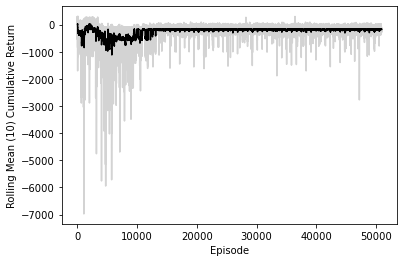

In [118]:
df = pd.DataFrame(history.history)
ax = df['episode_reward'].plot(color = 'lightgray')
df['episode_reward'].rolling(50).mean().plot(color = 'black')
ax.set_xlabel("Episode")
plt.ylabel("Rolling Mean (10) Cumulative Return")
plt.show()

The model has performed very poorly, the reward has barely ever made it over zero, staying pretty firmly in the negative numbers.

In [68]:
rl['Model 2'] = [1, '512/256/128', 5000000, 50000, 500, None]

Before adjusting the memory and log parameter, I decided to modify the network architecture slightly, to see if adding more connections (and complexity), might allow the network to better learn over a long period.

In [256]:
# neural netwok model
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_37 (Flatten)         (None, 8)                 0         
_________________________________________________________________
dense_148 (Dense)            (None, 512)               4608      
_________________________________________________________________
activation_148 (Activation)  (None, 512)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 256)               131328    
_________________________________________________________________
activation_149 (Activation)  (None, 256)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 128)               32896     
_________________________________________________________________
activation_150 (Activation)  (None, 128)             

In [257]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=30,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [98]:
weights_filename = f'dqn_lunar_weights_two.h5f'
checkpoint_weights_filename = 'dqn_lunar_weights_{step}.h5f'
log_filename = f'dqn_lunar_log.json'
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
start_time = time.time()
history = dqn.fit(env, callbacks=callbacks, nb_steps=5000000, log_interval=500)
end_time = time.time()

In [258]:
weights.append(f'dqn_lunar_weights_two.h5f')

In [259]:
models.append(dqn)
models[-1].load_weights(weights[-1])

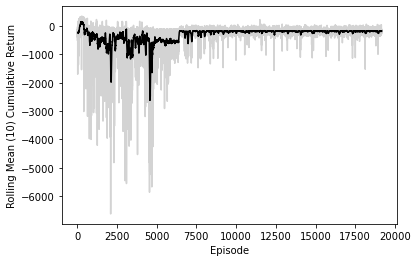

In [17]:
df = pd.DataFrame(history.history)
ax = df['episode_reward'].plot(color = 'lightgray')
df['episode_reward'].rolling(50).mean().plot(color = 'black')
ax.set_xlabel("Episode")
plt.ylabel("Rolling Mean (10) Cumulative Return")
plt.show()

It has behaved pretty similarly to the first model. Performance is poor.

## Increasing Window Length

There isn't a lot of documentation for Keras-RL, but from what I've understood, the window-length parameter coontrols how many samples are concatenated to form a "state". I believe setting this to 4, is somewhat equivalent to stacking four images for the CNN.
I have reduced training time to 250,000 steps, as it was simply taking too long.

In [69]:
rl['Model 3'] = [4, '128/64/32', 250000, 50000, 500, None]

When window size is changed, the model architecture also needs to be slightly adjusted, as the initial "Flatten" layer input-shape, must reflect the window-length. 

In [260]:
model = Sequential()
model.add(Flatten(input_shape=(4,) + env.observation_space.shape))
model.add(Dense(128)) 
model.add(Activation('relu'))
model.add(Dense(64)) 
model.add(Activation('relu'))
model.add(Dense(32)) 
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_38 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 128)               4224      
_________________________________________________________________
activation_152 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_153 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 32)                2080      
_________________________________________________________________
activation_154 (Activation)  (None, 32)              

In [261]:
memory = SequentialMemory(limit=50000, window_length=4)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=30,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [21]:
weights_filename = f'dqn_lunar_weights_three.h5f'
checkpoint_weights_filename = 'dqn_lunar_weights_{step}.h5f'
log_filename = f'dqn_lunar_log.json'
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
start_time = time.time()
history = dqn.fit(env, callbacks=callbacks, nb_steps=250000, log_interval=500)
end_time = time.time()

Training for 250000 steps ...
Interval 1 (0 steps performed)
  1/500 [..............................] - ETA: 53s - reward: 0.5876

/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/rl/memory.py:40: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


500/500 [==============================] - 3s 6ms/step - reward: -3.1131
5 episodes - episode_reward: -277.237 [-551.632, -121.857] - loss: 29.763 - mae: 5.930 - mean_q: -3.329

Interval 2 (500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.8036
4 episodes - episode_reward: -393.534 [-495.486, -211.179] - loss: 22.463 - mae: 12.092 - mean_q: -9.282

Interval 3 (1000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.5818
4 episodes - episode_reward: -270.248 [-552.909, -110.824] - loss: 14.705 - mae: 16.848 - mean_q: -13.583

Interval 4 (1500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.2545
4 episodes - episode_reward: -211.766 [-524.698, -46.129] - loss: 9.855 - mae: 22.448 - mean_q: -17.780

Interval 5 (2000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.7505
2 episodes - episode_reward: -188.300 [-214.067, -162.533] - loss: 8.709 - ma

500/500 [==============================] - 3s 7ms/step - reward: 0.8564
2 episodes - episode_reward: 235.754 [177.145, 294.364] - loss: 5.743 - mae: 29.850 - mean_q: 38.486

Interval 105 (52000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2187
1 episodes - episode_reward: -46.078 [-46.078, -46.078] - loss: 5.914 - mae: 29.626 - mean_q: 38.383

Interval 106 (52500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.1580
1 episodes - episode_reward: 129.008 [129.008, 129.008] - loss: 5.268 - mae: 29.649 - mean_q: 38.401

Interval 107 (53000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.1094
1 episodes - episode_reward: -98.409 [-98.409, -98.409] - loss: 7.808 - mae: 30.047 - mean_q: 38.801

Interval 108 (53500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0410
Interval 109 (54000 steps performed)
500/500 [==============================] - 3s 

500/500 [==============================] - 4s 8ms/step - reward: 0.3249
1 episodes - episode_reward: 117.515 [117.515, 117.515] - loss: 6.650 - mae: 41.755 - mean_q: 53.809

Interval 150 (74500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.3679
1 episodes - episode_reward: 276.315 [276.315, 276.315] - loss: 4.866 - mae: 42.081 - mean_q: 54.594

Interval 151 (75000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1580
1 episodes - episode_reward: -28.735 [-28.735, -28.735] - loss: 9.018 - mae: 42.336 - mean_q: 54.888

Interval 152 (75500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0442
Interval 153 (76000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.2971
1 episodes - episode_reward: 165.882 [165.882, 165.882] - loss: 7.465 - mae: 42.084 - mean_q: 54.617

Interval 154 (76500 steps performed)
500/500 [==============================] - 3s 7

500/500 [==============================] - 3s 7ms/step - reward: 0.2786
1 episodes - episode_reward: 223.088 [223.088, 223.088] - loss: 6.143 - mae: 43.138 - mean_q: 56.109

Interval 194 (96500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.6819
3 episodes - episode_reward: 126.442 [-110.820, 272.516] - loss: 8.091 - mae: 43.026 - mean_q: 56.058

Interval 195 (97000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.3555
2 episodes - episode_reward: 62.967 [-141.488, 267.423] - loss: 9.772 - mae: 42.976 - mean_q: 56.007

Interval 196 (97500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.1997
1 episodes - episode_reward: 147.098 [147.098, 147.098] - loss: 10.732 - mae: 43.211 - mean_q: 56.663

Interval 197 (98000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.1525
Interval 198 (98500 steps performed)
500/500 [==============================] - 3s

500/500 [==============================] - 3s 5ms/step - reward: 0.1929
1 episodes - episode_reward: 63.074 [63.074, 63.074] - loss: 10.336 - mae: 45.552 - mean_q: 59.854

Interval 236 (117500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.0478
3 episodes - episode_reward: 4.692 [-119.983, 234.059] - loss: 8.609 - mae: 45.767 - mean_q: 60.236

Interval 237 (118000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1219
1 episodes - episode_reward: 239.339 [239.339, 239.339] - loss: 7.738 - mae: 45.401 - mean_q: 59.686

Interval 238 (118500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.4198
1 episodes - episode_reward: 179.406 [179.406, 179.406] - loss: 9.238 - mae: 45.766 - mean_q: 60.256

Interval 239 (119000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0860
Interval 240 (119500 steps performed)
500/500 [==============================] - 3s

500/500 [==============================] - 3s 5ms/step - reward: 0.1475
3 episodes - episode_reward: 37.272 [-107.772, 282.729] - loss: 10.439 - mae: 45.223 - mean_q: 59.349

Interval 280 (139500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3633
1 episodes - episode_reward: 200.741 [200.741, 200.741] - loss: 9.158 - mae: 45.064 - mean_q: 59.191

Interval 281 (140000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1603
Interval 282 (140500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1009
1 episodes - episode_reward: 159.748 [159.748, 159.748] - loss: 7.685 - mae: 44.993 - mean_q: 58.703

Interval 283 (141000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.1937
Interval 284 (141500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.5416
3 episodes - episode_reward: -90.804 [-303.550, 179.597] - loss: 8.866

500/500 [==============================] - 3s 6ms/step - reward: 0.3433
2 episodes - episode_reward: 98.264 [-61.474, 258.001] - loss: 8.424 - mae: 44.444 - mean_q: 57.582

Interval 321 (160000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1931
Interval 322 (160500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2608
1 episodes - episode_reward: 208.522 [208.522, 208.522] - loss: 9.720 - mae: 45.006 - mean_q: 57.831

Interval 323 (161000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.2506
1 episodes - episode_reward: 102.711 [102.711, 102.711] - loss: 9.470 - mae: 44.570 - mean_q: 57.602

Interval 324 (161500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.8058
2 episodes - episode_reward: 146.431 [67.932, 224.930] - loss: 8.209 - mae: 44.878 - mean_q: 58.020

Interval 325 (162000 steps performed)
500/500 [==============================] - 3

500/500 [==============================] - 3s 5ms/step - reward: 0.4345
1 episodes - episode_reward: 218.812 [218.812, 218.812] - loss: 9.594 - mae: 48.084 - mean_q: 62.656

Interval 361 (180000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.5425
4 episodes - episode_reward: -108.755 [-146.312, -90.910] - loss: 8.586 - mae: 48.051 - mean_q: 62.598

Interval 362 (180500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.3986
1 episodes - episode_reward: 287.042 [287.042, 287.042] - loss: 10.759 - mae: 48.268 - mean_q: 62.481

Interval 363 (181000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.6731
1 episodes - episode_reward: 277.317 [277.317, 277.317] - loss: 8.603 - mae: 48.428 - mean_q: 62.855

Interval 364 (181500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.2544
2 episodes - episode_reward: 45.070 [-191.908, 282.049] - loss: 9.678 - mae:

500/500 [==============================] - 4s 7ms/step - reward: 0.2426
Interval 404 (201500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0201
Interval 405 (202000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.2222
3 episodes - episode_reward: -27.573 [-269.514, 142.041] - loss: 9.041 - mae: 47.903 - mean_q: 62.062

Interval 406 (202500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1965
1 episodes - episode_reward: 9.111 [9.111, 9.111] - loss: 8.525 - mae: 47.490 - mean_q: 61.423

Interval 407 (203000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0154
3 episodes - episode_reward: 5.349 [-105.854, 227.465] - loss: 7.863 - mae: 47.640 - mean_q: 61.621

Interval 408 (203500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 1.0106
2 episodes - episode_reward: 266.196 [194.914, 337.478] - loss: 9.953 - mae:

500/500 [==============================] - 3s 7ms/step - reward: 0.7921
2 episodes - episode_reward: 201.713 [175.019, 228.408] - loss: 9.100 - mae: 46.886 - mean_q: 61.133

Interval 448 (223500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.4867
3 episodes - episode_reward: -84.174 [-160.451, 24.404] - loss: 8.883 - mae: 46.993 - mean_q: 60.549

Interval 449 (224000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0437
Interval 450 (224500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0295
Interval 451 (225000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0323
Interval 452 (225500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.0332
Interval 453 (226000 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -0.0390
Interval 454 (226500 steps performed)
500/500 [===========

500/500 [==============================] - 4s 7ms/step - reward: 0.7080
1 episodes - episode_reward: 232.464 [232.464, 232.464] - loss: 6.707 - mae: 39.220 - mean_q: 50.888

Interval 500 (249500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.5178
done, took 1772.135 seconds


In [262]:
weights.append(f'dqn_lunar_weights_three.h5f')

In [263]:
models.append(dqn)
models[-1].load_weights(weights[-1])

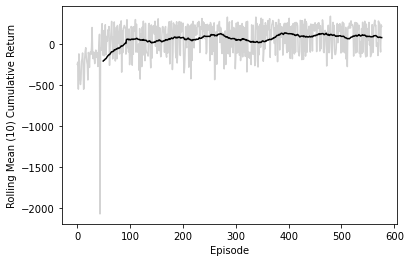

In [23]:
df = pd.DataFrame(history.history)
ax = df['episode_reward'].plot(color = 'lightgray')
df['episode_reward'].rolling(50).mean().plot(color = 'black')
ax.set_xlabel("Episode")
plt.ylabel("Rolling Mean (10) Cumulative Return")
plt.show()

Performance has improved significantly. Although mean reward levels are still hovering around zero, we are seeing much less of the big negative numbers that were seen in the previous models. Some positive numbers are also now being recorded.

In [70]:
rl['Model 4'] = [6, '128/64/32', 250000, 50000, 500, None]

Here I have increased window size again, keeping the same memory and step limits.

In [264]:
model = Sequential()
#input_shape of 6, to reflect new window length
model.add(Flatten(input_shape=(6,) + env.observation_space.shape))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_39 (Flatten)         (None, 48)                0         
_________________________________________________________________
dense_156 (Dense)            (None, 128)               6272      
_________________________________________________________________
activation_156 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_157 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 32)                2080      
_________________________________________________________________
activation_158 (Activation)  (None, 32)              

In [265]:
memory = SequentialMemory(limit=50000, window_length=6)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=30,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [9]:
weights_filename = f'dqn_lunar_weights_four.h5f'
checkpoint_weights_filename = 'dqn_lunar_weights_{step}.h5f'
log_filename = f'dqn_lunar_log.json'
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
start_time = time.time()
history = dqn.fit(env, callbacks=callbacks, nb_steps=250000, log_interval=500)
end_time = time.time()

Training for 250000 steps ...
Interval 1 (0 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.2470
4 episodes - episode_reward: -163.342 [-230.525, -100.000] - loss: 51.265 - mae: 2.554 - mean_q: 1.008

Interval 2 (500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.8216
3 episodes - episode_reward: -89.515 [-297.567, 178.719] - loss: 21.909 - mae: 3.750 - mean_q: 5.078

Interval 3 (1000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.7107
4 episodes - episode_reward: -361.254 [-610.655, -212.364] - loss: 23.944 - mae: 7.009 - mean_q: 6.891

Interval 4 (1500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0163
Interval 5 (2000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.5665
3 episodes - episode_reward: -108.893 [-259.213, 58.571] - loss: 12.971 - mae: 13.062 - mean_q: 10.156

Interval 6 (2500 steps per

500/500 [==============================] - 3s 6ms/step - reward: -0.0275
Interval 50 (24500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.1134
Interval 51 (25000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.1657
1 episodes - episode_reward: 75.596 [75.596, 75.596] - loss: 13.337 - mae: 42.271 - mean_q: 51.752

Interval 52 (25500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.2814
Interval 53 (26000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.3986
1 episodes - episode_reward: 254.182 [254.182, 254.182] - loss: 16.990 - mae: 43.175 - mean_q: 53.724

Interval 54 (26500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.0155
3 episodes - episode_reward: 37.752 [-117.863, 216.919] - loss: 12.590 - mae: 43.590 - mean_q: 54.039

Interval 55 (27000 steps performed)
500/500 [==============================] - 

500/500 [==============================] - 3s 6ms/step - reward: -0.1719
Interval 142 (70500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2361
2 episodes - episode_reward: 0.199 [-297.694, 298.093] - loss: 12.117 - mae: 41.350 - mean_q: 53.323

Interval 143 (71000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2606
2 episodes - episode_reward: -117.467 [-118.163, -116.771] - loss: 7.723 - mae: 40.729 - mean_q: 52.726

Interval 144 (71500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0318
Interval 145 (72000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0372
Interval 146 (72500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0846
Interval 147 (73000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3523
1 episodes - episode_reward: 244.040 [244.040, 244.040] - loss: 

500/500 [==============================] - 3s 6ms/step - reward: 0.5697
3 episodes - episode_reward: 136.004 [-103.609, 255.935] - loss: 8.402 - mae: 44.527 - mean_q: 58.220

Interval 230 (114500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.9124
1 episodes - episode_reward: 302.406 [302.406, 302.406] - loss: 7.869 - mae: 44.869 - mean_q: 58.594

Interval 231 (115000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3694
1 episodes - episode_reward: 282.774 [282.774, 282.774] - loss: 6.374 - mae: 44.480 - mean_q: 58.358

Interval 232 (115500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.5889
1 episodes - episode_reward: 262.357 [262.357, 262.357] - loss: 9.451 - mae: 44.507 - mean_q: 58.373

Interval 233 (116000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.1742
1 episodes - episode_reward: 201.414 [201.414, 201.414] - loss: 8.081 - mae: 44

500/500 [==============================] - 3s 7ms/step - reward: 0.4427
1 episodes - episode_reward: 141.876 [141.876, 141.876] - loss: 6.835 - mae: 46.056 - mean_q: 60.485

Interval 272 (135500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0930
2 episodes - episode_reward: 33.186 [-157.963, 224.335] - loss: 6.126 - mae: 46.005 - mean_q: 60.379

Interval 273 (136000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.8357
2 episodes - episode_reward: 201.414 [181.968, 220.859] - loss: 6.594 - mae: 46.187 - mean_q: 60.708

Interval 274 (136500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.4977
1 episodes - episode_reward: 308.635 [308.635, 308.635] - loss: 7.145 - mae: 46.369 - mean_q: 60.379

Interval 275 (137000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.4631
1 episodes - episode_reward: 209.959 [209.959, 209.959] - loss: 7.845 - mae: 46.

500/500 [==============================] - 3s 6ms/step - reward: 0.5353
3 episodes - episode_reward: 159.804 [-63.408, 273.398] - loss: 8.321 - mae: 43.521 - mean_q: 56.822

Interval 315 (157000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3459
1 episodes - episode_reward: 190.024 [190.024, 190.024] - loss: 5.478 - mae: 43.415 - mean_q: 56.622

Interval 316 (157500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0858
1 episodes - episode_reward: -95.164 [-95.164, -95.164] - loss: 10.974 - mae: 43.142 - mean_q: 56.064

Interval 317 (158000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.8290
2 episodes - episode_reward: 221.391 [180.467, 262.314] - loss: 9.815 - mae: 43.201 - mean_q: 56.286

Interval 318 (158500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1247
2 episodes - episode_reward: 47.522 [-142.492, 237.536] - loss: 8.704 - mae: 43

500/500 [==============================] - 3s 5ms/step - reward: 0.0441
4 episodes - episode_reward: 9.200 [-107.834, 261.858] - loss: 10.570 - mae: 41.602 - mean_q: 53.091

Interval 355 (177000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0307
4 episodes - episode_reward: 11.876 [-100.000, 225.738] - loss: 8.674 - mae: 41.705 - mean_q: 53.440

Interval 356 (177500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0254
Interval 357 (178000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.4504
2 episodes - episode_reward: -154.311 [-165.075, -143.547] - loss: 12.147 - mae: 41.410 - mean_q: 52.737

Interval 358 (178500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.4635
2 episodes - episode_reward: 148.456 [21.683, 275.229] - loss: 13.153 - mae: 41.695 - mean_q: 53.285

Interval 359 (179000 steps performed)
500/500 [============================

500/500 [==============================] - 3s 6ms/step - reward: -0.4494
3 episodes - episode_reward: -95.508 [-109.599, -81.967] - loss: 11.113 - mae: 43.536 - mean_q: 54.994

Interval 399 (199000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.5978
3 episodes - episode_reward: 125.775 [11.987, 201.290] - loss: 11.586 - mae: 43.647 - mean_q: 55.141

Interval 400 (199500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1510
3 episodes - episode_reward: 11.379 [-118.160, 211.377] - loss: 11.258 - mae: 44.002 - mean_q: 55.776

Interval 401 (200000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0401
2 episodes - episode_reward: -44.699 [-140.392, 50.995] - loss: 10.901 - mae: 43.894 - mean_q: 55.299

Interval 402 (200500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2980
2 episodes - episode_reward: 102.413 [-59.833, 264.660] - loss: 11.865 - m

500/500 [==============================] - 3s 7ms/step - reward: 0.1893
Interval 441 (220000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.0658
Interval 442 (220500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.4265
2 episodes - episode_reward: 75.762 [2.652, 148.871] - loss: 10.475 - mae: 46.397 - mean_q: 58.929

Interval 443 (221000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.5233
1 episodes - episode_reward: 301.151 [301.151, 301.151] - loss: 12.115 - mae: 46.500 - mean_q: 58.979

Interval 444 (221500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1565
1 episodes - episode_reward: 172.437 [172.437, 172.437] - loss: 10.222 - mae: 46.015 - mean_q: 58.560

Interval 445 (222000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2651
Interval 446 (222500 steps performed)
500/500 [========================

500/500 [==============================] - 3s 6ms/step - reward: -0.2469
1 episodes - episode_reward: -231.907 [-231.907, -231.907] - loss: 9.363 - mae: 44.262 - mean_q: 56.014

Interval 482 (240500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.6819
2 episodes - episode_reward: 194.417 [193.625, 195.210] - loss: 9.551 - mae: 43.860 - mean_q: 55.317

Interval 483 (241000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1481
Interval 484 (241500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0058
Interval 485 (242000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2131
1 episodes - episode_reward: 212.077 [212.077, 212.077] - loss: 6.680 - mae: 44.305 - mean_q: 55.936

Interval 486 (242500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.4834
1 episodes - episode_reward: 171.631 [171.631, 171.631] - loss: 10.

In [266]:
weights.append(f'dqn_lunar_weights_four.h5f')

In [267]:
models.append(dqn)
models[-1].load_weights(weights[-1])

In [10]:
dqn.save_weights(weights_filename, overwrite=True)

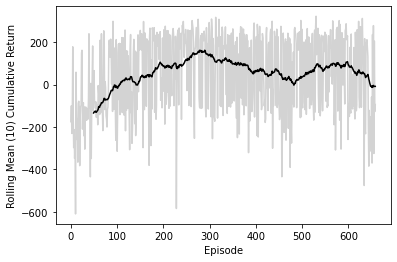

In [11]:
df = pd.DataFrame(history.history)
ax = df['episode_reward'].plot(color = 'lightgray')
df['episode_reward'].rolling(50).mean().plot(color = 'black')
ax.set_xlabel("Episode")
plt.ylabel("Rolling Mean (10) Cumulative Return")
plt.show()

Increasing window size from 4 to 6 has improved performance again. Although the rolling average is still in and around zero, we see big numbers, like +200, for the first time. It is clear though that this performance is unstable, we are still getting some "-400' and '-600'. Given that the model only training for 250,000 steps though, I think this is acceptable. 

## Increasing Training Time

In [12]:
df.to_csv('lunar_training_weights_4')

I will now let this model train for 2,000,000. We will see if the instability resolves with a longer training time. 

In [71]:
rl['Model 5'] = [6, '128/64/32', 2000000, 50000, 500, None]

In [15]:
weights_filename = f'dqn_lunar_weights_five.h5f'
checkpoint_weights_filename = 'dqn_lunar_weights_{step}.h5f'
log_filename = f'dqn_lunar_log.json'
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
start_time = time.time()
history = dqn.fit(env, callbacks=callbacks, nb_steps=2000000, log_interval=500)
end_time = time.time()

Training for 2000000 steps ...
Interval 1 (0 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1147
1 episodes - episode_reward: -166.116 [-166.116, -166.116] - loss: 13.000 - mae: 44.508 - mean_q: 55.712

Interval 2 (500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.5390
2 episodes - episode_reward: -57.334 [-331.303, 216.634] - loss: 11.020 - mae: 44.079 - mean_q: 55.477

Interval 3 (1000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.1391
2 episodes - episode_reward: 9.995 [-155.479, 175.469] - loss: 12.129 - mae: 44.020 - mean_q: 54.997

Interval 4 (1500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.3285
1 episodes - episode_reward: -287.423 [-287.423, -287.423] - loss: 12.539 - mae: 44.095 - mean_q: 55.346

Interval 5 (2000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1484
2 episodes - episode_

500/500 [==============================] - 3s 6ms/step - reward: 0.2520
1 episodes - episode_reward: -31.557 [-31.557, -31.557] - loss: 11.276 - mae: 44.912 - mean_q: 56.870

Interval 45 (22000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.5263
2 episodes - episode_reward: 234.492 [196.532, 272.453] - loss: 11.379 - mae: 45.560 - mean_q: 57.232

Interval 46 (22500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1901
1 episodes - episode_reward: -138.822 [-138.822, -138.822] - loss: 10.905 - mae: 45.248 - mean_q: 57.215

Interval 47 (23000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0837
3 episodes - episode_reward: -26.740 [-111.832, 131.612] - loss: 10.478 - mae: 45.015 - mean_q: 56.625

Interval 48 (23500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1640
2 episodes - episode_reward: 49.248 [-113.061, 211.557] - loss: 12.997 - mae: 

500/500 [==============================] - 4s 8ms/step - reward: 0.0844
1 episodes - episode_reward: -109.335 [-109.335, -109.335] - loss: 9.674 - mae: 43.801 - mean_q: 55.177

Interval 90 (44500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2368
2 episodes - episode_reward: 112.797 [-50.754, 276.349] - loss: 12.698 - mae: 44.028 - mean_q: 55.817

Interval 91 (45000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1734
1 episodes - episode_reward: -24.197 [-24.197, -24.197] - loss: 11.261 - mae: 44.448 - mean_q: 56.313

Interval 92 (45500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2874
3 episodes - episode_reward: 54.449 [-60.299, 258.742] - loss: 13.325 - mae: 44.522 - mean_q: 56.457

Interval 93 (46000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2059
2 episodes - episode_reward: 37.338 [-158.481, 233.156] - loss: 11.613 - mae: 44.6

500/500 [==============================] - 3s 6ms/step - reward: 0.0585
1 episodes - episode_reward: -68.477 [-68.477, -68.477] - loss: 12.141 - mae: 45.651 - mean_q: 59.594

Interval 177 (88000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0764
2 episodes - episode_reward: 55.257 [-130.447, 240.960] - loss: 12.243 - mae: 45.879 - mean_q: 59.567

Interval 178 (88500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2084
3 episodes - episode_reward: -18.322 [-162.783, 218.642] - loss: 12.731 - mae: 45.680 - mean_q: 59.500

Interval 179 (89000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.8491
1 episodes - episode_reward: 260.797 [260.797, 260.797] - loss: 10.179 - mae: 46.269 - mean_q: 59.695

Interval 180 (89500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.4308
1 episodes - episode_reward: 258.943 [258.943, 258.943] - loss: 11.160 - mae: 

500/500 [==============================] - 3s 6ms/step - reward: 0.3838
1 episodes - episode_reward: 336.898 [336.898, 336.898] - loss: 8.289 - mae: 48.646 - mean_q: 63.006

Interval 218 (108500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3943
1 episodes - episode_reward: 224.982 [224.982, 224.982] - loss: 9.563 - mae: 48.368 - mean_q: 63.087

Interval 219 (109000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0156
3 episodes - episode_reward: -3.380 [-125.795, 184.156] - loss: 8.125 - mae: 47.858 - mean_q: 62.568

Interval 220 (109500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3778
2 episodes - episode_reward: 122.416 [20.640, 224.192] - loss: 10.639 - mae: 47.587 - mean_q: 62.096

Interval 221 (110000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.5248
1 episodes - episode_reward: 259.953 [259.953, 259.953] - loss: 9.183 - mae: 47

500/500 [==============================] - 3s 6ms/step - reward: -0.1887
3 episodes - episode_reward: -13.859 [-154.701, 228.743] - loss: 8.902 - mae: 48.275 - mean_q: 62.479

Interval 258 (128500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1601
Interval 259 (129000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.0350
Interval 260 (129500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.0414
Interval 261 (130000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.0474
Interval 262 (130500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.0347
Interval 263 (131000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0308
Interval 264 (131500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0317
Interval 265 (132000 steps performed)
500/500 [=

500/500 [==============================] - 3s 6ms/step - reward: 0.5824
1 episodes - episode_reward: 260.959 [260.959, 260.959] - loss: 11.111 - mae: 43.982 - mean_q: 56.275

Interval 302 (150500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.4786
1 episodes - episode_reward: 169.328 [169.328, 169.328] - loss: 9.649 - mae: 43.399 - mean_q: 55.824

Interval 303 (151000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3117
2 episodes - episode_reward: 65.087 [-100.000, 230.174] - loss: 10.818 - mae: 43.494 - mean_q: 55.668

Interval 304 (151500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0118
Interval 305 (152000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.8899
6 episodes - episode_reward: -41.775 [-125.741, 250.677] - loss: 9.582 - mae: 43.224 - mean_q: 55.462

Interval 306 (152500 steps performed)
500/500 [============================

500/500 [==============================] - 3s 6ms/step - reward: 0.2413
Interval 343 (171000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2669
3 episodes - episode_reward: 93.610 [-25.270, 273.878] - loss: 8.531 - mae: 44.863 - mean_q: 57.682

Interval 344 (171500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1836
Interval 345 (172000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.0109
Interval 346 (172500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.0174
Interval 347 (173000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3189
1 episodes - episode_reward: 203.696 [203.696, 203.696] - loss: 9.942 - mae: 44.507 - mean_q: 57.350

Interval 348 (173500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.5418
2 episodes - episode_reward: 109.925 [33.611, 186.240] - loss: 8

500/500 [==============================] - 4s 8ms/step - reward: 0.2618
1 episodes - episode_reward: 144.446 [144.446, 144.446] - loss: 11.353 - mae: 41.206 - mean_q: 53.949

Interval 432 (215500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.7724
3 episodes - episode_reward: -105.673 [-182.777, -34.244] - loss: 12.054 - mae: 41.053 - mean_q: 53.906

Interval 433 (216000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0892
1 episodes - episode_reward: -172.343 [-172.343, -172.343] - loss: 9.181 - mae: 40.586 - mean_q: 53.611

Interval 434 (216500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.3966
3 episodes - episode_reward: 113.698 [-126.335, 266.385] - loss: 9.394 - mae: 40.282 - mean_q: 52.826

Interval 435 (217000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.8429
2 episodes - episode_reward: -445.552 [-614.053, -277.051] - loss: 12.

500/500 [==============================] - 4s 8ms/step - reward: -0.1415
Interval 475 (237000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.1093
Interval 476 (237500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.3621
1 episodes - episode_reward: 82.961 [82.961, 82.961] - loss: 8.884 - mae: 36.999 - mean_q: 45.605

Interval 477 (238000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.2212
2 episodes - episode_reward: -70.043 [-100.000, -40.087] - loss: 11.443 - mae: 36.896 - mean_q: 45.414

Interval 478 (238500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.1802
1 episodes - episode_reward: 230.327 [230.327, 230.327] - loss: 10.105 - mae: 36.781 - mean_q: 45.753

Interval 479 (239000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.3167
1 episodes - episode_reward: 94.764 [94.764, 94.764] - loss: 9.440 - m

500/500 [==============================] - 4s 8ms/step - reward: 0.0047
Interval 518 (258500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.3779
1 episodes - episode_reward: 172.063 [172.063, 172.063] - loss: 11.606 - mae: 40.527 - mean_q: 48.265

Interval 519 (259000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.5721
1 episodes - episode_reward: 230.146 [230.146, 230.146] - loss: 9.487 - mae: 40.646 - mean_q: 49.018

Interval 520 (259500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.3822
1 episodes - episode_reward: 239.895 [239.895, 239.895] - loss: 9.518 - mae: 40.319 - mean_q: 48.375

Interval 521 (260000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.3440
1 episodes - episode_reward: 262.492 [262.492, 262.492] - loss: 10.286 - mae: 40.632 - mean_q: 49.157

Interval 522 (260500 steps performed)
500/500 [==============================]

500/500 [==============================] - 4s 8ms/step - reward: 0.5554
1 episodes - episode_reward: 146.313 [146.313, 146.313] - loss: 10.662 - mae: 44.490 - mean_q: 57.058

Interval 603 (301000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0129
Interval 604 (301500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.2468
1 episodes - episode_reward: 216.942 [216.942, 216.942] - loss: 11.506 - mae: 45.075 - mean_q: 57.870

Interval 605 (302000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.2665
1 episodes - episode_reward: 143.134 [143.134, 143.134] - loss: 9.771 - mae: 45.166 - mean_q: 58.120

Interval 606 (302500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.6665
3 episodes - episode_reward: -133.188 [-184.649, -70.790] - loss: 15.302 - mae: 45.731 - mean_q: 58.820

Interval 607 (303000 steps performed)
500/500 [==========================

500/500 [==============================] - 4s 8ms/step - reward: -0.0764
Interval 646 (322500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.2356
1 episodes - episode_reward: 196.539 [196.539, 196.539] - loss: 13.562 - mae: 43.468 - mean_q: 55.228

Interval 647 (323000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.3697
4 episodes - episode_reward: -29.141 [-107.840, 149.542] - loss: 21.308 - mae: 43.318 - mean_q: 54.815

Interval 648 (323500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.6006
1 episodes - episode_reward: 256.267 [256.267, 256.267] - loss: 21.425 - mae: 43.818 - mean_q: 55.738

Interval 649 (324000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.4251
2 episodes - episode_reward: -163.144 [-273.519, -52.769] - loss: 27.985 - mae: 44.364 - mean_q: 56.048

Interval 650 (324500 steps performed)
500/500 [=======================

500/500 [==============================] - 4s 8ms/step - reward: 0.0880
Interval 689 (344000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.1092
1 episodes - episode_reward: 131.663 [131.663, 131.663] - loss: 15.384 - mae: 41.291 - mean_q: 49.959

Interval 690 (344500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.6799
1 episodes - episode_reward: -333.710 [-333.710, -333.710] - loss: 15.197 - mae: 40.968 - mean_q: 49.962

Interval 691 (345000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.5655
2 episodes - episode_reward: -176.179 [-222.595, -129.762] - loss: 17.502 - mae: 40.709 - mean_q: 49.409

Interval 692 (345500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.2402
Interval 693 (346000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0615
1 episodes - episode_reward: 231.433 [231.433, 231.433] - los

500/500 [==============================] - 4s 8ms/step - reward: -0.2240
1 episodes - episode_reward: -115.970 [-115.970, -115.970] - loss: 14.580 - mae: 37.813 - mean_q: 44.140

Interval 736 (367500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.6430
2 episodes - episode_reward: -210.615 [-273.869, -147.361] - loss: 15.358 - mae: 38.035 - mean_q: 44.319

Interval 737 (368000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.6565
2 episodes - episode_reward: -154.628 [-195.276, -113.980] - loss: 16.278 - mae: 37.753 - mean_q: 44.453

Interval 738 (368500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.3162
1 episodes - episode_reward: 232.634 [232.634, 232.634] - loss: 17.380 - mae: 37.698 - mean_q: 43.882

Interval 739 (369000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.3057
1 episodes - episode_reward: -178.616 [-178.616, -178.616] - lo

500/500 [==============================] - 4s 7ms/step - reward: 0.6797
1 episodes - episode_reward: 177.350 [177.350, 177.350] - loss: 13.349 - mae: 39.203 - mean_q: 47.722

Interval 781 (390000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.4155
2 episodes - episode_reward: 31.806 [-232.875, 296.488] - loss: 13.449 - mae: 39.528 - mean_q: 48.491

Interval 782 (390500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.4535
1 episodes - episode_reward: 170.601 [170.601, 170.601] - loss: 14.577 - mae: 39.583 - mean_q: 48.962

Interval 783 (391000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.2034
2 episodes - episode_reward: 37.791 [-141.663, 217.244] - loss: 13.566 - mae: 39.549 - mean_q: 48.345

Interval 784 (391500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.1646
Interval 785 (392000 steps performed)
500/500 [============================

500/500 [==============================] - 4s 7ms/step - reward: 0.2541
Interval 822 (410500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.5704
1 episodes - episode_reward: 256.581 [256.581, 256.581] - loss: 17.019 - mae: 39.231 - mean_q: 49.233

Interval 823 (411000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.7206
2 episodes - episode_reward: 274.400 [263.710, 285.090] - loss: 18.385 - mae: 39.168 - mean_q: 48.988

Interval 824 (411500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1842
1 episodes - episode_reward: -175.685 [-175.685, -175.685] - loss: 15.373 - mae: 39.194 - mean_q: 48.868

Interval 825 (412000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.1499
2 episodes - episode_reward: 43.910 [-89.689, 177.508] - loss: 14.593 - mae: 39.499 - mean_q: 48.842

Interval 826 (412500 steps performed)
500/500 [==========================

500/500 [==============================] - 4s 8ms/step - reward: 0.3308
1 episodes - episode_reward: 36.430 [36.430, 36.430] - loss: 20.017 - mae: 49.800 - mean_q: 62.461

Interval 905 (452000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0034
Interval 906 (452500 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: -0.0158
Interval 907 (453000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.1433
1 episodes - episode_reward: 168.428 [168.428, 168.428] - loss: 15.956 - mae: 49.034 - mean_q: 62.084

Interval 908 (453500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1517
1 episodes - episode_reward: -79.425 [-79.425, -79.425] - loss: 14.464 - mae: 49.297 - mean_q: 62.535

Interval 909 (454000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.0966
Interval 910 (454500 steps performed)
500/500 [======================

500/500 [==============================] - 4s 8ms/step - reward: 0.2377
1 episodes - episode_reward: 154.614 [154.614, 154.614] - loss: 11.279 - mae: 38.764 - mean_q: 50.373

Interval 954 (476500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.7302
1 episodes - episode_reward: 167.919 [167.919, 167.919] - loss: 9.607 - mae: 38.814 - mean_q: 50.407

Interval 955 (477000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.1225
2 episodes - episode_reward: 134.829 [-49.672, 319.331] - loss: 11.425 - mae: 38.744 - mean_q: 50.110

Interval 956 (477500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.1176
1 episodes - episode_reward: -39.075 [-39.075, -39.075] - loss: 14.854 - mae: 38.617 - mean_q: 50.008

Interval 957 (478000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.0434
4 episodes - episode_reward: -111.174 [-306.320, 231.510] - loss: 11.637 - m

500/500 [==============================] - 4s 8ms/step - reward: -0.1420
Interval 1045 (522000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.3325
3 episodes - episode_reward: -46.479 [-223.139, 139.557] - loss: 11.410 - mae: 39.931 - mean_q: 50.053

Interval 1046 (522500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.0159
1 episodes - episode_reward: -88.073 [-88.073, -88.073] - loss: 12.722 - mae: 40.088 - mean_q: 50.532

Interval 1047 (523000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.7119
1 episodes - episode_reward: -294.865 [-294.865, -294.865] - loss: 10.005 - mae: 40.079 - mean_q: 50.422

Interval 1048 (523500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -2.2460
3 episodes - episode_reward: -375.855 [-601.659, -234.889] - loss: 13.730 - mae: 40.028 - mean_q: 49.817

Interval 1049 (524000 steps performed)
500/500 [============

500/500 [==============================] - 4s 8ms/step - reward: -0.1392
Interval 1089 (544000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.8002
2 episodes - episode_reward: -238.494 [-289.837, -187.151] - loss: 15.949 - mae: 47.636 - mean_q: 59.429

Interval 1090 (544500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2341
1 episodes - episode_reward: -132.840 [-132.840, -132.840] - loss: 11.384 - mae: 47.898 - mean_q: 60.572

Interval 1091 (545000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.5498
2 episodes - episode_reward: -98.641 [-199.668, 2.387] - loss: 18.710 - mae: 48.479 - mean_q: 60.978

Interval 1092 (545500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0831
Interval 1093 (546000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1638
1 episodes - episode_reward: -188.108 [-188.108, -188

500/500 [==============================] - 4s 8ms/step - reward: 0.0065
Interval 1143 (571000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.2937
3 episodes - episode_reward: 102.375 [-173.533, 251.684] - loss: 11.858 - mae: 48.274 - mean_q: 60.693

Interval 1144 (571500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.0029
1 episodes - episode_reward: -85.257 [-85.257, -85.257] - loss: 9.698 - mae: 47.888 - mean_q: 60.030

Interval 1145 (572000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0353
Interval 1146 (572500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: 0.2959
1 episodes - episode_reward: 172.705 [172.705, 172.705] - loss: 9.189 - mae: 47.988 - mean_q: 60.301

Interval 1147 (573000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0108
1 episodes - episode_reward: -81.187 [-81.187, -81.187] - loss:

500/500 [==============================] - 4s 7ms/step - reward: 0.3791
1 episodes - episode_reward: 184.683 [184.683, 184.683] - loss: 14.333 - mae: 38.178 - mean_q: 47.506

Interval 1187 (593000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.3152
2 episodes - episode_reward: -92.933 [-111.140, -74.726] - loss: 13.607 - mae: 37.479 - mean_q: 47.178

Interval 1188 (593500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.4571
2 episodes - episode_reward: -104.361 [-118.246, -90.476] - loss: 15.268 - mae: 37.977 - mean_q: 47.691

Interval 1189 (594000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0049
Interval 1190 (594500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.0258
3 episodes - episode_reward: -14.562 [-109.381, 130.604] - loss: 12.849 - mae: 36.910 - mean_q: 46.514

Interval 1191 (595000 steps performed)
500/500 [================

500/500 [==============================] - 4s 7ms/step - reward: -0.2499
1 episodes - episode_reward: -100.769 [-100.769, -100.769] - loss: 13.325 - mae: 40.085 - mean_q: 48.274

Interval 1230 (614500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1079
1 episodes - episode_reward: -63.371 [-63.371, -63.371] - loss: 14.680 - mae: 40.389 - mean_q: 48.786

Interval 1231 (615000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.2967
1 episodes - episode_reward: 127.278 [127.278, 127.278] - loss: 15.206 - mae: 40.694 - mean_q: 48.510

Interval 1232 (615500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.3608
3 episodes - episode_reward: -62.566 [-262.724, 200.948] - loss: 18.489 - mae: 40.604 - mean_q: 48.285

Interval 1233 (616000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0113
Interval 1234 (616500 steps performed)
500/500 [=================

500/500 [==============================] - 4s 9ms/step - reward: -0.0969
Interval 1322 (660500 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: 0.3629
1 episodes - episode_reward: 64.973 [64.973, 64.973] - loss: 9.714 - mae: 42.248 - mean_q: 54.010

Interval 1323 (661000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.4340
2 episodes - episode_reward: -123.296 [-215.806, -30.785] - loss: 21.120 - mae: 42.177 - mean_q: 53.688

Interval 1324 (661500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.6050
1 episodes - episode_reward: -263.125 [-263.125, -263.125] - loss: 10.282 - mae: 41.848 - mean_q: 53.716

Interval 1325 (662000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0197
Interval 1326 (662500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.8023
3 episodes - episode_reward: -140.365 [-361.045, 95.413] - 

500/500 [==============================] - 4s 7ms/step - reward: -0.1391
Interval 1417 (708000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2263
Interval 1418 (708500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.1285
Interval 1419 (709000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.8249
2 episodes - episode_reward: -301.110 [-475.325, -126.894] - loss: 14.464 - mae: 54.564 - mean_q: 69.095

Interval 1420 (709500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2684
Interval 1421 (710000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.3088
Interval 1422 (710500 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: 0.0243
Interval 1423 (711000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.3472
2 episodes - episode_reward: -244.265

500/500 [==============================] - 3s 7ms/step - reward: -1.2988
3 episodes - episode_reward: -245.707 [-289.370, -207.681] - loss: 17.090 - mae: 46.537 - mean_q: 58.920

Interval 1511 (755000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.7369
3 episodes - episode_reward: -126.770 [-244.164, -38.904] - loss: 17.683 - mae: 46.842 - mean_q: 59.366

Interval 1512 (755500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0016
1 episodes - episode_reward: -33.581 [-33.581, -33.581] - loss: 14.210 - mae: 45.915 - mean_q: 58.355

Interval 1513 (756000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0098
Interval 1514 (756500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.4111
2 episodes - episode_reward: -69.806 [-274.243, 134.631] - loss: 11.715 - mae: 45.531 - mean_q: 57.781

Interval 1515 (757000 steps performed)
500/500 [==============

500/500 [==============================] - 5s 10ms/step - reward: -0.0116
Interval 1561 (780000 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: 0.1453
1 episodes - episode_reward: 82.487 [82.487, 82.487] - loss: 14.238 - mae: 36.682 - mean_q: 46.252

Interval 1562 (780500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1863
2 episodes - episode_reward: -52.952 [-136.253, 30.349] - loss: 13.830 - mae: 36.868 - mean_q: 46.353

Interval 1563 (781000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1093
Interval 1564 (781500 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: -0.8341
1 episodes - episode_reward: -458.960 [-458.960, -458.960] - loss: 14.553 - mae: 37.641 - mean_q: 47.077

Interval 1565 (782000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.3406
1 episodes - episode_reward: -153.487 [-153.487, -153.487]

500/500 [==============================] - 5s 9ms/step - reward: -0.0479
Interval 1653 (826000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.3947
1 episodes - episode_reward: 20.735 [20.735, 20.735] - loss: 17.585 - mae: 39.056 - mean_q: 48.721

Interval 1654 (826500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.3242
1 episodes - episode_reward: 23.163 [23.163, 23.163] - loss: 15.185 - mae: 39.584 - mean_q: 48.937

Interval 1655 (827000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.3293
1 episodes - episode_reward: -327.166 [-327.166, -327.166] - loss: 18.477 - mae: 39.606 - mean_q: 49.525

Interval 1656 (827500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0852
Interval 1657 (828000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.1286
Interval 1658 (828500 steps performed)
500/500 [==============

500/500 [==============================] - 4s 7ms/step - reward: -0.4824
2 episodes - episode_reward: -132.218 [-199.927, -64.509] - loss: 17.949 - mae: 47.595 - mean_q: 59.681

Interval 1696 (847500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.5345
2 episodes - episode_reward: -72.654 [-103.986, -41.322] - loss: 17.901 - mae: 48.066 - mean_q: 59.706

Interval 1697 (848000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.8910
3 episodes - episode_reward: -175.306 [-293.947, -34.068] - loss: 19.685 - mae: 48.152 - mean_q: 59.111

Interval 1698 (848500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.8504
3 episodes - episode_reward: -157.074 [-190.458, -122.125] - loss: 19.529 - mae: 47.990 - mean_q: 60.004

Interval 1699 (849000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1189
Interval 1700 (849500 steps performed)
500/500 [===========

500/500 [==============================] - 4s 8ms/step - reward: -0.0373
2 episodes - episode_reward: -14.521 [-107.044, 78.002] - loss: 34.758 - mae: 55.924 - mean_q: 64.802

Interval 1780 (889500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.1111
Interval 1781 (890000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.2341
Interval 1782 (890500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.0956
6 episodes - episode_reward: -181.289 [-339.712, 15.986] - loss: 31.990 - mae: 53.824 - mean_q: 60.558

Interval 1783 (891000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.1085
Interval 1784 (891500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.3291
2 episodes - episode_reward: 34.526 [-56.547, 125.598] - loss: 36.939 - mae: 53.355 - mean_q: 58.722

Interval 1785 (892000 steps performed)
500/500 [=============

500/500 [==============================] - 4s 7ms/step - reward: -1.3805
7 episodes - episode_reward: -89.167 [-183.359, 166.438] - loss: 29.413 - mae: 63.974 - mean_q: 80.210

Interval 1872 (935500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.9235
1 episodes - episode_reward: -944.205 [-944.205, -944.205] - loss: 41.448 - mae: 64.288 - mean_q: 80.711

Interval 1873 (936000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.1935
Interval 1874 (936500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0258
1 episodes - episode_reward: 152.277 [152.277, 152.277] - loss: 35.319 - mae: 63.416 - mean_q: 79.000

Interval 1875 (937000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.5053
2 episodes - episode_reward: -165.900 [-209.740, -122.061] - loss: 84.929 - mae: 62.912 - mean_q: 78.459

Interval 1876 (937500 steps performed)
500/500 [=============

500/500 [==============================] - 15s 31ms/step - reward: -4.6471
7 episodes - episode_reward: -336.740 [-485.746, -137.361] - loss: 287.820 - mae: 112.158 - mean_q: 134.895

Interval 1951 (975000 steps performed)
500/500 [==============================] - 15s 30ms/step - reward: -1.9646
4 episodes - episode_reward: -244.017 [-388.169, -93.244] - loss: 269.935 - mae: 111.487 - mean_q: 132.577

Interval 1952 (975500 steps performed)
500/500 [==============================] - 15s 30ms/step - reward: -2.4090
4 episodes - episode_reward: -275.171 [-306.070, -222.832] - loss: 298.180 - mae: 109.411 - mean_q: 128.787

Interval 1953 (976000 steps performed)
500/500 [==============================] - 15s 30ms/step - reward: -5.0037
6 episodes - episode_reward: -295.118 [-408.341, -114.629] - loss: 282.557 - mae: 107.737 - mean_q: 126.350

Interval 1954 (976500 steps performed)
500/500 [==============================] - 15s 30ms/step - reward: -3.6930
5 episodes - episode_reward: -540.

500/500 [==============================] - 3s 6ms/step - reward: -1.0687
2 episodes - episode_reward: -257.690 [-415.365, -100.016] - loss: 34.216 - mae: 45.767 - mean_q: 19.504

Interval 2026 (1012500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.4493
3 episodes - episode_reward: -263.377 [-459.585, -135.084] - loss: 38.055 - mae: 45.357 - mean_q: 20.868

Interval 2027 (1013000 steps performed)
500/500 [==============================] - 14s 29ms/step - reward: -1.0756
3 episodes - episode_reward: -150.906 [-209.192, -42.122] - loss: 30.587 - mae: 44.872 - mean_q: 20.713

Interval 2028 (1013500 steps performed)
500/500 [==============================] - 16s 33ms/step - reward: -0.3778
Interval 2029 (1014000 steps performed)
500/500 [==============================] - 7214s 14s/step - reward: -1.8965
3 episodes - episode_reward: -365.897 [-557.552, -120.503] - loss: 39.011 - mae: 44.901 - mean_q: 20.225

Interval 2030 (1014500 steps performed)
500/5

500/500 [==============================] - 4s 8ms/step - reward: -1.1593
3 episodes - episode_reward: -255.706 [-328.179, -122.338] - loss: 41.017 - mae: 59.556 - mean_q: 58.614

Interval 2103 (1051000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.4696
1 episodes - episode_reward: -292.479 [-292.479, -292.479] - loss: 40.185 - mae: 60.137 - mean_q: 59.504

Interval 2104 (1051500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.0778
2 episodes - episode_reward: -169.391 [-227.846, -110.937] - loss: 36.320 - mae: 59.667 - mean_q: 58.852

Interval 2105 (1052000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.5909
1 episodes - episode_reward: -338.734 [-338.734, -338.734] - loss: 35.707 - mae: 59.814 - mean_q: 58.437

Interval 2106 (1052500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.5884
3 episodes - episode_reward: -401.237 [-617.414, -2

500/500 [==============================] - 5s 11ms/step - reward: -0.1525
Interval 2190 (1094500 steps performed)
500/500 [==============================] - 5s 11ms/step - reward: -0.6374
1 episodes - episode_reward: -739.662 [-739.662, -739.662] - loss: 31.788 - mae: 90.256 - mean_q: 105.125

Interval 2191 (1095000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.2872
1 episodes - episode_reward: -236.886 [-236.886, -236.886] - loss: 34.596 - mae: 88.988 - mean_q: 105.248

Interval 2192 (1095500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.3794
Interval 2193 (1096000 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: -0.0843
Interval 2194 (1096500 steps performed)
500/500 [==============================] - 6s 11ms/step - reward: -0.1419
Interval 2195 (1097000 steps performed)
500/500 [==============================] - 6s 12ms/step - reward: -0.2972
Interval 2196 (1097500 steps pe

500/500 [==============================] - 4s 8ms/step - reward: -0.4371
1 episodes - episode_reward: -196.045 [-196.045, -196.045] - loss: 19.293 - mae: 66.213 - mean_q: 80.850

Interval 2239 (1119000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1493
Interval 2240 (1119500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -1.1642
2 episodes - episode_reward: -329.131 [-418.024, -240.237] - loss: 17.097 - mae: 65.476 - mean_q: 80.548

Interval 2241 (1120000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.2078
Interval 2242 (1120500 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: -0.2686
1 episodes - episode_reward: -285.363 [-285.363, -285.363] - loss: 24.695 - mae: 64.127 - mean_q: 79.478

Interval 2243 (1121000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.8224
2 episodes - episode_reward: -153.079 [-174.

500/500 [==============================] - 4s 8ms/step - reward: -0.2490
Interval 2284 (1141500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.5982
1 episodes - episode_reward: -324.885 [-324.885, -324.885] - loss: 13.148 - mae: 46.322 - mean_q: 52.364

Interval 2285 (1142000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2824
1 episodes - episode_reward: -206.776 [-206.776, -206.776] - loss: 15.694 - mae: 46.089 - mean_q: 52.353

Interval 2286 (1142500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.1791
Interval 2287 (1143000 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -0.1912
Interval 2288 (1143500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2171
1 episodes - episode_reward: -314.106 [-314.106, -314.106] - loss: 13.859 - mae: 45.115 - mean_q: 51.334

Interval 2289 (1144000 steps performed)
500

500/500 [==============================] - 6s 11ms/step - reward: -0.2152
Interval 2377 (1188000 steps performed)
500/500 [==============================] - 6s 12ms/step - reward: -0.1511
Interval 2378 (1188500 steps performed)
500/500 [==============================] - 7s 14ms/step - reward: -0.1415
Interval 2379 (1189000 steps performed)
500/500 [==============================] - 7s 15ms/step - reward: -0.2301
Interval 2380 (1189500 steps performed)
500/500 [==============================] - 8s 15ms/step - reward: -0.1262
Interval 2381 (1190000 steps performed)
500/500 [==============================] - 7s 14ms/step - reward: -0.7796
2 episodes - episode_reward: -409.531 [-638.209, -180.853] - loss: 20.961 - mae: 58.767 - mean_q: 70.942

Interval 2382 (1190500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.5458
2 episodes - episode_reward: -381.833 [-578.655, -185.011] - loss: 25.749 - mae: 58.934 - mean_q: 70.811

Interval 2383 (1191000 steps pe

500/500 [==============================] - 3s 6ms/step - reward: -1.1477
4 episodes - episode_reward: -136.996 [-200.813, -60.266] - loss: 77.700 - mae: 113.086 - mean_q: 142.206

Interval 2461 (1230000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2386
2 episodes - episode_reward: -63.484 [-80.288, -46.680] - loss: 161.823 - mae: 110.843 - mean_q: 139.665

Interval 2462 (1230500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.4209
2 episodes - episode_reward: -148.399 [-189.975, -106.823] - loss: 108.904 - mae: 109.153 - mean_q: 137.945

Interval 2463 (1231000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.9797
2 episodes - episode_reward: -220.902 [-320.652, -121.151] - loss: 112.350 - mae: 107.515 - mean_q: 136.733

Interval 2464 (1231500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.1979
2 episodes - episode_reward: 53.712 [-80.116,

500/500 [==============================] - 3s 6ms/step - reward: -2.2823
1 episodes - episode_reward: -617.953 [-617.953, -617.953] - loss: 82.224 - mae: 81.654 - mean_q: 91.120

Interval 2540 (1269500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.7791
3 episodes - episode_reward: -660.124 [-1529.271, -133.248] - loss: 114.762 - mae: 83.386 - mean_q: 92.943

Interval 2541 (1270000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.5363
4 episodes - episode_reward: -306.804 [-455.970, -186.409] - loss: 101.954 - mae: 83.676 - mean_q: 92.606

Interval 2542 (1270500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.7250
4 episodes - episode_reward: -209.570 [-334.024, -129.439] - loss: 88.831 - mae: 84.984 - mean_q: 91.733

Interval 2543 (1271000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.9011
2 episodes - episode_reward: -493.686 [-831.659,

500/500 [==============================] - 3s 6ms/step - reward: -0.8464
1 episodes - episode_reward: -440.183 [-440.183, -440.183] - loss: 64.482 - mae: 75.168 - mean_q: 60.932

Interval 2578 (1288500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.0867
Interval 2579 (1289000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.0534
Interval 2580 (1289500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.5477
3 episodes - episode_reward: -261.805 [-485.393, 76.250] - loss: 93.260 - mae: 76.435 - mean_q: 61.597

Interval 2581 (1290000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.1925
2 episodes - episode_reward: -310.268 [-410.452, -210.084] - loss: 76.410 - mae: 76.001 - mean_q: 60.638

Interval 2582 (1290500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.2270
2 episodes - episode_reward: -284.953 [-337.82

500/500 [==============================] - 3s 6ms/step - reward: -0.1859
Interval 2617 (1308000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.7340
2 episodes - episode_reward: -202.810 [-284.969, -120.650] - loss: 66.424 - mae: 81.205 - mean_q: 62.554

Interval 2618 (1308500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.4836
2 episodes - episode_reward: -364.837 [-549.881, -179.793] - loss: 71.449 - mae: 81.626 - mean_q: 65.693

Interval 2619 (1309000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.1754
3 episodes - episode_reward: -390.138 [-674.918, -146.151] - loss: 69.112 - mae: 82.975 - mean_q: 68.130

Interval 2620 (1309500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.3516
1 episodes - episode_reward: -147.777 [-147.777, -147.777] - loss: 83.633 - mae: 83.498 - mean_q: 67.236

Interval 2621 (1310000 steps performed)
500/500 [==

500/500 [==============================] - 3s 7ms/step - reward: -1.1264
3 episodes - episode_reward: -194.603 [-256.729, -100.000] - loss: 66.749 - mae: 80.637 - mean_q: 72.823

Interval 2657 (1328000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.8552
3 episodes - episode_reward: -145.729 [-166.982, -134.682] - loss: 76.967 - mae: 82.714 - mean_q: 76.289

Interval 2658 (1328500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.9507
2 episodes - episode_reward: -257.738 [-308.333, -207.143] - loss: 72.451 - mae: 84.319 - mean_q: 77.734

Interval 2659 (1329000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.6137
2 episodes - episode_reward: -138.956 [-155.884, -122.028] - loss: 78.297 - mae: 86.117 - mean_q: 80.342

Interval 2660 (1329500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.6499
1 episodes - episode_reward: -255.960 [-255.960, -2

500/500 [==============================] - 4s 7ms/step - reward: -1.1311
1 episodes - episode_reward: -388.664 [-388.664, -388.664] - loss: 89.167 - mae: 121.403 - mean_q: 139.271

Interval 2698 (1348500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -3.0037
2 episodes - episode_reward: -824.516 [-922.652, -726.380] - loss: 89.711 - mae: 121.692 - mean_q: 140.034

Interval 2699 (1349000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.8639
1 episodes - episode_reward: -417.844 [-417.844, -417.844] - loss: 102.325 - mae: 122.876 - mean_q: 142.626

Interval 2700 (1349500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -2.2049
2 episodes - episode_reward: -558.267 [-975.478, -141.056] - loss: 90.769 - mae: 125.053 - mean_q: 145.333

Interval 2701 (1350000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.9804
1 episodes - episode_reward: -2045.133 [-2

500/500 [==============================] - 3s 6ms/step - reward: -0.9802
2 episodes - episode_reward: -350.608 [-490.866, -210.350] - loss: 88.381 - mae: 127.350 - mean_q: 143.713

Interval 2736 (1367500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.1104
3 episodes - episode_reward: -214.743 [-285.187, -150.570] - loss: 96.321 - mae: 128.205 - mean_q: 143.344

Interval 2737 (1368000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.7993
2 episodes - episode_reward: -200.162 [-366.681, -33.644] - loss: 99.528 - mae: 128.730 - mean_q: 142.557

Interval 2738 (1368500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.6970
2 episodes - episode_reward: -160.843 [-176.973, -144.713] - loss: 124.852 - mae: 128.811 - mean_q: 142.129

Interval 2739 (1369000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.9029
1 episodes - episode_reward: -1373.782 [-13

500/500 [==============================] - 3s 7ms/step - reward: -1.9825
3 episodes - episode_reward: -324.043 [-742.295, -100.000] - loss: 177.972 - mae: 151.658 - mean_q: 176.963

Interval 2774 (1386500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.1886
2 episodes - episode_reward: -231.126 [-285.381, -176.870] - loss: 189.503 - mae: 152.445 - mean_q: 176.403

Interval 2775 (1387000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.6717
4 episodes - episode_reward: -252.383 [-268.227, -234.173] - loss: 186.270 - mae: 155.292 - mean_q: 180.656

Interval 2776 (1387500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.4378
3 episodes - episode_reward: -213.292 [-307.737, -69.601] - loss: 162.669 - mae: 155.716 - mean_q: 180.120

Interval 2777 (1388000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.8575
3 episodes - episode_reward: -253.634 [-

500/500 [==============================] - 4s 7ms/step - reward: -1.0870
1 episodes - episode_reward: -486.857 [-486.857, -486.857] - loss: 468.173 - mae: 292.876 - mean_q: 378.539

Interval 2811 (1405000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2137
Interval 2812 (1405500 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -0.1856
Interval 2813 (1406000 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -0.3571
Interval 2814 (1406500 steps performed)
500/500 [==============================] - 5s 10ms/step - reward: -1.1411
3 episodes - episode_reward: -351.804 [-680.583, -173.569] - loss: 527.352 - mae: 330.229 - mean_q: 426.981

Interval 2815 (1407000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.4948
2 episodes - episode_reward: -113.565 [-136.336, -90.793] - loss: 544.391 - mae: 349.781 - mean_q: 454.481

Interval 2816 (1407500 steps perf

3 episodes - episode_reward: -284.025 [-371.034, -186.502] - loss: 857.538 - mae: 497.819 - mean_q: 658.407

Interval 2851 (1425000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.6706
1 episodes - episode_reward: -459.723 [-459.723, -459.723] - loss: 915.507 - mae: 492.483 - mean_q: 650.669

Interval 2852 (1425500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.3772
3 episodes - episode_reward: -240.538 [-353.884, -100.000] - loss: 776.333 - mae: 490.983 - mean_q: 649.055

Interval 2853 (1426000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.8527
4 episodes - episode_reward: -206.488 [-305.174, -130.013] - loss: 654.071 - mae: 482.491 - mean_q: 636.252

Interval 2854 (1426500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.3242
1 episodes - episode_reward: -844.701 [-844.701, -844.701] - loss: 655.518 - mae: 473.335 - mean_q: 624.219

Int

500/500 [==============================] - 4s 7ms/step - reward: -0.3620
Interval 2935 (1467000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2587
Interval 2936 (1467500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.1190
3 episodes - episode_reward: -281.688 [-576.284, -110.716] - loss: 684.546 - mae: 609.435 - mean_q: 804.461

Interval 2937 (1468000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.1222
Interval 2938 (1468500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.8953
Interval 2939 (1469000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -3.6058
2 episodes - episode_reward: -1204.963 [-2023.359, -386.568] - loss: 686.599 - mae: 596.777 - mean_q: 785.887

Interval 2940 (1469500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.7594
5 episodes - episode_reward: 

Interval 2976 (1487500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -1.5786
1 episodes - episode_reward: -1205.418 [-1205.418, -1205.418] - loss: 576.248 - mae: 467.285 - mean_q: 601.859

Interval 2977 (1488000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.4445
1 episodes - episode_reward: -677.749 [-677.749, -677.749] - loss: 502.778 - mae: 455.891 - mean_q: 585.358

Interval 2978 (1488500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.9169
1 episodes - episode_reward: -446.969 [-446.969, -446.969] - loss: 565.206 - mae: 446.953 - mean_q: 572.831

Interval 2979 (1489000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -1.9867
2 episodes - episode_reward: -569.558 [-886.927, -252.188] - loss: 470.770 - mae: 436.433 - mean_q: 559.351

Interval 2980 (1489500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.5

500/500 [==============================] - 3s 7ms/step - reward: -1.3113
4 episodes - episode_reward: -212.834 [-310.539, -126.813] - loss: 191.037 - mae: 182.162 - mean_q: 214.025

Interval 3018 (1508500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.9901
4 episodes - episode_reward: -234.757 [-343.770, -158.593] - loss: 172.032 - mae: 181.532 - mean_q: 213.505

Interval 3019 (1509000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.8959
6 episodes - episode_reward: -240.905 [-383.024, -107.760] - loss: 152.355 - mae: 179.806 - mean_q: 208.873

Interval 3020 (1509500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.9964
4 episodes - episode_reward: -265.032 [-318.888, -178.568] - loss: 192.588 - mae: 179.783 - mean_q: 208.526

Interval 3021 (1510000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.8810
5 episodes - episode_reward: -263.263 [

500/500 [==============================] - 3s 7ms/step - reward: -1.6151
3 episodes - episode_reward: -256.723 [-400.859, -71.180] - loss: 1030.499 - mae: 381.634 - mean_q: 488.816

Interval 3056 (1527500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.6079
3 episodes - episode_reward: -376.340 [-734.734, -84.346] - loss: 1055.321 - mae: 395.240 - mean_q: 506.801

Interval 3057 (1528000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.8931
2 episodes - episode_reward: -526.417 [-748.460, -304.375] - loss: 1337.400 - mae: 401.326 - mean_q: 516.498

Interval 3058 (1528500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -2.5608
1 episodes - episode_reward: -1162.836 [-1162.836, -1162.836] - loss: 1430.428 - mae: 404.754 - mean_q: 520.607

Interval 3059 (1529000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.2982
3 episodes - episode_reward: -286.

1 episodes - episode_reward: -2270.495 [-2270.495, -2270.495] - loss: 4928.021 - mae: 1487.879 - mean_q: 2027.140

Interval 3135 (1567000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.6349
1 episodes - episode_reward: -634.676 [-634.676, -634.676] - loss: 7570.638 - mae: 1512.471 - mean_q: 2057.586

Interval 3136 (1567500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.7079
1 episodes - episode_reward: -1015.245 [-1015.245, -1015.245] - loss: 6265.121 - mae: 1521.932 - mean_q: 2071.090

Interval 3137 (1568000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -3.4810
Interval 3138 (1568500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.1041
3 episodes - episode_reward: -972.884 [-1580.857, -100.000] - loss: 5914.965 - mae: 1542.861 - mean_q: 2099.014

Interval 3139 (1569000 steps performed)
500/500 [==============================] - 4s 7ms/ste

500/500 [==============================] - 4s 7ms/step - reward: -3.6984
4 episodes - episode_reward: -529.447 [-1037.312, -210.248] - loss: 1651.563 - mae: 700.204 - mean_q: 929.580

Interval 3216 (1607500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.8751
3 episodes - episode_reward: -296.073 [-355.550, -224.320] - loss: 1469.178 - mae: 690.411 - mean_q: 917.215

Interval 3217 (1608000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.6456
2 episodes - episode_reward: -459.115 [-645.190, -273.040] - loss: 1527.281 - mae: 678.219 - mean_q: 899.961

Interval 3218 (1608500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.5600
4 episodes - episode_reward: -440.325 [-685.190, -253.949] - loss: 1883.668 - mae: 658.656 - mean_q: 871.851

Interval 3219 (1609000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.5635
2 episodes - episode_reward: -385.

500/500 [==============================] - 3s 6ms/step - reward: -3.2485
3 episodes - episode_reward: -474.560 [-702.897, -297.930] - loss: 9394.885 - mae: 803.394 - mean_q: 1025.641

Interval 3253 (1626000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.3297
2 episodes - episode_reward: -567.108 [-592.489, -541.727] - loss: 9097.695 - mae: 823.627 - mean_q: 1052.960

Interval 3254 (1626500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.8724
1 episodes - episode_reward: -452.404 [-452.404, -452.404] - loss: 10815.520 - mae: 854.062 - mean_q: 1094.235

Interval 3255 (1627000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.9538
3 episodes - episode_reward: -334.344 [-499.901, -135.449] - loss: 11062.992 - mae: 884.034 - mean_q: 1132.406

Interval 3256 (1627500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.3866
2 episodes - episode_reward: 

500/500 [==============================] - 4s 7ms/step - reward: -1.5926
2 episodes - episode_reward: -600.405 [-991.107, -209.703] - loss: 18085.535 - mae: 2556.824 - mean_q: 3424.336

Interval 3336 (1667500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.5229
1 episodes - episode_reward: -629.730 [-629.730, -629.730] - loss: 16179.178 - mae: 2541.953 - mean_q: 3406.837

Interval 3337 (1668000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2171
Interval 3338 (1668500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -2.1768
5 episodes - episode_reward: -246.606 [-479.713, -100.000] - loss: 16772.986 - mae: 2458.355 - mean_q: 3296.111

Interval 3339 (1669000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.9575
3 episodes - episode_reward: -356.182 [-695.321, -152.099] - loss: 14837.398 - mae: 2400.251 - mean_q: 3221.527

Interval 3340 (1669500 

500/500 [==============================] - 4s 8ms/step - reward: -10.2407
1 episodes - episode_reward: -7875.792 [-7875.792, -7875.792] - loss: 52470.270 - mae: 3528.000 - mean_q: 4796.912

Interval 3410 (1704500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.5016
Interval 3411 (1705000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -4.5641
2 episodes - episode_reward: -1816.343 [-2900.560, -732.126] - loss: 41274.453 - mae: 3678.461 - mean_q: 5006.152

Interval 3412 (1705500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -4.1914
5 episodes - episode_reward: -435.605 [-1282.212, -26.834] - loss: 56573.891 - mae: 3714.712 - mean_q: 5047.987

Interval 3413 (1706000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.1040
Interval 3414 (1706500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.9854
2 episodes - epis

500/500 [==============================] - 3s 6ms/step - reward: -1.6215
2 episodes - episode_reward: -476.325 [-524.138, -428.512] - loss: 32549.311 - mae: 3203.600 - mean_q: 4328.770

Interval 3452 (1725500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0801
Interval 3453 (1726000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1065
Interval 3454 (1726500 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.1554
Interval 3455 (1727000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.7027
2 episodes - episode_reward: -205.648 [-255.062, -156.234] - loss: 48115.430 - mae: 3248.620 - mean_q: 4381.972

Interval 3456 (1727500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.2453
2 episodes - episode_reward: -303.060 [-521.024, -85.096] - loss: 53731.203 - mae: 3234.497 - mean_q: 4372.432

Interval 3457 (1728000 st

500/500 [==============================] - 3s 6ms/step - reward: -1.7771
3 episodes - episode_reward: -277.444 [-449.628, -116.803] - loss: 71291.430 - mae: 4693.211 - mean_q: 6324.804

Interval 3495 (1747000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.2417
5 episodes - episode_reward: -210.237 [-538.695, -30.397] - loss: 46992.434 - mae: 4764.278 - mean_q: 6415.368

Interval 3496 (1747500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.2952
2 episodes - episode_reward: -368.064 [-473.802, -262.327] - loss: 68530.758 - mae: 4753.371 - mean_q: 6394.392

Interval 3497 (1748000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.6614
1 episodes - episode_reward: -665.253 [-665.253, -665.253] - loss: 57405.164 - mae: 4756.805 - mean_q: 6394.637

Interval 3498 (1748500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.8572
4 episodes - episode_rew

500/500 [==============================] - 3s 6ms/step - reward: -2.4089
3 episodes - episode_reward: -401.594 [-544.371, -243.527] - loss: 43434.391 - mae: 4298.867 - mean_q: 5809.913

Interval 3533 (1766000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -3.2600
3 episodes - episode_reward: -664.271 [-740.234, -515.259] - loss: 33835.770 - mae: 4213.341 - mean_q: 5689.014

Interval 3534 (1766500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -3.2701
2 episodes - episode_reward: -350.041 [-425.943, -274.139] - loss: 41648.906 - mae: 4182.827 - mean_q: 5643.837

Interval 3535 (1767000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -3.3218
3 episodes - episode_reward: -642.020 [-1166.926, -210.398] - loss: 51839.926 - mae: 4087.093 - mean_q: 5514.454

Interval 3536 (1767500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.8098
1 episodes - episode_r

500/500 [==============================] - 3s 6ms/step - reward: -2.4236
Interval 3608 (1803500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.1484
1 episodes - episode_reward: -1561.582 [-1561.582, -1561.582] - loss: 26354.986 - mae: 3816.073 - mean_q: 5157.759

Interval 3609 (1804000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -3.1929
2 episodes - episode_reward: -1109.896 [-1986.017, -233.775] - loss: 21732.945 - mae: 3845.365 - mean_q: 5195.426

Interval 3610 (1804500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.3596
1 episodes - episode_reward: -666.884 [-666.884, -666.884] - loss: 30755.240 - mae: 3775.510 - mean_q: 5095.567

Interval 3611 (1805000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.2604
1 episodes - episode_reward: -734.324 [-734.324, -734.324] - loss: 27892.312 - mae: 3692.421 - mean_q: 4981.497

Interval 3612 (180

500/500 [==============================] - 3s 7ms/step - reward: -2.9776
6 episodes - episode_reward: -223.212 [-496.176, -100.000] - loss: 16599.578 - mae: 1844.289 - mean_q: 2470.971

Interval 3688 (1843500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.3087
6 episodes - episode_reward: -297.005 [-711.068, -108.176] - loss: 12172.399 - mae: 1795.708 - mean_q: 2410.173

Interval 3689 (1844000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -2.1104
3 episodes - episode_reward: -318.064 [-398.946, -187.804] - loss: 13959.315 - mae: 1737.065 - mean_q: 2329.299

Interval 3690 (1844500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -2.2999
2 episodes - episode_reward: -508.093 [-691.848, -324.338] - loss: 12851.372 - mae: 1724.489 - mean_q: 2315.773

Interval 3691 (1845000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.6033
4 episodes - episode_re

500/500 [==============================] - 3s 6ms/step - reward: -2.5646
3 episodes - episode_reward: -479.764 [-586.543, -347.811] - loss: 11594.860 - mae: 1487.151 - mean_q: 1998.808

Interval 3725 (1862000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -3.6650
2 episodes - episode_reward: -848.211 [-1020.146, -676.276] - loss: 9020.065 - mae: 1448.748 - mean_q: 1948.019

Interval 3726 (1862500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.2478
1 episodes - episode_reward: -660.443 [-660.443, -660.443] - loss: 9515.210 - mae: 1414.103 - mean_q: 1899.232

Interval 3727 (1863000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.6959
2 episodes - episode_reward: -683.815 [-984.818, -382.813] - loss: 7718.424 - mae: 1382.502 - mean_q: 1854.530

Interval 3728 (1863500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.9798
2 episodes - episode_rewa

500/500 [==============================] - 3s 6ms/step - reward: -2.3765
2 episodes - episode_reward: -565.831 [-600.186, -531.475] - loss: 5833.862 - mae: 892.323 - mean_q: 1197.821

Interval 3763 (1881000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.5804
2 episodes - episode_reward: -351.423 [-533.202, -169.643] - loss: 5315.825 - mae: 907.823 - mean_q: 1217.307

Interval 3764 (1881500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.6292
1 episodes - episode_reward: -550.322 [-550.322, -550.322] - loss: 4491.962 - mae: 932.498 - mean_q: 1250.117

Interval 3765 (1882000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.9501
3 episodes - episode_reward: -378.883 [-569.747, -270.489] - loss: 5863.881 - mae: 941.096 - mean_q: 1260.923

Interval 3766 (1882500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.2385
1 episodes - episode_reward: -8

500/500 [==============================] - 3s 7ms/step - reward: -1.6693
3 episodes - episode_reward: -275.094 [-594.959, -100.000] - loss: 7462.146 - mae: 1124.814 - mean_q: 1515.223

Interval 3802 (1900500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.6809
1 episodes - episode_reward: -333.498 [-333.498, -333.498] - loss: 12937.164 - mae: 1163.316 - mean_q: 1568.386

Interval 3803 (1901000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.5514
1 episodes - episode_reward: -1216.178 [-1216.178, -1216.178] - loss: 7745.801 - mae: 1164.469 - mean_q: 1569.109

Interval 3804 (1901500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.2971
1 episodes - episode_reward: -1537.973 [-1537.973, -1537.973] - loss: 9707.010 - mae: 1173.053 - mean_q: 1580.929

Interval 3805 (1902000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -4.2484
1 episodes - episode

500/500 [==============================] - 3s 7ms/step - reward: -3.5073
3 episodes - episode_reward: -558.521 [-804.150, -201.964] - loss: 4610.972 - mae: 667.942 - mean_q: 866.760

Interval 3877 (1938000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -2.9306
4 episodes - episode_reward: -377.692 [-862.033, -97.040] - loss: 4939.227 - mae: 703.881 - mean_q: 917.389

Interval 3878 (1938500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -4.3474
4 episodes - episode_reward: -550.073 [-1176.731, -144.463] - loss: 5919.944 - mae: 746.499 - mean_q: 975.982

Interval 3879 (1939000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -2.0199
1 episodes - episode_reward: -874.793 [-874.793, -874.793] - loss: 6586.230 - mae: 802.417 - mean_q: 1050.914

Interval 3880 (1939500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -3.0063
3 episodes - episode_reward: -471.

5 episodes - episode_reward: -458.040 [-1165.716, -115.090] - loss: 18909.559 - mae: 1193.661 - mean_q: 1537.965

Interval 3913 (1956000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -3.4624
2 episodes - episode_reward: -836.311 [-1037.441, -635.182] - loss: 18427.309 - mae: 1161.893 - mean_q: 1497.050

Interval 3914 (1956500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -4.1634
3 episodes - episode_reward: -706.148 [-1297.168, -273.790] - loss: 17765.641 - mae: 1109.878 - mean_q: 1436.204

Interval 3915 (1957000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.6575
6 episodes - episode_reward: -224.944 [-793.264, -98.294] - loss: 16055.027 - mae: 1093.001 - mean_q: 1421.609

Interval 3916 (1957500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -4.2501
4 episodes - episode_reward: -540.212 [-733.189, -323.973] - loss: 15212.752 - mae: 1081.245 -

500/500 [==============================] - 4s 7ms/step - reward: -2.0414
3 episodes - episode_reward: -399.729 [-641.646, -124.327] - loss: 26219.910 - mae: 1301.250 - mean_q: 1758.614

Interval 3950 (1974500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -1.5659
2 episodes - episode_reward: -341.837 [-504.719, -178.956] - loss: 25753.766 - mae: 1298.199 - mean_q: 1750.996

Interval 3951 (1975000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.8979
4 episodes - episode_reward: -237.693 [-282.393, -134.457] - loss: 31605.301 - mae: 1318.193 - mean_q: 1781.280

Interval 3952 (1975500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -3.0751
4 episodes - episode_reward: -263.562 [-516.092, -127.703] - loss: 26332.514 - mae: 1369.997 - mean_q: 1846.640

Interval 3953 (1976000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.9899
3 episodes - episode_re

In [268]:
weights.append(f'dqn_lunar_weights_five.h5f')

In [269]:
models.append(dqn)
models[-1].load_weights(weights[-1])

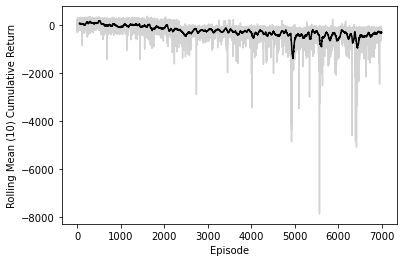

In [17]:
df = pd.DataFrame(history.history)
ax = df['episode_reward'].plot(color = 'lightgray')
df['episode_reward'].rolling(50).mean().plot(color = 'black')
ax.set_xlabel("Episode")
plt.ylabel("Rolling Mean (10) Cumulative Return")
plt.show()

The longer training time didn't do much for the model. The average has remained pretty steady, and we still see som ebig negative numbers even closer to the end of training.

In [18]:
df.to_csv('lunar_training_weights_5')

I decided to see if longer training would have a similar result with a window size of 4.

In [72]:
rl['Model 6'] = [4, '128/64/32', 2000000, 50000, 500, None]

In [270]:
model = Sequential()
#input_shape of four, to mirror window length
model.add(Flatten(input_shape=(4,) + env.observation_space.shape)) 
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32)) 
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_40 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_160 (Dense)            (None, 128)               4224      
_________________________________________________________________
activation_160 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_161 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_162 (Dense)            (None, 32)                2080      
_________________________________________________________________
activation_162 (Activation)  (None, 32)              

In [271]:
memory = SequentialMemory(limit=50000, window_length=4)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=30,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [21]:
# weights_filename = f'dqn_lunar_weights_six.h5f'
checkpoint_weights_filename = 'dqn_lunar_weights_{step}.h5f'
log_filename = f'dqn_lunar_log.json'
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
start_time = time.time()
history = dqn.fit(env, callbacks=callbacks, nb_steps=2000000, log_interval=500)
end_time = time.time()

Training for 2000000 steps ...
Interval 1 (0 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.1308
4 episodes - episode_reward: -368.012 [-651.725, -21.285] - loss: 46.666 - mae: 9.730 - mean_q: -4.722

Interval 2 (500 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -2.4911
5 episodes - episode_reward: -263.724 [-495.612, -151.052] - loss: 36.090 - mae: 12.137 - mean_q: -8.407

Interval 3 (1000 steps performed)
500/500 [==============================] - 2s 4ms/step - reward: -3.3767
5 episodes - episode_reward: -330.986 [-615.214, -97.230] - loss: 26.944 - mae: 13.228 - mean_q: -9.012

Interval 4 (1500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -2.0701
4 episodes - episode_reward: -272.253 [-398.641, -180.586] - loss: 15.947 - mae: 16.375 - mean_q: -13.281

Interval 5 (2000 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -1.2415
4 episodes - epi

Interval 64 (31500 steps performed)
500/500 [==============================] - 14s 28ms/step - reward: -0.1767
Interval 65 (32000 steps performed)
500/500 [==============================] - 14s 28ms/step - reward: -0.1648
Interval 66 (32500 steps performed)
500/500 [==============================] - 15s 30ms/step - reward: -0.2060
Interval 67 (33000 steps performed)
500/500 [==============================] - 15s 29ms/step - reward: -0.1702
Interval 68 (33500 steps performed)
500/500 [==============================] - 15s 29ms/step - reward: -0.1477
Interval 69 (34000 steps performed)
500/500 [==============================] - 15s 30ms/step - reward: -0.1429
Interval 70 (34500 steps performed)
500/500 [==============================] - 16s 31ms/step - reward: -0.1781
Interval 71 (35000 steps performed)
500/500 [==============================] - 16s 33ms/step - reward: -0.2082
Interval 72 (35500 steps performed)
500/500 [==============================] - 17s 34ms/step - reward: -0.1815
I

Interval 136 (67500 steps performed)
500/500 [==============================] - 18s 36ms/step - reward: -0.1853
Interval 137 (68000 steps performed)
500/500 [==============================] - 18s 37ms/step - reward: -0.1606
Interval 138 (68500 steps performed)
500/500 [==============================] - 18s 37ms/step - reward: -0.1772
Interval 139 (69000 steps performed)
500/500 [==============================] - 19s 37ms/step - reward: -0.1805
Interval 140 (69500 steps performed)
500/500 [==============================] - 19s 37ms/step - reward: -0.2049
Interval 141 (70000 steps performed)
500/500 [==============================] - 19s 39ms/step - reward: -0.1586
Interval 142 (70500 steps performed)
500/500 [==============================] - 20s 39ms/step - reward: -0.2061
Interval 143 (71000 steps performed)
500/500 [==============================] - 20s 40ms/step - reward: -0.1956
Interval 144 (71500 steps performed)
500/500 [==============================] - 20s 41ms/step - reward: 

500/500 [==============================] - 3s 5ms/step - reward: -0.0069
1 episodes - episode_reward: -94.942 [-94.942, -94.942] - loss: 7.382 - mae: 28.788 - mean_q: 36.429

Interval 239 (119000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.1117
Interval 240 (119500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.5361
1 episodes - episode_reward: 227.168 [227.168, 227.168] - loss: 6.636 - mae: 28.765 - mean_q: 36.488

Interval 241 (120000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3497
1 episodes - episode_reward: 268.180 [268.180, 268.180] - loss: 6.387 - mae: 28.880 - mean_q: 36.597

Interval 242 (120500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3175
1 episodes - episode_reward: 207.638 [207.638, 207.638] - loss: 7.399 - mae: 28.642 - mean_q: 36.364

Interval 243 (121000 steps performed)
500/500 [==============================] 

500/500 [==============================] - 3s 6ms/step - reward: -0.0687
Interval 327 (163000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0126
Interval 328 (163500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.6145
2 episodes - episode_reward: 216.904 [215.872, 217.936] - loss: 7.927 - mae: 39.574 - mean_q: 51.782

Interval 329 (164000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.4233
1 episodes - episode_reward: 210.530 [210.530, 210.530] - loss: 4.697 - mae: 39.565 - mean_q: 51.551

Interval 330 (164500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.1840
Interval 331 (165000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.1468
2 episodes - episode_reward: 67.382 [-52.286, 187.049] - loss: 6.648 - mae: 39.955 - mean_q: 52.411

Interval 332 (165500 steps performed)
500/500 [=========================

500/500 [==============================] - 3s 5ms/step - reward: -0.5054
4 episodes - episode_reward: -52.740 [-148.381, 43.187] - loss: 7.115 - mae: 48.475 - mean_q: 64.106

Interval 411 (205000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.4923
2 episodes - episode_reward: 105.539 [-4.810, 215.889] - loss: 9.944 - mae: 48.418 - mean_q: 63.906

Interval 412 (205500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3200
1 episodes - episode_reward: 162.554 [162.554, 162.554] - loss: 9.589 - mae: 47.919 - mean_q: 63.411

Interval 413 (206000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.0694
1 episodes - episode_reward: -43.233 [-43.233, -43.233] - loss: 8.449 - mae: 48.049 - mean_q: 63.643

Interval 414 (206500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.4189
1 episodes - episode_reward: 267.276 [267.276, 267.276] - loss: 6.932 - mae: 48.

500/500 [==============================] - 3s 5ms/step - reward: 0.3533
1 episodes - episode_reward: 199.621 [199.621, 199.621] - loss: 8.102 - mae: 47.299 - mean_q: 62.192

Interval 455 (227000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.4569
1 episodes - episode_reward: 176.077 [176.077, 176.077] - loss: 7.136 - mae: 47.553 - mean_q: 62.491

Interval 456 (227500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.7694
2 episodes - episode_reward: 233.095 [221.233, 244.957] - loss: 6.741 - mae: 47.243 - mean_q: 62.089

Interval 457 (228000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.0338
3 episodes - episode_reward: 13.806 [-128.824, 270.243] - loss: 9.143 - mae: 47.866 - mean_q: 63.079

Interval 458 (228500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1879
3 episodes - episode_reward: 19.461 [-111.878, 258.818] - loss: 8.771 - mae: 48.

500/500 [==============================] - 3s 5ms/step - reward: 0.3739
2 episodes - episode_reward: 107.058 [-22.412, 236.528] - loss: 7.015 - mae: 50.446 - mean_q: 65.576

Interval 535 (267000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.3979
3 episodes - episode_reward: 29.736 [-118.335, 250.509] - loss: 11.071 - mae: 50.660 - mean_q: 65.380

Interval 536 (267500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.4164
3 episodes - episode_reward: -39.766 [-162.744, 190.831] - loss: 6.158 - mae: 50.426 - mean_q: 65.528

Interval 537 (268000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.4287
1 episodes - episode_reward: 223.305 [223.305, 223.305] - loss: 8.670 - mae: 50.530 - mean_q: 65.327

Interval 538 (268500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.3048
1 episodes - episode_reward: 146.742 [146.742, 146.742] - loss: 6.225 - mae: 

500/500 [==============================] - 3s 5ms/step - reward: -0.1430
2 episodes - episode_reward: 80.471 [-100.000, 260.942] - loss: 10.494 - mae: 54.412 - mean_q: 69.715

Interval 575 (287000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.4365
2 episodes - episode_reward: -207.572 [-299.652, -115.492] - loss: 9.333 - mae: 54.405 - mean_q: 69.046

Interval 576 (287500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1811
2 episodes - episode_reward: 32.201 [-161.363, 225.765] - loss: 14.445 - mae: 54.415 - mean_q: 69.711

Interval 577 (288000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3869
1 episodes - episode_reward: 155.087 [155.087, 155.087] - loss: 9.879 - mae: 54.514 - mean_q: 70.553

Interval 578 (288500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2437
2 episodes - episode_reward: -64.502 [-244.601, 115.597] - loss: 10.316

500/500 [==============================] - 3s 5ms/step - reward: 0.0137
Interval 615 (307000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.6090
1 episodes - episode_reward: 239.376 [239.376, 239.376] - loss: 6.165 - mae: 49.098 - mean_q: 64.060

Interval 616 (307500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.1755
2 episodes - episode_reward: 99.521 [-127.594, 326.635] - loss: 8.235 - mae: 49.452 - mean_q: 63.730

Interval 617 (308000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.4745
1 episodes - episode_reward: 253.110 [253.110, 253.110] - loss: 9.257 - mae: 49.062 - mean_q: 63.691

Interval 618 (308500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.4549
1 episodes - episode_reward: 192.748 [192.748, 192.748] - loss: 8.704 - mae: 48.832 - mean_q: 63.422

Interval 619 (309000 steps performed)
500/500 [==============================] -

500/500 [==============================] - 3s 5ms/step - reward: 0.7926
2 episodes - episode_reward: 233.693 [223.742, 243.643] - loss: 9.633 - mae: 48.494 - mean_q: 63.209

Interval 656 (327500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2338
Interval 657 (328000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3930
1 episodes - episode_reward: 284.849 [284.849, 284.849] - loss: 7.719 - mae: 48.343 - mean_q: 62.968

Interval 658 (328500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.7566
2 episodes - episode_reward: 213.110 [201.097, 225.123] - loss: 5.683 - mae: 48.067 - mean_q: 62.812

Interval 659 (329000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.7248
3 episodes - episode_reward: 147.959 [-107.741, 298.992] - loss: 8.233 - mae: 47.854 - mean_q: 62.425

Interval 660 (329500 steps performed)
500/500 [==============================] 

500/500 [==============================] - 3s 6ms/step - reward: 0.5917
1 episodes - episode_reward: 277.025 [277.025, 277.025] - loss: 6.495 - mae: 48.201 - mean_q: 62.632

Interval 697 (348000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.8344
2 episodes - episode_reward: 213.579 [198.383, 228.776] - loss: 7.072 - mae: 48.440 - mean_q: 63.020

Interval 698 (348500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.3978
2 episodes - episode_reward: 82.629 [-58.213, 223.471] - loss: 7.112 - mae: 48.644 - mean_q: 63.480

Interval 699 (349000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.0802
3 episodes - episode_reward: 50.221 [-55.135, 223.163] - loss: 8.239 - mae: 48.775 - mean_q: 63.509

Interval 700 (349500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.6939
1 episodes - episode_reward: 244.271 [244.271, 244.271] - loss: 7.752 - mae: 48.60

500/500 [==============================] - 3s 6ms/step - reward: -0.2193
3 episodes - episode_reward: -42.423 [-238.981, 211.712] - loss: 7.694 - mae: 49.730 - mean_q: 65.542

Interval 739 (369000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.4856
1 episodes - episode_reward: 181.012 [181.012, 181.012] - loss: 10.289 - mae: 49.421 - mean_q: 65.143

Interval 740 (369500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.7422
1 episodes - episode_reward: 226.208 [226.208, 226.208] - loss: 10.091 - mae: 49.497 - mean_q: 65.026

Interval 741 (370000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.4097
1 episodes - episode_reward: 312.853 [312.853, 312.853] - loss: 9.012 - mae: 49.271 - mean_q: 64.798

Interval 742 (370500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1511
Interval 743 (371000 steps performed)
500/500 [=============================

500/500 [==============================] - 3s 6ms/step - reward: 0.1035
Interval 823 (411000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.2993
1 episodes - episode_reward: 215.908 [215.908, 215.908] - loss: 12.173 - mae: 44.118 - mean_q: 56.988

Interval 824 (411500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.5753
5 episodes - episode_reward: -54.994 [-150.655, 202.323] - loss: 11.579 - mae: 44.743 - mean_q: 57.680

Interval 825 (412000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2322
Interval 826 (412500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3999
1 episodes - episode_reward: 212.554 [212.554, 212.554] - loss: 9.027 - mae: 44.990 - mean_q: 58.405

Interval 827 (413000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0921
3 episodes - episode_reward: 19.757 [-121.622, 184.079] - loss: 8.9

500/500 [==============================] - 3s 5ms/step - reward: 0.1735
2 episodes - episode_reward: -16.550 [-318.835, 285.736] - loss: 9.302 - mae: 48.709 - mean_q: 62.146

Interval 907 (453000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.6466
1 episodes - episode_reward: 272.885 [272.885, 272.885] - loss: 10.915 - mae: 48.942 - mean_q: 63.217

Interval 908 (453500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.1431
2 episodes - episode_reward: 71.563 [-100.000, 243.125] - loss: 11.113 - mae: 48.891 - mean_q: 62.766

Interval 909 (454000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.5644
3 episodes - episode_reward: -106.094 [-176.905, -4.762] - loss: 11.941 - mae: 48.432 - mean_q: 62.521

Interval 910 (454500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.0394
2 episodes - episode_reward: 21.923 [-114.601, 158.446] - loss: 12.332 - 

500/500 [==============================] - 3s 5ms/step - reward: 0.3314
1 episodes - episode_reward: 260.039 [260.039, 260.039] - loss: 11.076 - mae: 51.867 - mean_q: 67.081

Interval 991 (495000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.8545
2 episodes - episode_reward: 231.751 [213.894, 249.609] - loss: 10.865 - mae: 52.184 - mean_q: 67.672

Interval 992 (495500 steps performed)
500/500 [==============================] - 2s 5ms/step - reward: -0.6176
4 episodes - episode_reward: -77.778 [-137.573, 16.717] - loss: 9.870 - mae: 52.011 - mean_q: 67.428

Interval 993 (496000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.1526
1 episodes - episode_reward: -73.107 [-73.107, -73.107] - loss: 12.169 - mae: 52.717 - mean_q: 68.067

Interval 994 (496500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.0012
2 episodes - episode_reward: 98.311 [-69.676, 266.297] - loss: 12.924 - mae:

500/500 [==============================] - 3s 6ms/step - reward: 0.2315
Interval 1033 (516000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2158
1 episodes - episode_reward: 261.680 [261.680, 261.680] - loss: 15.900 - mae: 50.395 - mean_q: 65.460

Interval 1034 (516500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.7562
1 episodes - episode_reward: -345.638 [-345.638, -345.638] - loss: 15.451 - mae: 50.134 - mean_q: 65.046

Interval 1035 (517000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.3223
1 episodes - episode_reward: -210.965 [-210.965, -210.965] - loss: 14.147 - mae: 49.823 - mean_q: 65.061

Interval 1036 (517500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.1449
1 episodes - episode_reward: -107.448 [-107.448, -107.448] - loss: 13.663 - mae: 49.329 - mean_q: 63.974

Interval 1037 (518000 steps performed)
500/500 [============

Interval 1076 (537500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.0832
Interval 1077 (538000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.5321
1 episodes - episode_reward: 101.729 [101.729, 101.729] - loss: 11.432 - mae: 49.823 - mean_q: 63.829

Interval 1078 (538500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.6038
1 episodes - episode_reward: 218.228 [218.228, 218.228] - loss: 12.094 - mae: 49.738 - mean_q: 64.148

Interval 1079 (539000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.7363
2 episodes - episode_reward: 273.733 [247.472, 299.995] - loss: 16.675 - mae: 49.407 - mean_q: 63.601

Interval 1080 (539500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.1067
2 episodes - episode_reward: -22.923 [-72.805, 26.960] - loss: 12.570 - mae: 49.051 - mean_q: 63.199

Interval 1081 (540000 steps perf

500/500 [==============================] - 3s 5ms/step - reward: -0.2623
2 episodes - episode_reward: -61.095 [-99.155, -23.034] - loss: 12.485 - mae: 40.369 - mean_q: 51.898

Interval 1120 (559500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2238
Interval 1121 (560000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1810
1 episodes - episode_reward: -145.959 [-145.959, -145.959] - loss: 13.334 - mae: 39.271 - mean_q: 50.119

Interval 1122 (560500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.4352
3 episodes - episode_reward: -100.201 [-343.576, 235.927] - loss: 11.913 - mae: 38.977 - mean_q: 49.735

Interval 1123 (561000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.1001
Interval 1124 (561500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2206
1 episodes - episode_reward: -148.577 [-148.577, -148

500/500 [==============================] - 3s 6ms/step - reward: 0.2334
Interval 1167 (583000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3041
1 episodes - episode_reward: 161.825 [161.825, 161.825] - loss: 9.882 - mae: 42.140 - mean_q: 54.030

Interval 1168 (583500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1635
1 episodes - episode_reward: 125.284 [125.284, 125.284] - loss: 10.676 - mae: 42.644 - mean_q: 54.998

Interval 1169 (584000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.6696
4 episodes - episode_reward: -107.969 [-141.666, -65.797] - loss: 12.330 - mae: 42.608 - mean_q: 54.809

Interval 1170 (584500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0394
Interval 1171 (585000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.6716
2 episodes - episode_reward: 196.902 [196.458, 197.346] - los

500/500 [==============================] - 3s 6ms/step - reward: 0.1470
3 episodes - episode_reward: -16.341 [-134.532, 189.603] - loss: 13.083 - mae: 40.518 - mean_q: 50.527

Interval 1212 (605500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.0406
2 episodes - episode_reward: 71.972 [-101.726, 245.669] - loss: 9.851 - mae: 40.015 - mean_q: 50.244

Interval 1213 (606000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0228
Interval 1214 (606500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0019
Interval 1215 (607000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.2024
1 episodes - episode_reward: 98.861 [98.861, 98.861] - loss: 9.577 - mae: 40.659 - mean_q: 50.812

Interval 1216 (607500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.4349
1 episodes - episode_reward: 213.251 [213.251, 213.251] - loss: 10.

500/500 [==============================] - 3s 5ms/step - reward: 0.3636
2 episodes - episode_reward: 73.211 [-104.506, 250.927] - loss: 11.181 - mae: 41.900 - mean_q: 52.716

Interval 1256 (627500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.8248
2 episodes - episode_reward: 227.025 [161.856, 292.193] - loss: 9.367 - mae: 41.896 - mean_q: 52.605

Interval 1257 (628000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.3172
Interval 1258 (628500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.3832
1 episodes - episode_reward: 261.672 [261.672, 261.672] - loss: 9.669 - mae: 41.704 - mean_q: 52.488

Interval 1259 (629000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.6090
4 episodes - episode_reward: -27.641 [-166.056, 193.257] - loss: 11.756 - mae: 41.601 - mean_q: 52.397

Interval 1260 (629500 steps performed)
500/500 [========================

500/500 [==============================] - 3s 7ms/step - reward: 0.5073
1 episodes - episode_reward: 182.897 [182.897, 182.897] - loss: 13.355 - mae: 47.147 - mean_q: 57.577

Interval 1296 (647500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.0731
1 episodes - episode_reward: -16.417 [-16.417, -16.417] - loss: 13.394 - mae: 47.691 - mean_q: 58.261

Interval 1297 (648000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.1975
1 episodes - episode_reward: 233.233 [233.233, 233.233] - loss: 14.973 - mae: 47.699 - mean_q: 58.283

Interval 1298 (648500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.2913
Interval 1299 (649000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.1675
4 episodes - episode_reward: 2.320 [-122.960, 191.730] - loss: 14.253 - mae: 47.834 - mean_q: 59.235

Interval 1300 (649500 steps performed)
500/500 [========================

500/500 [==============================] - 3s 7ms/step - reward: -0.0572
2 episodes - episode_reward: 48.471 [-100.000, 196.942] - loss: 14.190 - mae: 48.162 - mean_q: 57.201

Interval 1339 (669000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.1474
1 episodes - episode_reward: -169.695 [-169.695, -169.695] - loss: 15.107 - mae: 48.676 - mean_q: 58.212

Interval 1340 (669500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.2583
1 episodes - episode_reward: 271.366 [271.366, 271.366] - loss: 13.636 - mae: 47.952 - mean_q: 58.376

Interval 1341 (670000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.4639
1 episodes - episode_reward: 204.690 [204.690, 204.690] - loss: 13.259 - mae: 48.400 - mean_q: 58.805

Interval 1342 (670500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.3104
3 episodes - episode_reward: -50.630 [-212.137, 172.816] - loss: 13

500/500 [==============================] - 3s 6ms/step - reward: -0.9461
4 episodes - episode_reward: -150.353 [-251.211, 14.870] - loss: 15.218 - mae: 52.107 - mean_q: 62.792

Interval 1381 (690000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.6797
3 episodes - episode_reward: -141.642 [-146.278, -137.084] - loss: 21.375 - mae: 52.530 - mean_q: 62.900

Interval 1382 (690500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.3116
2 episodes - episode_reward: -125.070 [-125.895, -124.245] - loss: 13.866 - mae: 52.331 - mean_q: 62.653

Interval 1383 (691000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.0416
Interval 1384 (691500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.4407
1 episodes - episode_reward: 241.968 [241.968, 241.968] - loss: 16.518 - mae: 52.117 - mean_q: 62.641

Interval 1385 (692000 steps performed)
500/500 [=============

500/500 [==============================] - 3s 5ms/step - reward: 0.3469
2 episodes - episode_reward: 112.648 [20.973, 204.324] - loss: 12.415 - mae: 46.802 - mean_q: 58.368

Interval 1426 (712500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.0457
1 episodes - episode_reward: -46.482 [-46.482, -46.482] - loss: 16.522 - mae: 46.925 - mean_q: 58.258

Interval 1427 (713000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.5298
1 episodes - episode_reward: 182.730 [182.730, 182.730] - loss: 15.211 - mae: 46.561 - mean_q: 58.488

Interval 1428 (713500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2498
1 episodes - episode_reward: 233.902 [233.902, 233.902] - loss: 10.252 - mae: 45.869 - mean_q: 58.132

Interval 1429 (714000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.0526
Interval 1430 (714500 steps performed)
500/500 [=========================

500/500 [==============================] - 3s 5ms/step - reward: -0.2640
3 episodes - episode_reward: -48.771 [-112.920, -0.608] - loss: 11.182 - mae: 39.941 - mean_q: 50.623

Interval 1470 (734500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.1924
2 episodes - episode_reward: -66.646 [-68.130, -65.162] - loss: 13.310 - mae: 39.641 - mean_q: 50.200

Interval 1471 (735000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.7509
2 episodes - episode_reward: 215.833 [193.827, 237.839] - loss: 15.263 - mae: 39.038 - mean_q: 49.327

Interval 1472 (735500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.4988
2 episodes - episode_reward: -193.589 [-269.659, -117.520] - loss: 12.508 - mae: 39.289 - mean_q: 49.633

Interval 1473 (736000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.2660
1 episodes - episode_reward: 215.033 [215.033, 215.033] - loss: 12

500/500 [==============================] - 3s 6ms/step - reward: 0.1338
1 episodes - episode_reward: 199.285 [199.285, 199.285] - loss: 14.206 - mae: 45.680 - mean_q: 56.927

Interval 1555 (777000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.1218
1 episodes - episode_reward: -172.138 [-172.138, -172.138] - loss: 13.537 - mae: 45.593 - mean_q: 56.351

Interval 1556 (777500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0264
Interval 1557 (778000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0301
Interval 1558 (778500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.3421
1 episodes - episode_reward: 112.250 [112.250, 112.250] - loss: 12.214 - mae: 44.701 - mean_q: 56.295

Interval 1559 (779000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1239
Interval 1560 (779500 steps performed)
500/500 [==========

500/500 [==============================] - 3s 5ms/step - reward: 0.5072
1 episodes - episode_reward: 206.029 [206.029, 206.029] - loss: 8.994 - mae: 41.230 - mean_q: 51.913

Interval 1600 (799500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.4054
1 episodes - episode_reward: 187.983 [187.983, 187.983] - loss: 11.029 - mae: 41.399 - mean_q: 51.704

Interval 1601 (800000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.4258
1 episodes - episode_reward: 227.497 [227.497, 227.497] - loss: 8.006 - mae: 41.285 - mean_q: 51.884

Interval 1602 (800500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.2639
1 episodes - episode_reward: -135.658 [-135.658, -135.658] - loss: 7.471 - mae: 41.307 - mean_q: 52.261

Interval 1603 (801000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.0395
1 episodes - episode_reward: -90.769 [-90.769, -90.769] - loss: 13.021

500/500 [==============================] - 3s 5ms/step - reward: -0.1252
1 episodes - episode_reward: -173.589 [-173.589, -173.589] - loss: 9.856 - mae: 40.963 - mean_q: 53.180

Interval 1640 (819500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.3703
2 episodes - episode_reward: 30.090 [-112.993, 173.173] - loss: 8.688 - mae: 40.960 - mean_q: 53.218

Interval 1641 (820000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0235
Interval 1642 (820500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.0114
1 episodes - episode_reward: 187.449 [187.449, 187.449] - loss: 8.736 - mae: 40.787 - mean_q: 53.075

Interval 1643 (821000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0323
1 episodes - episode_reward: -99.568 [-99.568, -99.568] - loss: 11.104 - mae: 41.517 - mean_q: 53.717

Interval 1644 (821500 steps performed)
500/500 [=====================

500/500 [==============================] - 3s 5ms/step - reward: -0.0179
2 episodes - episode_reward: 7.395 [-192.335, 207.126] - loss: 10.600 - mae: 42.013 - mean_q: 52.512

Interval 1724 (861500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.1988
3 episodes - episode_reward: 21.005 [-134.576, 246.749] - loss: 9.871 - mae: 41.572 - mean_q: 52.251

Interval 1725 (862000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0229
Interval 1726 (862500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2531
1 episodes - episode_reward: 188.802 [188.802, 188.802] - loss: 7.868 - mae: 41.699 - mean_q: 52.617

Interval 1727 (863000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.1133
3 episodes - episode_reward: 4.383 [-161.126, 210.111] - loss: 11.684 - mae: 41.414 - mean_q: 51.803

Interval 1728 (863500 steps performed)
500/500 [==========================

500/500 [==============================] - 3s 5ms/step - reward: -0.1576
2 episodes - episode_reward: -107.184 [-116.789, -97.579] - loss: 15.014 - mae: 42.616 - mean_q: 52.372

Interval 1807 (903000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.0258
1 episodes - episode_reward: 206.846 [206.846, 206.846] - loss: 11.742 - mae: 42.400 - mean_q: 51.787

Interval 1808 (903500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.3410
1 episodes - episode_reward: -232.204 [-232.204, -232.204] - loss: 10.893 - mae: 42.443 - mean_q: 52.628

Interval 1809 (904000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.4954
1 episodes - episode_reward: -264.352 [-264.352, -264.352] - loss: 13.324 - mae: 42.105 - mean_q: 52.005

Interval 1810 (904500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.6116
1 episodes - episode_reward: -318.257 [-318.257, -318.257] -

500/500 [==============================] - 3s 5ms/step - reward: -0.9352
3 episodes - episode_reward: -141.902 [-196.435, -100.000] - loss: 9.912 - mae: 40.898 - mean_q: 51.076

Interval 1850 (924500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.9149
2 episodes - episode_reward: -251.025 [-360.299, -141.750] - loss: 11.903 - mae: 40.670 - mean_q: 50.609

Interval 1851 (925000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.1891
1 episodes - episode_reward: 140.384 [140.384, 140.384] - loss: 13.257 - mae: 41.012 - mean_q: 50.716

Interval 1852 (925500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.2420
Interval 1853 (926000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.1559
1 episodes - episode_reward: 262.550 [262.550, 262.550] - loss: 12.578 - mae: 40.017 - mean_q: 49.174

Interval 1854 (926500 steps performed)
500/500 [=================

500/500 [==============================] - 3s 5ms/step - reward: 0.3889
1 episodes - episode_reward: 218.109 [218.109, 218.109] - loss: 8.059 - mae: 39.828 - mean_q: 50.748

Interval 1894 (946500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2097
3 episodes - episode_reward: -27.394 [-143.521, 168.866] - loss: 9.757 - mae: 39.811 - mean_q: 50.512

Interval 1895 (947000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.0362
1 episodes - episode_reward: -117.204 [-117.204, -117.204] - loss: 11.216 - mae: 39.702 - mean_q: 50.433

Interval 1896 (947500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.4147
2 episodes - episode_reward: 175.165 [173.697, 176.634] - loss: 9.898 - mae: 39.522 - mean_q: 50.792

Interval 1897 (948000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0958
Interval 1898 (948500 steps performed)
500/500 [=====================

500/500 [==============================] - 3s 5ms/step - reward: -1.0485
4 episodes - episode_reward: -132.893 [-312.872, 2.181] - loss: 29.409 - mae: 48.400 - mean_q: 61.435

Interval 1940 (969500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.2834
6 episodes - episode_reward: -190.710 [-414.312, -3.400] - loss: 36.718 - mae: 56.392 - mean_q: 72.799

Interval 1941 (970000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: 0.3361
2 episodes - episode_reward: 89.705 [23.248, 156.163] - loss: 52.032 - mae: 64.735 - mean_q: 84.101

Interval 1942 (970500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.4358
2 episodes - episode_reward: -110.783 [-118.907, -102.659] - loss: 54.396 - mae: 73.542 - mean_q: 96.170

Interval 1943 (971000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.6735
4 episodes - episode_reward: -84.843 [-150.628, -27.019] - loss: 6

500/500 [==============================] - 3s 5ms/step - reward: -0.9859
Interval 1994 (996500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.0557
2 episodes - episode_reward: -557.411 [-682.734, -432.089] - loss: 66.947 - mae: 248.026 - mean_q: 333.142

Interval 1995 (997000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.6309
1 episodes - episode_reward: -587.612 [-587.612, -587.612] - loss: 66.343 - mae: 244.696 - mean_q: 328.484

Interval 1996 (997500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.9329
Interval 1997 (998000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.3244
1 episodes - episode_reward: -631.372 [-631.372, -631.372] - loss: 64.146 - mae: 238.325 - mean_q: 319.668

Interval 1998 (998500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.5849
Interval 1999 (999000 steps performed)
500/

500/500 [==============================] - 3s 5ms/step - reward: -1.7760
4 episodes - episode_reward: -287.830 [-399.070, -141.251] - loss: 62.075 - mae: 159.445 - mean_q: 210.335

Interval 2037 (1018000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.7617
1 episodes - episode_reward: -230.536 [-230.536, -230.536] - loss: 77.136 - mae: 156.414 - mean_q: 205.933

Interval 2038 (1018500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.1130
1 episodes - episode_reward: -617.835 [-617.835, -617.835] - loss: 59.558 - mae: 155.168 - mean_q: 204.993

Interval 2039 (1019000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1051
Interval 2040 (1019500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.3025
Interval 2041 (1020000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1618
Interval 2042 (1020500 steps performed

500/500 [==============================] - 3s 5ms/step - reward: -0.9686
3 episodes - episode_reward: -205.323 [-393.930, -100.000] - loss: 40.628 - mae: 73.413 - mean_q: 82.351

Interval 2123 (1061000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.5520
Interval 2124 (1061500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.5284
2 episodes - episode_reward: -297.256 [-436.360, -158.152] - loss: 33.683 - mae: 70.515 - mean_q: 78.300

Interval 2125 (1062000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.8451
2 episodes - episode_reward: -376.799 [-552.611, -200.986] - loss: 40.380 - mae: 70.265 - mean_q: 77.901

Interval 2126 (1062500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.9911
3 episodes - episode_reward: -326.646 [-529.858, -144.083] - loss: 35.469 - mae: 70.788 - mean_q: 77.925

Interval 2127 (1063000 steps performed)
500/500 [==

500/500 [==============================] - 3s 6ms/step - reward: -0.3604
Interval 2164 (1081500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.0103
3 episodes - episode_reward: -193.192 [-284.613, -118.526] - loss: 76.266 - mae: 108.133 - mean_q: 130.545

Interval 2165 (1082000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.0912
Interval 2166 (1082500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.1328
Interval 2167 (1083000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2962
Interval 2168 (1083500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: 0.0052
Interval 2169 (1084000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.5033
1 episodes - episode_reward: -618.325 [-618.325, -618.325] - loss: 89.973 - mae: 110.941 - mean_q: 136.636

Interval 2170 (1084500 steps perfo

500/500 [==============================] - 3s 6ms/step - reward: -1.3051
2 episodes - episode_reward: -328.067 [-490.564, -165.571] - loss: 52.178 - mae: 108.875 - mean_q: 126.606

Interval 2253 (1126000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.3172
2 episodes - episode_reward: -229.086 [-317.496, -140.675] - loss: 70.450 - mae: 113.457 - mean_q: 135.294

Interval 2254 (1126500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.8305
3 episodes - episode_reward: -408.226 [-629.767, -174.081] - loss: 50.786 - mae: 115.126 - mean_q: 137.514

Interval 2255 (1127000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.9272
2 episodes - episode_reward: -407.120 [-451.259, -362.980] - loss: 45.952 - mae: 117.253 - mean_q: 140.722

Interval 2256 (1127500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.3975
2 episodes - episode_reward: -289.965 [-476

500/500 [==============================] - 3s 6ms/step - reward: -0.5020
1 episodes - episode_reward: -277.416 [-277.416, -277.416] - loss: 70.920 - mae: 113.847 - mean_q: 127.814

Interval 2339 (1169000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.4573
Interval 2340 (1169500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.0529
Interval 2341 (1170000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.2880
Interval 2342 (1170500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.4999
2 episodes - episode_reward: -533.585 [-538.736, -528.435] - loss: 69.631 - mae: 114.640 - mean_q: 132.027

Interval 2343 (1171000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.5745
2 episodes - episode_reward: -433.232 [-656.205, -210.260] - loss: 66.556 - mae: 115.248 - mean_q: 133.707

Interval 2344 (1171500 steps performed

500/500 [==============================] - 3s 5ms/step - reward: -1.9960
5 episodes - episode_reward: -194.082 [-287.347, -80.047] - loss: 48.918 - mae: 118.951 - mean_q: 145.992

Interval 2386 (1192500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: 0.0861
Interval 2387 (1193000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.2314
Interval 2388 (1193500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.5248
Interval 2389 (1194000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.1359
6 episodes - episode_reward: -244.444 [-536.811, -77.900] - loss: 45.162 - mae: 110.109 - mean_q: 137.871

Interval 2390 (1194500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.9596
5 episodes - episode_reward: -200.889 [-368.894, -104.653] - loss: 38.577 - mae: 108.506 - mean_q: 136.637

Interval 2391 (1195000 steps performed)
5

500/500 [==============================] - 3s 6ms/step - reward: -0.8953
1 episodes - episode_reward: -555.436 [-555.436, -555.436] - loss: 163.480 - mae: 110.645 - mean_q: 124.413

Interval 2463 (1231000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.3153
Interval 2464 (1231500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.0781
Interval 2465 (1232000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.2128
Interval 2466 (1232500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.1307
Interval 2467 (1233000 steps performed)
500/500 [==============================] - 4s 9ms/step - reward: -0.5237
Interval 2468 (1233500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.4830
2 episodes - episode_reward: -403.157 [-661.784, -144.530] - loss: 238.080 - mae: 156.268 - mean_q: 204.057

Interval 2469 (1234000 steps pe

500/500 [==============================] - 3s 5ms/step - reward: -3.2367
1 episodes - episode_reward: -1774.472 [-1774.472, -1774.472] - loss: 1388.495 - mae: 896.289 - mean_q: 1199.490

Interval 2548 (1273500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.2893
Interval 2549 (1274000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.4055
Interval 2550 (1274500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.8622
1 episodes - episode_reward: -2719.138 [-2719.138, -2719.138] - loss: 1296.926 - mae: 849.631 - mean_q: 1131.958

Interval 2551 (1275000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.8881
1 episodes - episode_reward: -1534.685 [-1534.685, -1534.685] - loss: 1317.870 - mae: 844.232 - mean_q: 1124.027

Interval 2552 (1275500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.6909
3 episodes - episode

500/500 [==============================] - 4s 7ms/step - reward: -1.4321
1 episodes - episode_reward: -256.743 [-256.743, -256.743] - loss: 644.551 - mae: 486.102 - mean_q: 637.543

Interval 2590 (1294500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -1.4646
2 episodes - episode_reward: -545.469 [-978.563, -112.374] - loss: 567.577 - mae: 468.443 - mean_q: 612.729

Interval 2591 (1295000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -2.2084
1 episodes - episode_reward: -614.421 [-614.421, -614.421] - loss: 623.435 - mae: 458.976 - mean_q: 598.591

Interval 2592 (1295500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.9587
1 episodes - episode_reward: -987.252 [-987.252, -987.252] - loss: 721.830 - mae: 441.585 - mean_q: 574.548

Interval 2593 (1296000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.1375
1 episodes - episode_reward: -488.325 [

500/500 [==============================] - 3s 6ms/step - reward: -0.2610
Interval 2679 (1339000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.3087
2 episodes - episode_reward: -458.753 [-663.041, -254.464] - loss: 336.504 - mae: 385.746 - mean_q: 503.030

Interval 2680 (1339500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.4239
1 episodes - episode_reward: -189.202 [-189.202, -189.202] - loss: 409.397 - mae: 408.635 - mean_q: 536.029

Interval 2681 (1340000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.9499
3 episodes - episode_reward: -164.374 [-255.812, -104.917] - loss: 405.168 - mae: 425.732 - mean_q: 560.759

Interval 2682 (1340500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.1556
1 episodes - episode_reward: -511.871 [-511.871, -511.871] - loss: 490.922 - mae: 446.860 - mean_q: 590.107

Interval 2683 (1341000 steps performed)

500/500 [==============================] - 3s 6ms/step - reward: -0.3965
Interval 2763 (1381000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.4389
2 episodes - episode_reward: -375.225 [-550.344, -200.105] - loss: 2676.430 - mae: 1119.067 - mean_q: 1494.140

Interval 2764 (1381500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -3.8674
6 episodes - episode_reward: -354.376 [-572.472, -114.992] - loss: 2423.904 - mae: 1111.904 - mean_q: 1485.428

Interval 2765 (1382000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.2506
1 episodes - episode_reward: -498.930 [-498.930, -498.930] - loss: 2650.820 - mae: 1118.922 - mean_q: 1494.642

Interval 2766 (1382500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.9939
1 episodes - episode_reward: -463.983 [-463.983, -463.983] - loss: 2430.353 - mae: 1117.073 - mean_q: 1491.240

Interval 2767 (1383000 step

500/500 [==============================] - 3s 5ms/step - reward: -1.3698
1 episodes - episode_reward: -145.620 [-145.620, -145.620] - loss: 5071.533 - mae: 1372.472 - mean_q: 1809.188

Interval 2851 (1425000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.2545
1 episodes - episode_reward: -535.087 [-535.087, -535.087] - loss: 4842.904 - mae: 1378.565 - mean_q: 1821.123

Interval 2852 (1425500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.7306
4 episodes - episode_reward: -331.676 [-359.411, -291.970] - loss: 4536.392 - mae: 1350.525 - mean_q: 1785.390

Interval 2853 (1426000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.4868
1 episodes - episode_reward: -448.918 [-448.918, -448.918] - loss: 6049.103 - mae: 1369.323 - mean_q: 1811.085

Interval 2854 (1426500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.6848
1 episodes - episode_reward

500/500 [==============================] - 3s 5ms/step - reward: -3.2435
2 episodes - episode_reward: -658.027 [-707.734, -608.319] - loss: 15133.646 - mae: 2696.139 - mean_q: 3621.331

Interval 2889 (1444000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.1710
3 episodes - episode_reward: -556.668 [-793.390, -146.048] - loss: 12343.810 - mae: 2680.927 - mean_q: 3603.075

Interval 2890 (1444500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -4.2396
4 episodes - episode_reward: -521.001 [-863.414, -193.818] - loss: 14927.087 - mae: 2744.374 - mean_q: 3691.008

Interval 2891 (1445000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -4.0132
3 episodes - episode_reward: -752.579 [-1235.086, -381.818] - loss: 14157.429 - mae: 2700.744 - mean_q: 3633.345

Interval 2892 (1445500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.3657
3 episodes - episode_r

500/500 [==============================] - 3s 5ms/step - reward: -3.7256
6 episodes - episode_reward: -284.463 [-395.906, -100.000] - loss: 29673.162 - mae: 3851.352 - mean_q: 5197.989

Interval 2964 (1481500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.5990
4 episodes - episode_reward: -479.213 [-727.230, -293.747] - loss: 28318.801 - mae: 3806.574 - mean_q: 5143.731

Interval 2965 (1482000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.7831
4 episodes - episode_reward: -433.383 [-481.609, -402.098] - loss: 44308.492 - mae: 3785.970 - mean_q: 5122.215

Interval 2966 (1482500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -3.9694
5 episodes - episode_reward: -432.517 [-644.127, -138.743] - loss: 52604.734 - mae: 3763.441 - mean_q: 5093.984

Interval 2967 (1483000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.2597
2 episodes - episode_re

500/500 [==============================] - 3s 5ms/step - reward: -2.2516
3 episodes - episode_reward: -379.752 [-645.726, -183.059] - loss: 90876.922 - mae: 3961.707 - mean_q: 5305.274

Interval 3037 (1518000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.8514
1 episodes - episode_reward: -80.770 [-80.770, -80.770] - loss: 155964.812 - mae: 3975.488 - mean_q: 5326.979

Interval 3038 (1518500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.7671
4 episodes - episode_reward: -296.699 [-440.464, -51.041] - loss: 95107.555 - mae: 3964.034 - mean_q: 5318.543

Interval 3039 (1519000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.6236
2 episodes - episode_reward: -198.558 [-277.052, -120.063] - loss: 97180.742 - mae: 3913.540 - mean_q: 5261.400

Interval 3040 (1519500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.2142
2 episodes - episode_rewar

500/500 [==============================] - 3s 5ms/step - reward: -1.6943
4 episodes - episode_reward: -169.664 [-301.451, -107.044] - loss: 88293.906 - mae: 4942.218 - mean_q: 6731.418

Interval 3077 (1538000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.0367
2 episodes - episode_reward: -237.017 [-342.525, -131.509] - loss: 91744.016 - mae: 5118.417 - mean_q: 6959.650

Interval 3078 (1538500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.8048
2 episodes - episode_reward: -501.608 [-520.719, -482.498] - loss: 91066.539 - mae: 5234.458 - mean_q: 7106.916

Interval 3079 (1539000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.2894
4 episodes - episode_reward: -283.094 [-343.497, -222.434] - loss: 88191.844 - mae: 5132.587 - mean_q: 6967.235

Interval 3080 (1539500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.4346
Interval 3081 (1540000 

500/500 [==============================] - 3s 6ms/step - reward: -1.7069
2 episodes - episode_reward: -518.769 [-536.379, -501.159] - loss: 94396.953 - mae: 6046.386 - mean_q: 8144.042

Interval 3117 (1558000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.5882
2 episodes - episode_reward: -376.904 [-653.808, -100.000] - loss: 87123.477 - mae: 6031.022 - mean_q: 8119.616

Interval 3118 (1558500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.1346
1 episodes - episode_reward: -200.871 [-200.871, -200.871] - loss: 100090.758 - mae: 5943.354 - mean_q: 7992.214

Interval 3119 (1559000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.6909
2 episodes - episode_reward: -736.347 [-989.061, -483.633] - loss: 94661.547 - mae: 5971.996 - mean_q: 8036.292

Interval 3120 (1559500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.7500
2 episodes - episode_r

3 episodes - episode_reward: -519.047 [-1081.359, -180.198] - loss: 411298.812 - mae: 13870.076 - mean_q: 18934.100

Interval 3189 (1594000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -3.0397
1 episodes - episode_reward: -1464.493 [-1464.493, -1464.493] - loss: 565836.875 - mae: 14079.231 - mean_q: 19203.840

Interval 3190 (1594500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -3.1855
1 episodes - episode_reward: -1393.315 [-1393.315, -1393.315] - loss: 415282.469 - mae: 14169.426 - mean_q: 19344.078

Interval 3191 (1595000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.3335
1 episodes - episode_reward: -1126.072 [-1126.072, -1126.072] - loss: 553072.938 - mae: 14150.071 - mean_q: 19294.047

Interval 3192 (1595500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.4010
2 episodes - episode_reward: -758.276 [-1429.316, -87.237] - loss: 607532.

500/500 [==============================] - 3s 6ms/step - reward: -1.5064
1 episodes - episode_reward: -866.615 [-866.615, -866.615] - loss: 334483.562 - mae: 15144.940 - mean_q: 20507.820

Interval 3226 (1612500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -0.2827
Interval 3227 (1613000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -1.4460
1 episodes - episode_reward: -1187.771 [-1187.771, -1187.771] - loss: 340912.000 - mae: 14727.033 - mean_q: 19972.312

Interval 3228 (1613500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.0358
1 episodes - episode_reward: -497.303 [-497.303, -497.303] - loss: 302883.562 - mae: 14551.398 - mean_q: 19744.482

Interval 3229 (1614000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -1.8980
2 episodes - episode_reward: -483.570 [-869.299, -97.841] - loss: 309026.969 - mae: 14429.110 - mean_q: 19597.805

Interval 

500/500 [==============================] - 3s 6ms/step - reward: 0.2232
Interval 3273 (1636000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.1041
2 episodes - episode_reward: -518.595 [-686.577, -350.613] - loss: 520516.438 - mae: 17198.189 - mean_q: 23096.680

Interval 3274 (1636500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -0.3373
2 episodes - episode_reward: -150.170 [-163.777, -136.563] - loss: 245912.156 - mae: 16888.811 - mean_q: 22718.561

Interval 3275 (1637000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.4991
Interval 3276 (1637500 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: 0.0578
Interval 3277 (1638000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.2627
Interval 3278 (1638500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: 0.0562
Interval 3279 (16390

500/500 [==============================] - 7s 14ms/step - reward: -0.1733
Interval 3332 (1665500 steps performed)
500/500 [==============================] - 7s 14ms/step - reward: -0.1396
Interval 3333 (1666000 steps performed)
500/500 [==============================] - 7s 15ms/step - reward: -0.1673
Interval 3334 (1666500 steps performed)
500/500 [==============================] - 8s 16ms/step - reward: -0.1528
Interval 3335 (1667000 steps performed)
500/500 [==============================] - 8s 15ms/step - reward: -0.2135
Interval 3336 (1667500 steps performed)
500/500 [==============================] - 5s 9ms/step - reward: -1.2003
1 episodes - episode_reward: -2697.186 [-2697.186, -2697.186] - loss: 799754.062 - mae: 33239.184 - mean_q: 44748.746

Interval 3337 (1668000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -0.1086
Interval 3338 (1668500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -0.1458
Interval 333

500/500 [==============================] - 3s 5ms/step - reward: -1.9946
2 episodes - episode_reward: -459.773 [-553.865, -365.680] - loss: 742634.125 - mae: 52466.219 - mean_q: 70470.742

Interval 3379 (1689000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -4.5484
4 episodes - episode_reward: -644.086 [-1254.142, -270.999] - loss: 689450.125 - mae: 51728.012 - mean_q: 69494.555

Interval 3380 (1689500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.0345
2 episodes - episode_reward: -360.369 [-397.160, -323.578] - loss: 734582.625 - mae: 49784.703 - mean_q: 66920.555

Interval 3381 (1690000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -4.0758
3 episodes - episode_reward: -723.793 [-1531.042, -232.266] - loss: 2636989.000 - mae: 49486.352 - mean_q: 66470.016

Interval 3382 (1690500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.4538
3 episod

500/500 [==============================] - 3s 6ms/step - reward: -1.3029
Interval 3456 (1727500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.3847
3 episodes - episode_reward: -484.888 [-1295.889, -16.197] - loss: 8386719.500 - mae: 43810.879 - mean_q: 59954.574

Interval 3457 (1728000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.8853
2 episodes - episode_reward: -590.747 [-851.897, -329.598] - loss: 8103155.000 - mae: 46040.645 - mean_q: 63056.020

Interval 3458 (1728500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.1588
1 episodes - episode_reward: -225.776 [-225.776, -225.776] - loss: 8905041.000 - mae: 48394.551 - mean_q: 66218.062

Interval 3459 (1729000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -2.4630
2 episodes - episode_reward: -425.940 [-530.352, -321.527] - loss: 7641001.500 - mae: 50862.531 - mean_q: 69614.445

Interva

500/500 [==============================] - 3s 5ms/step - reward: -1.9726
4 episodes - episode_reward: -262.761 [-454.354, -180.897] - loss: 3667508.750 - mae: 67024.883 - mean_q: 90392.680

Interval 3503 (1751000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.7854
4 episodes - episode_reward: -251.018 [-437.494, -169.848] - loss: 6394766.500 - mae: 66176.633 - mean_q: 89174.453

Interval 3504 (1751500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.3782
3 episodes - episode_reward: -277.738 [-371.814, -220.901] - loss: 4085710.250 - mae: 65289.852 - mean_q: 88041.531

Interval 3505 (1752000 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.3361
2 episodes - episode_reward: -308.445 [-455.074, -161.815] - loss: 7696247.500 - mae: 64588.906 - mean_q: 87020.430

Interval 3506 (1752500 steps performed)
500/500 [==============================] - 3s 5ms/step - reward: -1.7844
2 episo

500/500 [==============================] - 3s 7ms/step - reward: -1.0483
1 episodes - episode_reward: -1588.196 [-1588.196, -1588.196] - loss: 6351598.500 - mae: 58643.020 - mean_q: 78938.906

Interval 3578 (1788500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.3602
Interval 3579 (1789000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.9156
2 episodes - episode_reward: -778.327 [-1325.258, -231.397] - loss: 4947735.000 - mae: 57030.336 - mean_q: 76845.727

Interval 3580 (1789500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -1.0390
Interval 3581 (1790000 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.4169
4 episodes - episode_reward: -444.231 [-1120.455, -185.022] - loss: 3217082.250 - mae: 55070.195 - mean_q: 74397.617

Interval 3582 (1790500 steps performed)
500/500 [==============================] - 3s 6ms/step - reward: -2.8221
4 epis

500/500 [==============================] - 4s 8ms/step - reward: -1.9594
3 episodes - episode_reward: -196.751 [-241.185, -135.216] - loss: 2331061.000 - mae: 35947.723 - mean_q: 48313.895

Interval 3663 (1831000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.7007
7 episodes - episode_reward: -318.132 [-738.521, -120.714] - loss: 1624412.250 - mae: 35667.648 - mean_q: 47992.188

Interval 3664 (1831500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -5.5431
8 episodes - episode_reward: -349.261 [-688.102, -100.000] - loss: 5482870.000 - mae: 36474.367 - mean_q: 49037.723

Interval 3665 (1832000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.6609
3 episodes - episode_reward: -589.911 [-933.865, -127.426] - loss: 2555718.000 - mae: 36238.336 - mean_q: 48811.672

Interval 3666 (1832500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.3056
3 episo

500/500 [==============================] - 4s 7ms/step - reward: -6.5315
3 episodes - episode_reward: -1130.065 [-1880.545, -374.480] - loss: 4518162.500 - mae: 36548.547 - mean_q: 49533.859

Interval 3699 (1849000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.1353
2 episodes - episode_reward: -703.741 [-788.795, -618.687] - loss: 3497614.250 - mae: 35578.074 - mean_q: 48215.359

Interval 3700 (1849500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.8655
5 episodes - episode_reward: -296.894 [-591.743, -71.296] - loss: 5109319.500 - mae: 34683.176 - mean_q: 46910.738

Interval 3701 (1850000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.1194
3 episodes - episode_reward: -509.356 [-728.036, -286.352] - loss: 4854302.500 - mae: 35387.281 - mean_q: 47807.254

Interval 3702 (1850500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -4.4342
5 epis

500/500 [==============================] - 4s 8ms/step - reward: -2.0913
1 episodes - episode_reward: -127.465 [-127.465, -127.465] - loss: 4923758.500 - mae: 39361.379 - mean_q: 53498.699

Interval 3737 (1868000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -2.0513
2 episodes - episode_reward: -978.348 [-1737.382, -219.315] - loss: 4975548.500 - mae: 40724.754 - mean_q: 55292.883

Interval 3738 (1868500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -1.8457
2 episodes - episode_reward: -314.714 [-469.266, -160.161] - loss: 7695796.500 - mae: 39513.184 - mean_q: 53665.121

Interval 3739 (1869000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.7241
2 episodes - episode_reward: -746.597 [-1114.138, -379.055] - loss: 5478989.500 - mae: 39793.699 - mean_q: 54161.152

Interval 3740 (1869500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.7192
4 epi

500/500 [==============================] - 9s 18ms/step - reward: -0.3484
Interval 3824 (1911500 steps performed)
500/500 [==============================] - 10s 20ms/step - reward: -0.2357
Interval 3825 (1912000 steps performed)
500/500 [==============================] - 10s 19ms/step - reward: -0.0489
Interval 3826 (1912500 steps performed)
500/500 [==============================] - 5s 11ms/step - reward: -1.0903
1 episodes - episode_reward: -2047.183 [-2047.183, -2047.183] - loss: 8258608.500 - mae: 68718.586 - mean_q: 92302.156

Interval 3827 (1913000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -0.6163
1 episodes - episode_reward: -648.300 [-648.300, -648.300] - loss: 7015750.000 - mae: 68150.438 - mean_q: 91627.805

Interval 3828 (1913500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -4.3648
2 episodes - episode_reward: -1147.984 [-1546.053, -749.914] - loss: 12351014.000 - mae: 66712.727 - mean_q: 89651.445


4 episodes - episode_reward: -491.898 [-1289.743, -117.156] - loss: 31333060.000 - mae: 68947.344 - mean_q: 92764.398

Interval 3862 (1930500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.5507
4 episodes - episode_reward: -373.891 [-449.415, -331.173] - loss: 8628740.000 - mae: 67270.289 - mean_q: 90539.000

Interval 3863 (1931000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -2.7234
1 episodes - episode_reward: -1127.772 [-1127.772, -1127.772] - loss: 13502974.000 - mae: 66863.844 - mean_q: 89930.156

Interval 3864 (1931500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -4.4184
1 episodes - episode_reward: -1690.646 [-1690.646, -1690.646] - loss: 7007007.500 - mae: 65721.688 - mean_q: 88352.258

Interval 3865 (1932000 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -3.4147
3 episodes - episode_reward: -764.433 [-1774.190, -237.662] - loss: 111

500/500 [==============================] - 4s 7ms/step - reward: -3.1061
4 episodes - episode_reward: -428.246 [-478.721, -393.323] - loss: 2506260.000 - mae: 22236.557 - mean_q: 29985.119

Interval 3934 (1966500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.3241
5 episodes - episode_reward: -274.949 [-430.043, -91.830] - loss: 3039063.500 - mae: 22230.574 - mean_q: 29945.072

Interval 3935 (1967000 steps performed)
500/500 [==============================] - 3s 7ms/step - reward: -4.5799
5 episodes - episode_reward: -446.647 [-591.346, -217.190] - loss: 2525572.750 - mae: 22079.725 - mean_q: 29711.027

Interval 3936 (1967500 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.9212
4 episodes - episode_reward: -329.133 [-406.283, -188.758] - loss: 2830541.250 - mae: 21430.002 - mean_q: 28796.729

Interval 3937 (1968000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -2.9843
4 episod

500/500 [==============================] - 4s 8ms/step - reward: -3.4241
3 episodes - episode_reward: -594.408 [-811.613, -202.384] - loss: 2428737.500 - mae: 18785.373 - mean_q: 25456.123

Interval 3970 (1984500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -3.8855
4 episodes - episode_reward: -558.346 [-835.259, -114.750] - loss: 2337150.750 - mae: 18576.455 - mean_q: 25171.807

Interval 3971 (1985000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -3.3313
6 episodes - episode_reward: -247.652 [-702.094, -100.000] - loss: 2250811.500 - mae: 17961.818 - mean_q: 24339.236

Interval 3972 (1985500 steps performed)
500/500 [==============================] - 4s 8ms/step - reward: -4.2634
5 episodes - episode_reward: -441.484 [-1123.797, -100.000] - loss: 2758052.250 - mae: 17755.738 - mean_q: 24008.967

Interval 3973 (1986000 steps performed)
500/500 [==============================] - 4s 7ms/step - reward: -4.3722
5 epis

In [272]:
weights.append(f'dqn_lunar_weights_six.h5f')

In [273]:
models.append(dqn)
models[-1].load_weights(weights[-1])

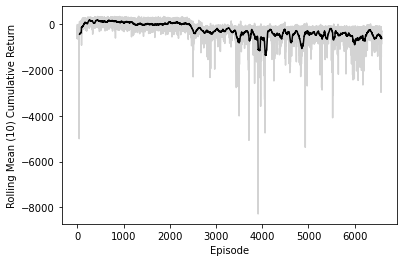

In [23]:
df = pd.DataFrame(history.history)
ax = df['episode_reward'].plot(color = 'lightgray')
df['episode_reward'].rolling(50).mean().plot(color = 'black')
ax.set_xlabel("Episode")
plt.ylabel("Rolling Mean (10) Cumulative Return")
plt.show()

Again, the average hovers around zero, and we are still seeing big negative numbers, near to the end of training. 

In [24]:
df.to_csv('lunar_training_weights_6')

## Increasing Sequential Memory Limit

I felt that the next logical step was to increase memory size, hoping that this would allow the model to better capture some of the complexities of the game. I also increased the log interval, as this felt like a sensible step to take when increasing the sequential memory limit.

In [73]:
rl['Model 7'] = [6, '128/64/32', 250000, 100000, 1500, None]

In [27]:
# neural netwok model
model = Sequential()
model.add(Flatten(input_shape=(6,) + env.observation_space.shape))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))


In [20]:
memory = SequentialMemory(limit=100000, window_length=6)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=30,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [49]:
weights_filename = f'dqn_lunar_weights_seven.h5f'
checkpoint_weights_filename = 'dqn_lunar_weights_{step}.h5f'
log_filename = f'dqn_lunar_log.json'
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
start_time = time.time()
history = dqn.fit(env, callbacks=callbacks, nb_steps=250000, log_interval=1500)
end_time = time.time()

Training for 250000 steps ...
Interval 1 (0 steps performed)
1500/1500 [==============================] - 12s 8ms/step - reward: -0.1601
1 episodes - episode_reward: -66.539 [-66.539, -66.539] - loss: 1.291 - mae: 38.404 - mean_q: 49.186

Interval 2 (1500 steps performed)
1500/1500 [==============================] - 12s 8ms/step - reward: -0.1595
1 episodes - episode_reward: -305.485 [-305.485, -305.485] - loss: 1.495 - mae: 23.712 - mean_q: 30.829

Interval 3 (3000 steps performed)
1500/1500 [==============================] - 21s 14ms/step - reward: -0.1487
Interval 4 (4500 steps performed)
1500/1500 [==============================] - 14s 9ms/step - reward: -0.0162
1 episodes - episode_reward: -222.142 [-222.142, -222.142] - loss: 2.277 - mae: 22.448 - mean_q: 30.203

Interval 5 (6000 steps performed)
1500/1500 [==============================] - 16s 11ms/step - reward: -0.1745
Interval 6 (7500 steps performed)
1500/1500 [==============================] - 18s 12ms/step - reward: -0.166

1500/1500 [==============================] - 13s 8ms/step - reward: -0.1517
4 episodes - episode_reward: -48.660 [-136.614, 114.624] - loss: 4.447 - mae: 30.945 - mean_q: 39.568

Interval 44 (64500 steps performed)
1500/1500 [==============================] - 14s 10ms/step - reward: -0.1007
Interval 45 (66000 steps performed)
1500/1500 [==============================] - 13s 9ms/step - reward: 0.2642
3 episodes - episode_reward: 60.731 [-280.270, 252.201] - loss: 5.128 - mae: 31.266 - mean_q: 39.874

Interval 46 (67500 steps performed)
1500/1500 [==============================] - 13s 9ms/step - reward: 0.2283
2 episodes - episode_reward: 155.116 [84.471, 225.761] - loss: 4.002 - mae: 31.275 - mean_q: 40.250

Interval 47 (69000 steps performed)
1500/1500 [==============================] - 13s 9ms/step - reward: 0.2108
3 episodes - episode_reward: 99.880 [-152.642, 248.682] - loss: 4.664 - mae: 31.196 - mean_q: 40.045

Interval 48 (70500 steps performed)
1500/1500 [=======================

1500/1500 [==============================] - 15s 10ms/step - reward: 0.4818
4 episodes - episode_reward: 178.326 [-48.256, 268.607] - loss: 8.197 - mae: 51.462 - mean_q: 67.512

Interval 121 (180000 steps performed)
1500/1500 [==============================] - 15s 10ms/step - reward: 0.5677
4 episodes - episode_reward: 209.215 [6.962, 323.185] - loss: 8.752 - mae: 51.876 - mean_q: 67.846

Interval 122 (181500 steps performed)
1500/1500 [==============================] - 15s 10ms/step - reward: 0.4076
3 episodes - episode_reward: 226.016 [179.061, 304.124] - loss: 8.626 - mae: 52.732 - mean_q: 68.826

Interval 123 (183000 steps performed)
1500/1500 [==============================] - 14s 10ms/step - reward: 0.2832
7 episodes - episode_reward: 76.682 [-127.323, 306.272] - loss: 11.072 - mae: 52.914 - mean_q: 68.977

Interval 124 (184500 steps performed)
1500/1500 [==============================] - 14s 10ms/step - reward: 0.2627
4 episodes - episode_reward: 84.514 [-118.146, 289.061] - los

1500/1500 [==============================] - 14s 9ms/step - reward: 0.4570
3 episodes - episode_reward: 204.952 [138.049, 243.321] - loss: 9.977 - mae: 49.901 - mean_q: 65.339

Interval 159 (237000 steps performed)
1500/1500 [==============================] - 14s 9ms/step - reward: 0.5362
3 episodes - episode_reward: 295.442 [242.949, 329.203] - loss: 10.456 - mae: 49.973 - mean_q: 65.587

Interval 160 (238500 steps performed)
1500/1500 [==============================] - 14s 9ms/step - reward: 0.5346
4 episodes - episode_reward: 185.847 [-100.000, 294.440] - loss: 9.396 - mae: 50.274 - mean_q: 66.030

Interval 161 (240000 steps performed)
1500/1500 [==============================] - 14s 9ms/step - reward: 0.1473
6 episodes - episode_reward: 61.526 [-263.155, 320.523] - loss: 8.437 - mae: 50.289 - mean_q: 66.163

Interval 162 (241500 steps performed)
1500/1500 [==============================] - 14s 9ms/step - reward: 0.2412
4 episodes - episode_reward: 71.804 [-234.778, 216.613] - loss:

In [276]:
weights.append(f'dqn_lunar_weights_seven.h5f')

In [277]:
models.append(dqn)
models[-1].load_weights(weights[-1])

In [50]:
dqn.save_weights(weights_filename, overwrite=True)

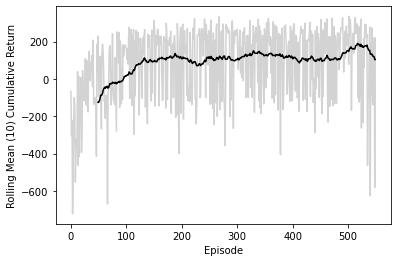

In [51]:
pd.DataFrame(history.history)ax = df['episode_reward'].plot(color = 'lightgray')
df['episode_reward'].rolling(50).mean().plot(color = 'black')
ax.set_xlabel("Episode")
plt.ylabel("Rolling Mean (10) Cumulative Return")
plt.show()

We see an immediate positive result. Although the rolling average hasn't increased massively, we are seing many more large positive numbers.

I decided to increase both the memory and the log interval again, to see if this would continue to improve performance.

In [74]:
rl['Model 8'] = [6, '128/64/32', 250000, 200000, 2500, None]

In [28]:
memory = SequentialMemory(limit=200000, window_length=6)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=30,
               target_model_update=1e-5, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [55]:
weights_filename = f'dqn_lunar_weights_eight.h5f'
checkpoint_weights_filename = 'dqn_lunar_weights_{step}.h5f'
log_filename = f'dqn_lunar_log.json'
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
start_time = time.time()
history = dqn.fit(env, callbacks=callbacks, nb_steps=250000, log_interval=2500)
end_time = time.time()

Training for 250000 steps ...
Interval 1 (0 steps performed)
2500/2500 [==============================] - 20s 8ms/step - reward: -0.0401
6 episodes - episode_reward: 10.497 [-348.233, 277.555] - loss: 4.766 - mae: 49.380 - mean_q: 55.695

Interval 2 (2500 steps performed)
2500/2500 [==============================] - 19s 7ms/step - reward: 0.4039
5 episodes - episode_reward: 137.459 [-105.190, 266.944] - loss: 3.963 - mae: 49.627 - mean_q: 64.135

Interval 3 (5000 steps performed)
2500/2500 [==============================] - 18s 7ms/step - reward: 0.5645
6 episodes - episode_reward: 229.995 [178.545, 277.034] - loss: 3.895 - mae: 50.012 - mean_q: 65.824

Interval 4 (7500 steps performed)
2500/2500 [==============================] - 18s 7ms/step - reward: 0.7021
9 episodes - episode_reward: 206.295 [-104.183, 280.230] - loss: 5.334 - mae: 51.652 - mean_q: 68.259

Interval 5 (10000 steps performed)
2500/2500 [==============================] - 18s 7ms/step - reward: 0.7029
7 episodes - epi

2500/2500 [==============================] - 20s 8ms/step - reward: 0.5147
6 episodes - episode_reward: 234.260 [163.084, 283.779] - loss: 7.379 - mae: 51.647 - mean_q: 68.539

Interval 41 (100000 steps performed)
2500/2500 [==============================] - 19s 8ms/step - reward: 0.6150
8 episodes - episode_reward: 179.692 [-100.000, 333.487] - loss: 7.831 - mae: 51.628 - mean_q: 68.558

Interval 42 (102500 steps performed)
2500/2500 [==============================] - 20s 8ms/step - reward: 0.4595
7 episodes - episode_reward: 172.209 [-100.000, 331.636] - loss: 8.441 - mae: 51.702 - mean_q: 68.782

Interval 43 (105000 steps performed)
2500/2500 [==============================] - 19s 8ms/step - reward: 0.6060
8 episodes - episode_reward: 192.932 [-218.159, 295.607] - loss: 8.313 - mae: 51.725 - mean_q: 68.804

Interval 44 (107500 steps performed)
2500/2500 [==============================] - 20s 8ms/step - reward: 0.4306
11 episodes - episode_reward: 94.976 [-100.000, 303.383] - loss: 8

2500/2500 [==============================] - 35s 14ms/step - reward: 0.6874
10 episodes - episode_reward: 178.893 [-211.815, 335.129] - loss: 8.251 - mae: 50.458 - mean_q: 67.274

Interval 82 (202500 steps performed)
2500/2500 [==============================] - 34s 14ms/step - reward: 0.3241
7 episodes - episode_reward: 109.868 [-144.025, 294.114] - loss: 9.147 - mae: 50.473 - mean_q: 67.221

Interval 83 (205000 steps performed)
2500/2500 [==============================] - 34s 14ms/step - reward: 0.6891
11 episodes - episode_reward: 173.461 [-309.883, 295.287] - loss: 8.134 - mae: 50.431 - mean_q: 67.200

Interval 84 (207500 steps performed)
2500/2500 [==============================] - 34s 14ms/step - reward: 0.2781
11 episodes - episode_reward: 54.727 [-235.540, 270.607] - loss: 8.194 - mae: 50.585 - mean_q: 67.342

Interval 85 (210000 steps performed)
2500/2500 [==============================] - 34s 14ms/step - reward: 0.8617
10 episodes - episode_reward: 210.206 [-103.342, 340.423] 

In [56]:
dqn.save_weights(weights_filename, overwrite=True)

In [279]:
weights.append(f'dqn_lunar_weights_eight.h5f')

In [280]:
models.append(dqn)
models[-1].load_weights(weights[-1])

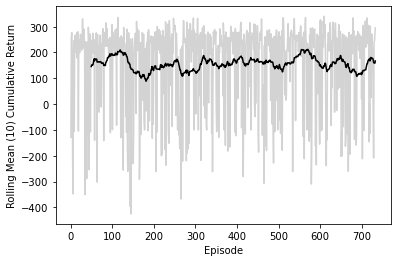

In [57]:
df = pd.DataFrame(history.history)
ax = df['episode_reward'].plot(color = 'lightgray')
df['episode_reward'].rolling(50).mean().plot(color = 'black')
ax.set_xlabel("Episode")
plt.ylabel("Rolling Mean (10) Cumulative Return")
plt.show()

The rolling average is now sitting between +100 and +200 reward, a massive leap from our previous model.

Out of curiosity I decided to see if we would get a similar performance improvement with a window length of 4.

In [58]:
df.to_csv('lunar_training_weights_8')

In [75]:
rl['Model 9'] = [4, '128/64/32', 250000, 200000, 2500, None]

In [281]:
# neural netwok model
model = Sequential()
model.add(Flatten(input_shape=(4,) + env.observation_space.shape))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))


In [282]:
memory = SequentialMemory(limit=200000, window_length=4)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=30,
               target_model_update=1e-5, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [64]:
weights_filename = f'dqn_lunar_weights_nine.h5f'
checkpoint_weights_filename = 'dqn_lunar_weights_{step}.h5f'
log_filename = f'dqn_lunar_log.json'
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
start_time = time.time()
history = dqn.fit(env, callbacks=callbacks, nb_steps=250000, log_interval=2500)
end_time = time.time()

Training for 250000 steps ...
Interval 1 (0 steps performed)
2500/2500 [==============================] - 20s 8ms/step - reward: -2.0730
19 episodes - episode_reward: -268.850 [-653.081, -81.307] - loss: 28.108 - mae: 4.082 - mean_q: -0.922

Interval 2 (2500 steps performed)
2500/2500 [==============================] - 18s 7ms/step - reward: -1.0069
14 episodes - episode_reward: -178.005 [-456.257, 49.384] - loss: 18.312 - mae: 3.150 - mean_q: 0.200

Interval 3 (5000 steps performed)
2500/2500 [==============================] - 18s 7ms/step - reward: -0.6521
8 episodes - episode_reward: -217.360 [-493.468, 192.192] - loss: 14.399 - mae: 2.962 - mean_q: 0.313

Interval 4 (7500 steps performed)
2500/2500 [==============================] - 17s 7ms/step - reward: -1.0356
15 episodes - episode_reward: -172.364 [-391.492, 222.306] - loss: 14.128 - mae: 2.803 - mean_q: 0.191

Interval 5 (10000 steps performed)
2500/2500 [==============================] - 17s 7ms/step - reward: -1.4603
15 epis

2500/2500 [==============================] - 24s 10ms/step - reward: -1.0146
10 episodes - episode_reward: -243.730 [-391.064, -20.839] - loss: 15.060 - mae: 2.849 - mean_q: 0.052

Interval 40 (97500 steps performed)
2500/2500 [==============================] - 23s 9ms/step - reward: -0.9317
14 episodes - episode_reward: -171.357 [-287.674, -83.606] - loss: 17.466 - mae: 2.949 - mean_q: 0.043

Interval 41 (100000 steps performed)
2500/2500 [==============================] - 22s 9ms/step - reward: -0.7490
14 episodes - episode_reward: -137.594 [-355.791, 22.129] - loss: 16.295 - mae: 3.007 - mean_q: 0.023

Interval 42 (102500 steps performed)
2500/2500 [==============================] - 23s 9ms/step - reward: -0.8939
12 episodes - episode_reward: -176.792 [-413.367, -45.491] - loss: 14.855 - mae: 2.918 - mean_q: 0.061

Interval 43 (105000 steps performed)
2500/2500 [==============================] - 25s 10ms/step - reward: -0.6088
15 episodes - episode_reward: -109.189 [-301.431, 319.36

2500/2500 [==============================] - 32s 13ms/step - reward: -0.8921
15 episodes - episode_reward: -148.627 [-349.184, -58.883] - loss: 13.337 - mae: 3.300 - mean_q: 0.261

Interval 78 (192500 steps performed)
2500/2500 [==============================] - 32s 13ms/step - reward: -0.5893
8 episodes - episode_reward: -207.937 [-304.378, -103.347] - loss: 13.827 - mae: 3.320 - mean_q: 0.248

Interval 79 (195000 steps performed)
2500/2500 [==============================] - 32s 13ms/step - reward: -0.8995
11 episodes - episode_reward: -190.030 [-311.836, -76.316] - loss: 13.080 - mae: 3.270 - mean_q: 0.297

Interval 80 (197500 steps performed)
2500/2500 [==============================] - 33s 13ms/step - reward: -1.0762
15 episodes - episode_reward: -178.206 [-351.413, -30.012] - loss: 13.321 - mae: 3.356 - mean_q: 0.247

Interval 81 (200000 steps performed)
2500/2500 [==============================] - 34s 13ms/step - reward: -0.4181
11 episodes - episode_reward: -102.209 [-278.794, 1

In [65]:
dqn.save_weights(weights_filename, overwrite=True)

In [283]:
weights.append(f'dqn_lunar_weights_nine.h5f')

In [284]:
models.append(dqn)
models[-1].load_weights(weights[-1])

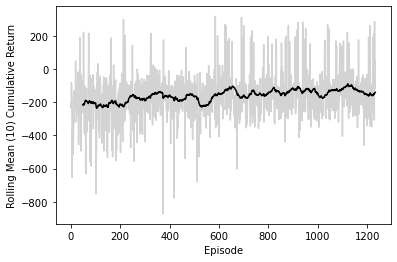

In [327]:
df = pd.read_csv('lunar_training_weights_9')
ax = df['episode_reward'].plot(color = 'lightgray')
df['episode_reward'].rolling(50).mean().plot(color = 'black')
ax.set_xlabel("Episode")
plt.ylabel("Rolling Mean (10) Cumulative Return")
plt.show()

No comparable performance bump is seen. It is clear the window length of 6 is key to our models improvement, and it was not just the increase in memory size and log intervals.

In [67]:
df.to_csv('lunar_training_weights_9')

## Test RL Models

As a final step I would like to test each trained model for 20 episodes, and have a look at the average reward. As keras-rl prints reward to the stdout when testing, and has no facility to redirect this output, I will redirect the stdout to txt files, and then read the model output back in from those text files

In [77]:
import sys
save = sys.stdout

In [320]:
# Testing each model for 20 episodes and saving reward output to files.
for i in range(0, 9):
    env = LunarEirLander.LunarEirLander()
    name = 'reward_' + str(i+1) + '.txt'
    sys.stdout = open(name, 'w+')
    models[i].test(env, nb_episodes=20, visualize=False)
    sys.stdout.close()

In [6]:
def get_file_reward(f):
    reward = []
    i = 1
    myfile = open(f)
    data = myfile.read().splitlines()
    data = [l.split(',') for l in data]
    while i < len(data):
        reward.append(data[i][0].split(' ')[-1])
        i += 1
    return(list(map(float, reward)))

In [ ]:
# Returning stdout to normal
sys.stdout = save

In [78]:
# retrieving saved rewards from txt files
rewards = []
for i in range(1, 10):
    rewards.append(np.array(get_file_reward('reward_'+str(i)+'.txt')))
    

In [79]:
for i, r in enumerate(rewards):
    rl['Model '+(str(i+1))]['Average Reward'] = r.mean()

In [80]:
rl

Model 1      Model 2    Model 3    Model 4    Model 5  \
Window Length           1            1          4          6          6   
Architecture    128/64/32  512/256/128  128/64/32  128/64/32  128/64/32   
Training Steps    5000000      5000000     250000     250000    2000000   
Memory Limit        50000        50000      50000      50000      50000   
Log Interval          500          500        500        500        500   
Average Reward   -192.067     -178.465   -41.0041   -247.724    -225.78   

                  Model 6    Model 7    Model 8    Model 9  
Window Length           4          6          6          4  
Architecture    128/64/32  128/64/32  128/64/32  128/64/32  
Training Steps    1999000     250000     250000     250000  
Memory Limit        50000     100000     200000     200000  
Log Interval          500       1500       2500       2500  
Average Reward    -454.22    -7.6643     66.188   -101.439

It is clear that model 8 with a window_length of 6, and the largest memory limit and log interval size, has performed the best. All other models have a negative reward average. It is also interesting note that this model only trained for 250,000 steps, and is significantly outperforming models that trained for 5,000,000 steps. This serves to highlight the importance of parameter selection.

In [83]:
# saving model 8 as the selected model
chosen_dqn = models[7]

# Comparison

*Deploy each of the two models trained to the Lunar Lander game to play 200 episodes and analyse the reward achieved by the models trained using each approach.*

First I will test the CNN model on 200 episodes and save the returned reward.

In [340]:
# Load and initialise the control model
ROWS = 32
COLS = 32
CHANNELS = 1

# Load a pre-trained model
model = keras.models.load_model("cnn_choice.mod")

# Load the Lunar Lander environment and initialise it
env = LunarEirLander.LunarEirLander()
s = env.reset()

# Run the game loop
rewards = []
steps = 0
done = False
for i in range(200):
    total_reward = 0
    steps = 0
    done = False
    s = env.reset()
    while not done:

        # Access the rednered scrnen image
        raw_image = env.render(mode='rgb_array')

        # Prepare the image for presentation to the network - ensure this matches how the model was trained
        processed_image = cv2.resize(raw_image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_RGB2GRAY)
        processed_image = np.array(processed_image, dtype=np.float)
        processed_image = processed_image.reshape((-1, ROWS, COLS, CHANNELS))
        processed_image = processed_image/255

        # Get the model to make a prediction
        a = np.argmax(model.predict(processed_image), axis=-1)
        a = a[0]

        # Step on the game
        s, r, done, info = env.step(a)
        env.render()
        total_reward += r

        steps += 1
    env.close()
 #   print(["{:+0.2f}".format(x) for x in s])
    print("step {} total_reward {:+0.2f}".format(steps, total_reward))
    rewards.append(total_reward)

step 97 total_reward -499.95
step 90 total_reward -467.13
step 58 total_reward -402.87
step 76 total_reward -517.58
step 177 total_reward -643.93
step 65 total_reward -604.49
step 106 total_reward -221.56
step 99 total_reward -633.50
step 51 total_reward -431.62
step 95 total_reward -438.57
step 78 total_reward -577.88
step 92 total_reward -349.71
step 80 total_reward -383.65
step 88 total_reward -340.22
step 145 total_reward -316.28
step 118 total_reward -405.85
step 98 total_reward -505.19
step 84 total_reward -461.57
step 53 total_reward -519.76
step 93 total_reward -455.70
step 126 total_reward -464.70
step 87 total_reward -803.66
step 76 total_reward -618.42
step 102 total_reward -494.10
step 104 total_reward -1115.38
step 101 total_reward -0.30
step 79 total_reward -165.36
step 200 total_reward -605.19
step 1 total_reward -100.00
step 175 total_reward -616.92
step 82 total_reward -600.49
step 105 total_reward -270.55
step 64 total_reward -552.41
step 78 total_reward -201.52
step 

In [341]:
# Saving rewards to a text file so I can recover these later if needed
with open('cnn_rewards_backup.txt', 'w') as filehandle:
    for r in rewards:
        filehandle.write('%s\n' % r)

Now I shall deploy the RL model for 200 episdoes and save the reward.

In [ ]:
name = 'final_rl_reward.txt'
# Redirecting stdout output to my file
sys.stdout = open(name, 'w+')
chosen_dqn.test(env, nb_episodes=200, visualize=False)
sys.stdout.close()

In [ ]:
# Returning stdout to normal
sys.stdout = save

In [7]:
# Recovering RL reward from file
rl_reward = np.array(get_file_reward('final_rl_reward.txt'))

In [8]:
# Recovering CNN reward from file
cnn_reward = []
myfile = open('cnn_rewards_backup.txt')
data = myfile.read().splitlines()
data = [l.split(' ') for l in data]
for i in range(len(data)):
    cnn_reward.append(data[i][-1])
cnn_reward = np.array(list(map(float, cnn_reward)))

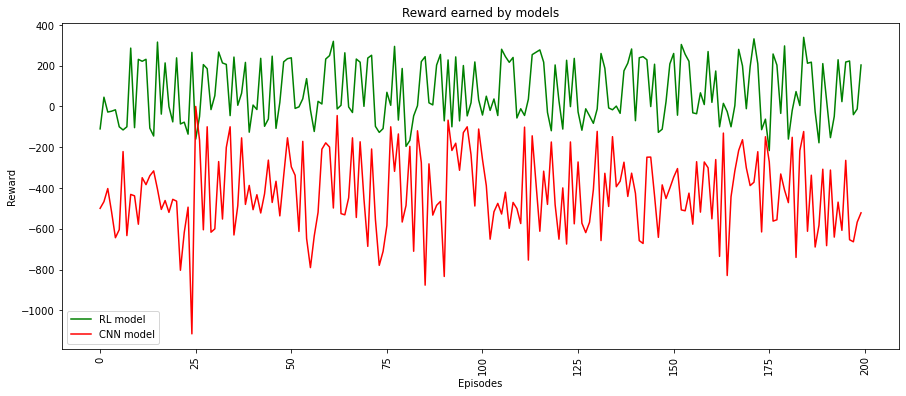

In [87]:
plt.figure(figsize=(15,6))
plt.xlabel('Episodes')
plt.xticks(rotation=90)
plt.ylabel('Reward')
plt.plot(rl_reward, 'green', label='RL model')
plt.plot(cnn_reward, 'red', label='CNN model')
plt.legend()
plt.title("Reward earned by models")
plt.show()

Here we can see the RL model reward plotted against the CNN model reward. The RL model consistently outperform the CNN model. 

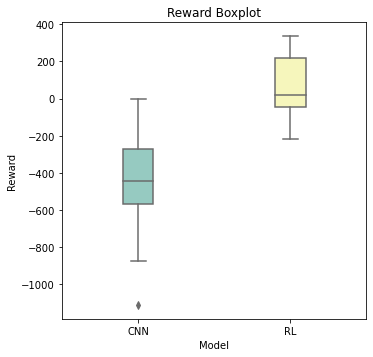

In [95]:
plt.figure(figsize = (12,12))

plt.subplot(2,2,1)
seaborn.boxplot(data=[cnn_reward, rl_reward], orient='v', width = 0.2, palette="Set3")
label = ["CNN", "RL"]
index = np.arange(len(label))
plt.xticks(index, label)
plt.xlabel("Model")
plt.ylabel("Reward")
plt.title("Reward Boxplot")

plt.show()


Here is another view on the reward distribution between the two models. RL's better performance is quite clear. But, we can also see that CNN is more instable, it has a much larger range of reward, when looking at the distance between its' minimum value whisker and maximum value. It also has a significant outlier. The RL model has a smaller range between the whiskers, and no outliers. 

In [24]:
stats = pd.DataFrame(index=['Average Reward', '% Positive', 'Max Reward', 'Min Reward', 'Reward Range'])

In [28]:
stats['CNN'] = [cnn_reward.mean(), (np.sum(np.array(cnn_reward) >= 0) / cnn_reward.size) * 100, np.amax(cnn_reward), np.amin(cnn_reward), 0]
stats['RL'] = [rl_reward.mean(), (np.sum(np.array(rl_reward) >= 0) / rl_reward.size) * 100, np.amax(rl_reward), np.amin(rl_reward), 0]
stats['CNN']['Reward Range'] = stats['CNN']['Max Reward'] - stats['CNN']['Min Reward']
stats['RL']['Reward Range'] = stats['RL']['Max Reward'] - stats['RL']['Min Reward']


## Discussion

##### Approach 
 - My approach for both models was to find a simple network architecture that worked, and build from there. With CNN I focused on improving performance through manipulation of the training data, as the most visible and identifiable weaknesses lay there. Screen captures lack the context of sequence or direction, and there was also a large class imbalance. It is possible, and likely, that performance could have been further improved by playing with the architecture more, i.e. varying filter sizes or adding additional layers. But, with limited time and resources it felt like a data-focused corrective approach would give the best immediate payoff. With RL, as the data is generated by the game environment, I did not need to address the same issues. Here instead, I focused on improving performance through parameter choice. As with CNN, it is possible my RL network could have been improved with a more involved network architecture, but I do feel the evolution in my parameter choices were logical and were supported by significant performance gains. I think it is very possible that with more time and further computational resources I could have trained the model to an even better performance level. 

##### Results and Performance
- Given that both models had many iterations of exploration, I presented the results of my experiments progressively throughout this notebook. Please refer to [here](#Test-RL-Models) and [here](#CNN-Model-Comparisons). Overall, I think it is clear that reinforcement learning is much better suited to this particular task than CNN. Looking at the metric of reward, the RL model has outperformed CNN significantly, with an average reward of 72 verus an average reward of -426 over 200 episodes. Equally, if we consider the amount of pre-training labour needed to get to those results, CNN requires an expert player to play the game, screen caps of their moves, labelling of said moves, even before considering stacking images or rebalancing the data. The potential for human error is high. This compared to RL, where the model simply needs to play the game. Equally, the performance of the CNN model will always be capped by the performance of your chosen “expert player”. The RL model may be able to discover patterns and behaviours previously unidentified by an “expert”. 

In [29]:
stats

CNN          RL
Average Reward  -425.676644   71.852345
% Positive         0.000000   57.500000
Max Reward        -0.298372  338.623000
Min Reward     -1115.378576 -216.629000
Reward Range    1115.080204  555.252000

##### Computational Cost
- Training the RL models took significantly more time and resources. When training a model for 5,000,000 steps, training took roughly a full day. In comparison, the longest training time recorded for my CNN models was 1375.32 seconds, or 22.92 minutes. That said, the “best” RL model, used for comparison against CNN, had actually only trained for 250,000 steps or around 1 hour. So, less-temporally demanding training can still give you satisfactory results and I believe this training time could have been further improved had I connected to a Google cloud instance or similar for extra computational power. There is certainly a computational cost/performance trade-off to be considered here, but I think the results of the RL model do warrant the extra time taken.